# Initializations

## Import libraries

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import io
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import s3fs
import time
import pickle
from datetime import datetime
import scipy
print(scipy.__version__)
# from scipy.stats import median_absolute_deviation
from pycytominer import normalize, feature_select
 
pio.renderers.default = "png"  # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots
pd.set_option('display.width', 140)

1.11.4


In [3]:
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
time_fmt = '%Y-%M-%d %H:%m:%S.%f'
time_fmt = '%Y-%M-%d %H:%m:%S.%f' 
print(datetime.now().strftime(time_fmt))

01/25/24-08:42:48.878463
2024-42-25 08:01:48.878925


In [4]:
gzip_compression_options = {"method": "gzip", 'compresslevel': 1,"mtime": 1}

metadata_path = "../cj-datasets/metadata"
plates = pd.read_csv(os.path.join(metadata_path,"plate.csv.gz"))
wells = pd.read_csv(os.path.join(metadata_path,"well.csv.gz"))
compound = pd.read_csv(os.path.join(metadata_path,"compound.csv.gz"))
orf = pd.read_csv(os.path.join(metadata_path,"orf.csv.gz"))


## gz, bz2, zip, tar, tar.gz, tar.bz2
# types = ['.gz', '.bz2','.zip', '.tar', '.tar.gz', '.tar.bz2']
type_bz2 = 'bz2'
type_gzip = 'gz'


In [5]:
input_path ="./metadata/"
output_path = "./output_11102023/"
prefix = '' ### Target-2' , 'MOA'
prefix_lc = prefix.lower().replace('-', '_')


CompoundExtendedMetadataFile        = f"{output_path}{prefix_lc}compound_extended_metadata.csv"

CompoundExtendedMetadata5SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_5samples.csv"
CompoundProfiles5SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_5samples.csv"

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_2samples.csv"

# CompoundProfiles2SampleFileParquet  = f"{output_path}{prefix_lc}compound_profiles_2samples.parquet"
# CompoundProfiles2SampleFileGZ       = f"{output_path}{prefix_lc}compound_profiles_2samples.gz"

CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}compound_extended_metadata_samples.csv"
featureSelectionFile                = f"{output_path}{prefix_lc}_normalized_feature_select.csv.gz"

print(f" ")
print(f" Compound Extended MetadataFile              : {CompoundExtendedMetadataFile }")

print(f" Compound Extended Metadata 5 SampleFile     : {CompoundExtendedMetadata5SampleFile }")
print(f" Compound Profiles 5 Sample File CSV         : {CompoundProfiles5SampleFileCSV }")

print(f" ")
print(f" Compound Extended Metadata 2 SampleFile     : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV        : {CompoundProfiles2SampleFileCSV}")
# print(f" ")
# print(f" CompoundProfiles2SamplesFile Parquet        : {CompoundProfiles2SampleFileParquet }")
# print(f" CompoundProfiles2SamplesFile gz             : {CompoundProfiles2SampleFileGZ }")
print(f" ")
print(f" featureSelectionFile                        : {featureSelectionFile}")


 
 Compound Extended MetadataFile              : ./output_11102023/compound_extended_metadata.csv
 Compound Extended Metadata 5 SampleFile     : ./output_11102023/compound_extended_metadata_5samples.csv
 Compound Profiles 5 Sample File CSV         : ./output_11102023/compound_profiles_5samples.csv
 
 Compound Extended Metadata 2 SampleFile     : ./output_11102023/compound_extended_metadata_2samples.csv
 Compound Profiles 2 Samples File CSV        : ./output_11102023/compound_profiles_2samples.csv
 
 featureSelectionFile                        : ./output_11102023/_normalized_feature_select.csv.gz


## Helper functions

In [6]:
profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

## images
loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)

# csv_formatter = (
#     "/mnt/i/cellpainting-gallery/cpg0016-jump/{Metadata_Plate}.csv")
#     # "{Metadata_Source}/workspace/profiles/"
#     # "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.csv"

# local_formatter = (
#     "/mnt/i/cellpainting-gallery/cpg0016-jump/"
#     "{Metadata_Source}/workspace/profiles/"
#     "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
# )

csv_formatter = (
    "/mnt/i/cellpainting-gallery/cpg0016-jump/{2}.csv")
    # "{Metadata_Source}/workspace/profiles/"
    # "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.csv"

local_formatter = (
    "/mnt/i/cellpainting-gallery/cpg0016-jump/"
    "{0}/workspace/profiles/"
    "{1}/{2}/{2}.parquet"
)

### Load Profile routines ( amazon S3 / local )

In [7]:
def read_profiles_from_s3(sample_set, s3_path):
    for i, row in sample_set.iterrows():
        # print(f'row : \n{row}')
        print(f"Metadata {i}  Source:{row['Metadata_Source']}  Batch:{row['Metadata_Batch']}   Plate:{row['Metadata_Plate']}   Plate Type:{row['Metadata_PlateType']}")
        s3_path = profile_formatter.format(**row.to_dict())
        print(f"Path: {s3_path}")
        dframes.append(
            pd.read_parquet(s3_path, storage_options={"anon": True}, columns=columns)
        )
        temp_dframes = pd.concat(dframes)
        stats = get_stats(stats, temp_dframes)
        # break
    dframes = pd.concat(dframes) 


def read_profiles_from_local(keys, source, columns):
    read_frames = []
    Metadata_Source, Metadata_Batch, Metadata_Plate = keys
    source_path = source.format(Metadata_Source, Metadata_Batch, Metadata_Plate)
    df = pd.read_parquet(source_path, columns=columns)
    
    # print(len(df.columns.to_list()))
    return df

In [8]:
# Get the bucket name and key of the parquet file
# bucket_name = 'my-bucket'
# key = 'my-file.parquet'

# Copy the file to a local location
# with open('my-file.parquet', 'wb') as f:
    # s3.download_file(bucket_name, key, f)

In [9]:
def cat_columns(column_list = None):
    from collections import defaultdict
    if isinstance(column_list, pd.DataFrame):
        print(f" input is dataframe shape: {column_list.shape}")
        column_list = column_list.columns.to_list()
    elif isinstance(column_list, list):
        print(f" input is list length {len(column_list)}")

    len(column_list)
    # col_list[:12]
    # keys = ["Cells_", "Cytoplasm_", "Nuclei_", "Metadata_", "Image_Granularity_", "Image_Intensity_", "Image_Texture_", "Image_Threshold_", "Image_ImageQuality_"]
    keys = ["Cells", "Cytoplasm", "Nuclei", "Metadata", "Image_Granularity", 
            "Image_Intensity", "Image_Texture", "Image_Threshold", "Image_ImageQuality", "Texture",
            "Channel", "Count", "ExecutionTime", "FileName", "Frame", "Granularity", "MD5Digest", "Width", "Height",
            "Series", "ModuleError", "PathName", "Scaling", "Threshold", "URL"]
    key_len = [len(x) for x in keys]
    ttls = defaultdict(int)  ## {'Cells': 0, 'Cytoplasm': 0 , 'Nuclei' : 0, 'Metadata': 0, 'Other': 0}
    cols = defaultdict(list)
    
    for i in column_list:
        for j  in range(len(keys)):
            if i[:key_len[j]] == keys[j]:
                # print(f" found   {j}  - {keys[j]}  {key_len[j]}    {i[:key_len[j]]}")
                ttls[keys[j]] += 1
                cols[keys[j]].append(i)
                break
        else:
            cols['Other'].append(i)
            ttls['Other']+= 1
            # print(f" not found :   {i}")
    
    for k,v in ttls.items():
        print(f" Field type: {k:20s}    count: {v}")   
    return cols

def get_cols_like(col_list, pattern = None):
    import re
    if not isinstance(pattern, list):
        pattern = [pattern]
    result = []
    for pat in pattern:
        p = re.compile(pat)    
        result += [ i for i in col_list if p.search(i) is not None]
    return result 

def disp_stats(df, cols):
    n_rows = df.shape[0]
    print(f"{' ':4s} {' ':60s}: {'min':>10s}   {'max':>10s}   {'std':>10s}   {'var':>10s}   {'mean':>10s}   {'median':>10s}    {'uniq rto':>10s}    {'freq rto':>10s}   {'quantile':^50s}")
    for ctr, i in enumerate(cols):
        print(f"{ctr:4d} {i[:60]:60s}: {df[i].min():10.2f}   {df[i].max():10.2f}   {df[i].std():10.2f}   {df[i].var():10.2f}"\
              f"   {df[i].mean():10.2f}   {df[i].median():10.2f}    {df[i].nunique()/n_rows:10.2f}    {calculate_frequency(df[i]):10.2f}     {np.quantile(df[i], [0.0,0.25, 0.50, 0.75,1.00] )}")

def check_values(df, cols):
    # if df is not None:
    #     print(f" dataframe shape: {df.shape}")
    #     cols = df.columns.to_list()
    # else:
    #     cols = column_list
    # len(col_list)    
    inv_columns = []
    n_rows = df.shape[0]
    print(f"\n Columns with invalid data from {len(cols)} columns " \
          f" {'min':>10s}    {'max':>10s}    {'std':>10s}    {'mean':>10s}    {'median':>10s}    {'quantile':^50s}")    
    for ctr, i in enumerate(cols):
        if (pd.isna(df[i].min()) or pd.isna(df[i].max()) or pd.isna(df[i].std()) 
           or df[i].max() == np.inf ): 
            inv_columns.append(i)
            print(f"{ctr:4d} {i[:45]:45s}: {df[i].min():10.2f}    {df[i].max():10.2f}    {df[i].std():10.2f}"\
                  f"    {df[i].mean():10.2f}    {df[i].median():10.2f}    {np.quantile(df[i], [0.0,0.25, 0.50, 0.75,1.00] )}")  
    if len(inv_columns) == 0:
        print(f" **** No Invalid Numeric Columns Found ****")
    return inv_columns

def reduce_col_sizes(df, cols):
    flt_cnt, int_cnt = 0, 0 
    for i in  cols:
        if df[i].dtype == 'float64':
            flt_cnt +=1
            df[i] = df[i].astype('float32')
            # print(f" {i} converted from float64 to {dframe[i].dtype}")
        elif df[i].dtype ==  np.dtype(object): 
            df[i] = df[i].astype(np.string_)
            print(f" {i} converted from object to np.string")
        elif df[i].dtype == 'int64':
            int_cnt += 1
            df[i] = df[i].astype('int32')
            print(f" {i} converted to int64 {dframe[i].dtype}")
    return df, flt_cnt, int_cnt

def calculate_frequency(feature_column):
    """Calculate frequency of second most common to most common feature.
    
    Parameters
    ----------
    feature_column : Pandas series of the specific feature in the population_df

    Returns
    -------
    Feature name if it passes threshold, "NA" otherwise
    """
    
    val_count = feature_column.value_counts()
    
    try:
        max_count = val_count.iloc[0]
    except IndexError:
        return np.nan
    
    try:
        second_max_count = val_count.iloc[1]
    except IndexError:
        return np.nan

    freq = second_max_count / max_count
    return freq

## Parquet files column metadata

# Loading JUMP Cell Painting Metadata 
<!-- This notebook loads a small number of plates with precomputed features and the metadata information. -->

- Order Extended Metadata Data set by Source, Batch, Plate

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

## Build Profile Columns Metadata (if not existing)

Build dictionary of Parquet data columns - write columns to pickle

This list of column names will allow us to identify & control the columns we want to load from parquet files

In [25]:
# # keys = ('source_1', 'Batch1_20221004', 'UL001641')
# keys = ('source_6' , 'p210920CPU2OS48hw384exp028JUMP',   '110000296345') 

# dframe = read_profiles_from_local(keys, local_formatter,  columns = None)
# cols = dframe.columns.to_list()
# print(f" rows: {len(dframe)}  columns {len(cols)}")      
# cat_cols = cat_columns(dframe)

 rows: 384  columns 4765
 dataframe shape: (384, 4765)
 Field type: Metadata                count: 3
 Field type: Cells                   count: 1256
 Field type: Cytoplasm               count: 1241
 Field type: Image_Granularity       count: 80
 Field type: Image_ImageQuality      count: 107
 Field type: Image_Intensity         count: 110
 Field type: Image_Texture           count: 780
 Field type: Image_Threshold         count: 12
 Field type: Nuclei                  count: 1176


In [764]:
# tt = [] 
# for k in cols:
#     if (dframe[k].dtype in [np.int64]):
#         print(f" {k:50s}   {dframe[k].dtype}")
#         tt.append(k)
# len(tt)


In [768]:
# ParquetColumns = { 'Metadata' : {x: dframe[x].dtype for x in cat_cols['Metadata']},
#                    'Cells'    : {x: dframe[x].dtype for x in cat_cols['Cells']},
#                    'Cytoplasm': {x: dframe[x].dtype for x in cat_cols['Cytoplasm']},
#                     'Nuclei'  : {x: dframe[x].dtype for x in cat_cols['Nuclei']},
#                     'Image'   : {x: dframe[x].dtype for x in (cat_cols['Image_Granularity']+ cat_cols['Image_ImageQuality'] + 
#                                                               cat_cols['Image_Intensity']  + cat_cols['Image_Texture']      + 
#                                                               cat_cols['Image_Threshold'])},
#                  }

# print(len(floatConversion) + len(intConversion))
# import pickle
# with open("./metadata/parquet_columns.pkl", 'wb') as f: 
#     pickle.dump(ParquetColumns,f)

4762


In [14]:
# del ParquetColumns

# with open("./metadata/parquet_columns.pkl",'rb') as f:
#     ParquetColumns = pickle.load(f)

# for k,v in ParquetColumns.items():
#     print(f" {k:20s}   items: {len(v)}")

# for k,v in ParquetColumns['Cytoplasm'].items():
#     print(f" {k:50s}   type: {v}")


## Plates

**Plate Types:**

- **COMPOUND:** Plates of cells perturbed by chemical compounds.
- **DMSO:** Plates of cells perturbed by DMSO (compound negative control) in all the wells.
- **TARGET2:** Positive control plates, as described in https://github.com/jump-cellpainting/JUMP-Target.
- **COMPOUND_EMPTY:** Plates of untreated cells in all the wells.
- **ORF:** Plate of cells perturbed by ORFs.
- **TARGET1:** Plates of Target-1 compounds, as described in https://github.com/jump-cellpainting/JUMP-Target. -- DO NOT USE 
- **POSCON8:** Plate of cells perturbed by eight compound positive controls.

In [12]:
plates.info()
plates.head(100)
print("Unique source counts:", plates['Metadata_Source'].unique())
print("Unqiue batch counts :", len(plates['Metadata_Batch'].unique()))
print("Unqiue plate counts :", len(plates['Metadata_Plate'].unique()))
print("Unqiue platetype counts :", plates['Metadata_PlateType'].unique())
print("Number of batches   :", plates.Metadata_Batch.unique().shape[0])
plates.Metadata_PlateType.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     2378 non-null   object
 1   Metadata_Batch      2378 non-null   object
 2   Metadata_Plate      2378 non-null   object
 3   Metadata_PlateType  2378 non-null   object
dtypes: object(4)
memory usage: 74.4+ KB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY
1,source_1,Batch1_20221004,UL001641,COMPOUND
2,source_1,Batch1_20221004,UL001643,COMPOUND
3,source_1,Batch1_20221004,UL001645,COMPOUND
4,source_1,Batch1_20221004,UL001651,COMPOUND
...,...,...,...,...
95,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152610,COMPOUND
96,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152745,COMPOUND
97,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152921,COMPOUND
98,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-153057,COMPOUND


Unique source counts: ['source_1' 'source_10' 'source_11' 'source_13' 'source_2' 'source_3'
 'source_4' 'source_5' 'source_6' 'source_7' 'source_8' 'source_9']
Unqiue batch counts : 143
Unqiue plate counts : 2378
Unqiue platetype counts : ['COMPOUND_EMPTY' 'COMPOUND' 'DMSO' 'TARGET2' 'CRISPR' 'ORF' 'TARGET1'
 'POSCON8']
Number of batches   : 143


Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

## Wells

In [13]:
wells.info()
wells.head()
print("Unique source counts:", wells['Metadata_Source'].unique())
print("Unqiue well counts :", len(wells['Metadata_Well'].unique()))
print("Unqiue plate counts:", len(wells['Metadata_Plate'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096074 entries, 0 to 1096073
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096074 non-null  object
 1   Metadata_Plate    1096074 non-null  object
 2   Metadata_Well     1096074 non-null  object
 3   Metadata_JCP2022  1096074 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227
2,source_1,UL000081,A04,JCP2022_033924
3,source_1,UL000081,A05,JCP2022_047857
4,source_1,UL000081,A06,JCP2022_072229


Unique source counts: ['source_1' 'source_10' 'source_11' 'source_13' 'source_2' 'source_3'
 'source_4' 'source_5' 'source_6' 'source_7' 'source_8' 'source_9']
Unqiue well counts : 1536
Unqiue plate counts: 2378


## Compound

In [14]:
compound.info()
compound.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...


## ORF

**ORF Types:**

trt are ORF treatments, where the cells are perturbed by an ORF treatment.
- **poscon** are four compound treatments that are used as positive control.
- **negcon** are four ORF treatments that are used as negative control. They are not expected to cause morphological changes.

In [16]:
orf.info()
orf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15142 entries, 0 to 15141
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Metadata_JCP2022           15142 non-null  object 
 1   Metadata_broad_sample      15142 non-null  object 
 2   Metadata_Name              15132 non-null  object 
 3   Metadata_Vector            15142 non-null  object 
 4   Metadata_Transcript        15106 non-null  object 
 5   Metadata_Symbol            15107 non-null  object 
 6   Metadata_NCBI_Gene_ID      15107 non-null  object 
 7   Metadata_Taxon_ID          15107 non-null  object 
 8   Metadata_Gene_Description  14853 non-null  object 
 9   Metadata_Prot_Match        14320 non-null  float64
 10  Metadata_Insert_Length     15141 non-null  float64
 11  Metadata_pert_type         15142 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt


## Parquet Profile Columns Metadata 

Parquet files column metadata

In [ ]:
with open("./metadata/parquet_columns.pkl",'rb') as f:
    ParquetColumns = pickle.load(f)

for k,v in ParquetColumns.items():
    print(f" {k:20s}   items: {len(v)}")
# print(ParquetColumns['Cytoplasm'])

  ### Define different cell groups

In [27]:
cell_fld_grps = ['Cells_AreaShape', 'Cells_Children', 'Cells_Correlation', 
                 ## 'Cells_Correlation_Correlation', 'Cells_Correlation_K', 'Cells_Correlation_Manders','Cells_Correlation_Overlap', 'Cells_Correlation_RWC',
                 ## 'Cells_RadialDistribution_FracAtD', 'Cells_RadialDistribution_MeanFrac', 'Cells_RadialDistribution_RadialCV',
                 'Cells_Granularity', 'Cells_Intensity', 'Cells_Neighbors', 'Cells_Parent',
                 'Cells_RadialDistribution', 
                 'Cells_Texture', 
                 'Cells_Texture_AngularSecondMoment','Cells_Texture_Contrast', 'Cells_Texture_Correlation',
                 'Cells_Texture_DifferenceEntropy', 'Cells_Texture_DifferenceVariance', 'Cells_Texture_Entropy',
                 'Cells_Texture_InfoMeas1' , 'Cells_Texture_InfoMeas2' , 'Cells_Texture_InverseDifferenceMoment',
                 'Cells_Texture_SumAverage', 'Cells_Texture_SumEntropy', 'Cells_Texture_SumVariance',  'Cells_Texture_Variance']
for grp in cell_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")
print('\n')    
# cytoplasm_fld_names = [ x for x in ParquetColumns['Cytoplasm'].keys()]
# cytoplasm_fld_grps = set([x.split('_')[1] for x in cytoplasm_fld_names])
# cytoplasm_fld_grps = ['Cytoplasm_'+ x for x in cytoplasm_fld_grps]
# cytoplasm_fld_grps
cytoplasm_fld_grps = ['Cytoplasm_Texture',
                      'Cytoplasm_Number',
                      'Cytoplasm_Intensity',
                      'Cytoplasm_RadialDistribution',
                      'Cytoplasm_Granularity',
                      'Cytoplasm_Correlation',
                      'Cytoplasm_AreaShape']

for grp in cytoplasm_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")
print('\n')
# nuclei_fld_names = [ x for x in ParquetColumns['Nuclei'].keys()]
# nuclei_fld_grps = set([x.split('_')[1] for x in nuclei_fld_names])
# nuclei_fld_grps = ['Nuclei_'+ x for x in nuclei_fld_grps]
# nuclei_fld_grps
# ##nuclei_fld_names
nuclei_fld_grps = ['Nuclei_Location',
                   'Nuclei_Neighbors',
                   'Nuclei_ObjectSkeleton',
                   'Nuclei_Parent',
                   'Nuclei_Number',
                   'Nuclei_Intensity',
                   'Nuclei_Children',
                   'Nuclei_RadialDistribution',
                   'Nuclei_Granularity',
                   'Nuclei_Correlation',
                   'Nuclei_AreaShape',
                   'Nuclei_Texture']
 
for grp in nuclei_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")


 Cells_AreaShape                               53
 Cells_Children                                1
 Cells_Correlation                             80
 Cells_Granularity                             80
 Cells_Intensity                               75
 Cells_Neighbors                               14
 Cells_Parent                                  1
 Cells_RadialDistribution                      171
 Cells_Texture                                 780
 Cells_Texture_AngularSecondMoment             60
 Cells_Texture_Contrast                        60
 Cells_Texture_Correlation                     60
 Cells_Texture_DifferenceEntropy               60
 Cells_Texture_DifferenceVariance              60
 Cells_Texture_Entropy                         60
 Cells_Texture_InfoMeas1                       60
 Cells_Texture_InfoMeas2                       60
 Cells_Texture_InverseDifferenceMoment         60
 Cells_Texture_SumAverage                      60
 Cells_Texture_SumEntropy                      60


  ### Specify columns to read from extMetadata and parquet files

In [34]:
extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022"]
extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "TPSA"  , "lnTPSA"  , "log10TPSA", "permiation"]
extMetadataNames   = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "Metadata_TPSA", "Metadata_lnTPSA", "Metadata_log10TPSA","permiation"]
categoricalColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well"]

print(' Ext Metadata Columns : ', extMetadataColumns)
print(' Categorical columns  : ', categoricalColumns) 
print(' Parquet Metadata Columns: ' ,ParquetColumns['Metadata'])

## all numeric columns 
numeric_columns  =  ParquetColumns['Cells'] | ParquetColumns['Cytoplasm'] | ParquetColumns['Nuclei']

print(f" all numeric columns: {len(numeric_columns)}")
 
## Remove numeric columns that contains bad values
for x in ['Cells_AreaShape_FormFactor', 'Cytoplasm_AreaShape_FormFactor', 'Nuclei_AreaShape_FormFactor']:
    del numeric_columns[x]
print(f" all numeric columns after removal of FormFactor Columns : {len(numeric_columns)}")

numeric_cols_list = [x for x in numeric_columns.keys()]

## Conversion dictionary for reading CSV files 
conversionDict = dict()
for k,v in numeric_columns.items():
    conversionDict[k] = np.float32

print(f" conversion dict length: {len(conversionDict)}")

conversionDict |= {x:'category'  for x in categoricalColumns}
print(f" conversion dict length (after addition of Categorical columns): {len(conversionDict)}")

## get_column list for fields to read from Parquet files 
get_columns = list(ParquetColumns['Metadata'] | numeric_columns)
print(f" all get_columns    : {len(get_columns)}")
# print(get_columns[:20])

## join Columns 
join_columns = extMetadataNames + list(numeric_columns)
print(f" all columns in join: {len(join_columns)}")
join_columns[:7]


print('\n\n')
print(f" Numeric columns :")
print(f"------------------")
_ = cat_columns(numeric_cols_list)

 Ext Metadata Columns :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'TPSA', 'lnTPSA', 'log10TPSA', 'permiation']
 Categorical columns  :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well']
 Parquet Metadata Columns:  {'Metadata_Source': dtype('O'), 'Metadata_Plate': dtype('O'), 'Metadata_Well': dtype('O')}
 all numeric columns: 3673
 all numeric columns after removal of FormFactor Columns : 3670
 conversion dict length: 3670
 conversion dict length (after addition of Categorical columns): 3674
 all get_columns    : 3673
 all columns in join: 3679


['Metadata_Source',
 'Metadata_Batch',
 'Metadata_Plate',
 'Metadata_Well',
 'Metadata_JCP2022',
 'Metadata_TPSA',
 'Metadata_lnTPSA']




 Numeric columns :
------------------
 input is list length 3670
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


## Sample plates
Let's sample two plates of a certain type (encoded in `Metadata_PlateType`) from each data-generating center (`Metadata_Source`). Note that only 10 out of the 13 sources are currently available and `source_1` does not have the plate type being queried below.

In [28]:
sample = (
    plates.query('Metadata_PlateType=="COMPOUND"')
    .groupby("Metadata_Source")
    .sample(2, random_state=42)   ## sample 2 per Metadata_Source
)
sample
# sample.Metadata_Batch.sum()


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
47,source_1,Batch6_20221102,UL000585,COMPOUND
44,source_1,Batch6_20221102,UL000579,COMPOUND
140,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-145122,COMPOUND
101,source_10,2021_06_14_U2OS_48_hr_run5,Dest210614-162933,COMPOUND
305,source_11,Batch1,EC000029,COMPOUND
316,source_11,Batch2,EC000044,COMPOUND
702,source_2,20210719_Batch_6,1086294024,COMPOUND
814,source_2,20210830_Batch_11,1086290477,COMPOUND
1071,source_3,CP_33_all_Phenix1,A13407bW,COMPOUND
875,source_3,CP60,BR5874c3,COMPOUND


`TARGET2` plates are "sentinel" plates that are run in each batch. More on all this in future updates.

## Extended Metadata 

In [35]:
# extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "TPSA", "lnTPSA", "log10TPSA"]
# categoricalColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well"]

print(' Ext Metadata Columns : ', extMetadataColumns)
print(' Categorical columns  : ', categoricalColumns) 

CompoundExtendedMetadata2SampleFile

 Ext Metadata Columns :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'TPSA', 'lnTPSA', 'log10TPSA', 'permiation']
 Categorical columns  :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well']


'./output_11102023/compound_extended_metadata_2samples.csv'

In [47]:
ext_metadata = pd.read_csv(CompoundExtendedMetadata2SampleFile, 
                           usecols = extMetadataColumns,
                           header=0)
ext_metadata.sort_values(by=categoricalColumns, inplace=True, ignore_index=True )

In [48]:
ext_metadata.info()
ext_metadata.head(5)
ext_metadata.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231028 entries, 0 to 231027
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Metadata_JCP2022  231028 non-null  object 
 1   Metadata_Source   231028 non-null  object 
 2   Metadata_Batch    231028 non-null  object 
 3   Metadata_Plate    231028 non-null  object 
 4   Metadata_Well     231028 non-null  object 
 5   TPSA              231028 non-null  float64
 6   lnTPSA            231028 non-null  float64
 7   log10TPSA         231028 non-null  float64
 8   permiation        231028 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 15.9+ MB


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_036592,source_1,Batch1_20221004,UL001641,A05,82.21,4.409277,1.914925,0
1,JCP2022_071885,source_1,Batch1_20221004,UL001641,A06,54.50,3.998201,1.736397,0
2,JCP2022_078645,source_1,Batch1_20221004,UL001641,A08,90.58,4.506233,1.957032,0
3,JCP2022_098761,source_1,Batch1_20221004,UL001641,A11,103.50,4.639572,2.014940,1
4,JCP2022_070236,source_1,Batch1_20221004,UL001641,A15,31.60,3.453157,1.499687,0


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,TPSA,lnTPSA,log10TPSA,permiation
231023,JCP2022_050165,source_9,20211103-Run16,GR00004421,Z08,58.56,4.070052,1.767601,0
231024,JCP2022_076910,source_9,20211103-Run16,GR00004421,Z09,127.09,4.844895,2.104111,1
231025,JCP2022_083151,source_9,20211103-Run16,GR00004421,Z12,120.49,4.791567,2.080951,1
231026,JCP2022_073861,source_9,20211103-Run16,GR00004421,Z18,95.44,4.558498,1.979730,0
231027,JCP2022_099794,source_9,20211103-Run16,GR00004421,Z19,99.28,4.597944,1.996862,0


In [49]:
# ext_metadata.reset_index(drop=True, inplace = True)
# print('---------------------------------------------------------------')
# print(' After Index Reset')
# print('---------------------------------------------------------------')
# ext_metadata.info()
# ext_metadata.head(5)
# ext_metadata.tail(5)

In [50]:
ext_metadata.memory_usage(deep=True) 

Index                    132
Metadata_JCP2022    16402988
Metadata_Source     15057995
Metadata_Batch      17234260
Metadata_Plate      15504410
Metadata_Well       13873113
TPSA                 1848224
lnTPSA               1848224
log10TPSA            1848224
permiation           1848224
dtype: int64

In [24]:
# del ext_metadata

## Read parquet profile file

In [51]:
keys = ('source_10','2021_06_07_U2OS_48_hr_run3','Dest210607-134443')
# keys = ('source_6' , 'p210920CPU2OS48hw384exp028JUMP',   '110000296345') 

group_data = ext_metadata.query('Metadata_Source == @keys[0] & Metadata_Batch == @keys[1] & Metadata_Plate == @keys[2]')
# group_data = ext_metadata.query('Metadata_Source == @keys[0] & Metadata_Batch == @keys[1]')

source_path = local_formatter.format(keys[0],keys[1],keys[2],)
print(source_path)

dframe = pd.read_parquet(source_path, columns=get_columns)

/mnt/i/cellpainting-gallery/cpg0016-jump/source_10/workspace/profiles/2021_06_07_U2OS_48_hr_run3/Dest210607-134443/Dest210607-134443.parquet


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/i/cellpainting-gallery/cpg0016-jump/source_10/workspace/profiles/2021_06_07_U2OS_48_hr_run3/Dest210607-134443/Dest210607-134443.parquet'

In [26]:
# dframe['Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_3of20']
# dframe.info(verbose = True) 
dframe.memory_usage(deep=True).sum()
dframe.memory_usage(deep=True)[:20]

11351168

Index                                     128
Metadata_Source                         25344
Metadata_Plate                          28416
Metadata_Well                           23040
Cells_AreaShape_Area                     3072
Cells_AreaShape_BoundingBoxArea          3072
Cells_AreaShape_BoundingBoxMaximum_X     3072
Cells_AreaShape_BoundingBoxMaximum_Y     3072
Cells_AreaShape_BoundingBoxMinimum_X     3072
Cells_AreaShape_BoundingBoxMinimum_Y     3072
Cells_AreaShape_Center_X                 3072
Cells_AreaShape_Center_Y                 3072
Cells_AreaShape_Compactness              3072
Cells_AreaShape_Eccentricity             3072
Cells_AreaShape_EquivalentDiameter       3072
Cells_AreaShape_EulerNumber              3072
Cells_AreaShape_Extent                   3072
Cells_AreaShape_MajorAxisLength          3072
Cells_AreaShape_MaxFeretDiameter         3072
Cells_AreaShape_MaximumRadius            3072
dtype: int64

In [798]:
# outputFile = open('./output_11102023/test_1.csv', mode = 'a')
# print(outputFile)

<_io.TextIOWrapper name='./output_11102023/test_1.csv' mode='a' encoding='UTF-8'>


In [799]:
# dframe.to_csv(outputFile, mode = 'a', index = False)
# outputFile.close()

In [ ]:
# dframe = pd.read_csv('./output_11102023/test_1.csv' )

# dframe.head(5)
# dframe.memory_usage(deep=True).sum()
# dframe.memory_usage(deep=True)[:20]
# dframe.info(verbose=True) 

In [ ]:
# dframe2 = pd.read_csv('./output_11102023/test_1.csv', dtype = conversionDict )

# dframe.head(5)
# dframe2.memory_usage(deep=True).sum()
# dframe2.memory_usage(deep=True)[:20]
# dframe2.info(verbose=True) 

###  Display Stats for columns

In [28]:
col_dict = cat_columns(dframe)

 dataframe shape: (384, 3673)
 Field type: Metadata                count: 3
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


In [29]:
disp_stats(dframe, col_dict['Cells'][1200:])
# disp_stats(dframe, col_dict['Nuclei'][1000:])
# disp_stats(dframe, col_dict['Cytoplasm'][:200])

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_Texture_Variance_AGP_3_01_256     :       9.39        38.64         3.74        15.79        15.21   [ 9.3878  13.40375 15.2145  17.40425 38.64   ]
   1 Cells_Texture_Variance_AGP_3_02_256     :       9.40        38.57         3.71        15.77        15.20   [ 9.3969 13.4215 15.1965 17.3825 38.574 ]
   2 Cells_Texture_Variance_AGP_3_03_256     :       9.38        38.73         3.74        15.79        15.22   [ 9.3829  13.419   15.218   17.39375 38.727  ]
   3 Cells_Texture_Variance_AGP_5_00_256     :       9.33        38.85         3.74        15.68        15.11   [ 9.3296  13.29925 15.1085  17.3435  38.847  ]
   4 Cells_Texture_Variance_AGP_5_01_256     :       9.45        38.80         3.75        15.79        15.20   [ 9.451   13.36175 15.1995  17.406   38.796  ]
   5 Cells_Texture_Variance_AGP_5_02_256     : 

In [68]:
# cols_subset = get_cols_like(col_dict['Cells'], 'AreaShape')
# cols_subset = col_dict['Cells'][:100]

In [30]:
disp_stats(dframe, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# disp_stats(dframe, col_dict['Cells'][:200])
# disp_stats(dframe, integerColumns)

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_AreaShape_Area                    :    2401.90     63039.00      3114.51      3808.89      3550.55   [ 2401.9    3448.35   3550.55   3678.275 63039.   ]
   1 Nuclei_Texture_Variance_RNA_10_03_256   :      23.63       125.33         9.71        43.56        42.64   [ 23.633    37.65975  42.637    48.952   125.33   ]


###  Check for invalid columns 

In [31]:
inv_cols = check_values(dframe,  col_dict['Cells']+col_dict['Cytoplasm']+ col_dict['Nuclei'])
print(inv_cols)


 Columns with invalid data from 3670 columns 
                                                  :        min           max           std          mean        median                         quantile                     
[]


In [237]:
# check_values(dframe,col_dict['Cytoplasm'][:200])

# Reading profiles

## Load Extended metadata

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

In [102]:
CompoundExtendedMetadata2SampleFile

'./output_11102023/compound_extended_metadata_2samples.csv'

In [111]:
ext_metadata = pd.read_csv(CompoundExtendedMetadata2SampleFile ,
                           usecols = [0,1,2,4,5,9,10,11], 
                           # usecols = extMetadataColumns, 
                           names=extMetadataNames,  
                           header=0,
                          )
ext_metadata.sort_values(by=categoricalColumns, inplace=True)

ext_metadata.info()
ext_metadata.head(3)
ext_metadata.tail(3)
ext_metadata.reset_index(drop=True, inplace = True)
# print('---------------------------------------------------------------')
# print(' After Index Reset')
# print('---------------------------------------------------------------')
# ext_metadata.info()
# ext_metadata.head(3)
# ext_metadata.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231342 entries, 176094 to 146362
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Metadata_Source     231342 non-null  object 
 1   Metadata_Batch      231342 non-null  object 
 2   Metadata_Plate      231342 non-null  object 
 3   Metadata_Well       231342 non-null  object 
 4   Metadata_JCP2022    231342 non-null  object 
 5   Metadata_TPSA       231342 non-null  float64
 6   Metadata_lnTPSA     231342 non-null  float64
 7   Metadata_log10TPSA  231342 non-null  float64
dtypes: float64(3), object(5)
memory usage: 15.9+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
176094,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116
100932,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293
100933,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
149806,source_9,20211103-Run16,GR00004421,Z16,JCP2022_075595,69.97,4.248067,1.844912
149807,source_9,20211103-Run16,GR00004421,Z16,JCP2022_075595,69.97,4.248067,1.844912
146362,source_9,20211103-Run16,GR00004421,Z18,JCP2022_073861,95.44,4.558498,1.979730


In [105]:
ext_metadata.memory_usage(deep=True) 

Index                    128
Metadata_Source     15078430
Metadata_Batch      17257228
Metadata_Plate      15525892
Metadata_Well       13892096
Metadata_JCP2022    16425282
TPSA                 1850736
lnTPSA               1850736
log10TPSA            1850736
dtype: int64

In [106]:
# ext_metadata["Metadata_Source"] = ext_metadata["Metadata_Source"].astype("category")
# ext_metadata["Metadata_Source"] = ext_metadata["Metadata_Source"].astype("category")
# ext_metadata["Metadata_Batch"]  = ext_metadata["Metadata_Batch"].astype("category")
# ext_metadata["Metadata_Plate"]  = ext_metadata["Metadata_Plate"].astype("category")
# ext_metadata["Metadata_Well"]   = ext_metadata["Metadata_Well"].astype("category")
# ext_metadata.memory_usage(deep=True) 
# ext_metadata.info() 

# ty =pd.CategoricalDtype()
# md_source_CatDtype =pd.CategoricalDtype(ext_metadata.Metadata_Source.astype(ty).dtype.categories)
# md_batch_CatDtype = pd.CategoricalDtype(ext_metadata.Metadata_Batch.astype(ty).dtype.categories)
# md_plate_CatDtype = pd.CategoricalDtype(ext_metadata.Metadata_Plate.astype(ty).dtype.categories)
# md_well_CatDtype  = pd.CategoricalDtype(ext_metadata.Metadata_Well.astype(ty).dtype.categories)
# md_source_CatDtype.categories
# md_batch_CatDtype.categories
# md_plate_CatDtype.categories
# md_well_CatDtype.categories

# ext_metadata.Metadata_Source = ext_metadata.Metadata_Source.astype(md_source_CatDtype)
# ext_metadata.Metadata_Batch  = ext_metadata.Metadata_Batch.astype(md_batch_CatDtype)
# ext_metadata.Metadata_Plate  = ext_metadata.Metadata_Plate.astype(md_plate_CatDtype)
# ext_metadata.Metadata_Well   = ext_metadata.Metadata_Well.astype(md_well_CatDtype)

## Group Ext Metadata

In [112]:
grouped_metadata = ext_metadata.groupby(by = ['Metadata_Source','Metadata_Batch','Metadata_Plate'])
len(grouped_metadata)
for ctr, (keys, group_data) in enumerate(grouped_metadata):
    print(f"{ctr:5d}     {keys}") 
    # group_data.info()
    # group_data.memory_usage(deep=True)
    if ctr > 3:
        break

1684

    0     ('source_1', 'Batch1_20221004', 'UL001641')
    1     ('source_1', 'Batch1_20221004', 'UL001643')
    2     ('source_1', 'Batch1_20221004', 'UL001645')
    3     ('source_1', 'Batch1_20221004', 'UL001651')
    4     ('source_1', 'Batch1_20221004', 'UL001653')


## Read profiles for loaded metadata

Now let's load the profiles from these plates.

Setting `columns = None` below will load all of the features.

```
profile_formatter = ("s3://cellpainting-gallery/cpg0016-jump/{Metadata_Source}/workspace/profiles/{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet")
```

<div class="alert alert-warning">
WARNING: Files are located in S3. This loop loads only two features per each sampled plate; loading many feature and/or many plates can take several minutes.
</div>

### For each ExtMetadata group and read matching parquet profile (plate)

In [113]:
df_profiles_list = []
rows = 0
ttl_rows = 0

for i, (keys, group_data) in enumerate(grouped_metadata):
# for i in [1]:
    print(keys)
    dframe = read_profiles_from_local(keys, local_formatter, get_columns)
    print(len(dframe.columns.to_list()))
    df_join = pd.merge(group_data, dframe, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

    rows += len(df_join)
    ttl_rows += rows
    
    df_profiles_list.append(df_join)
    print(f"file ctr: {i} rows: {rows}  Total rows {ttl_rows}")
    break
    # if i == 10 :
        # break


df_profiles = pd.concat(df_profiles_list)
print(f" number of groups: {i}  total number of rows: {ttl_rows}")

('source_1', 'Batch1_20221004', 'UL001641')
3673
file ctr: 0 rows: 608  Total rows 608
 number of groups: 0  total number of rows: 608


In [109]:
df_profiles.head(4)
df_profiles['Metadata_Plate'].unique()

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,TPSA,lnTPSA,log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,3808.1,7228.8,...,87.377,89.595,84.613,83.577,84.613,83.847,83.570,85.001,83.487,84.289
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,4036.1,7580.4,...,84.880,87.777,83.932,82.470,83.330,82.790,82.393,82.479,81.841,82.713


array(['UL001641'], dtype=object)

In [114]:
df_join.head(4)
# df_profiles['Metadata_Plate'].unique()

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,3808.1,7228.8,...,87.377,89.595,84.613,83.577,84.613,83.847,83.570,85.001,83.487,84.289
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,4036.1,7580.4,...,84.880,87.777,83.932,82.470,83.330,82.790,82.393,82.479,81.841,82.713


In [82]:
len(df_profiles.columns.to_list())
col_dict = cat_columns(df_profiles)
# col_dict['Nuclei'][1000:]

3678

 input is dataframe shape: (608, 3678)
 Field type: Metadata                count: 5
 Field type: Other                   count: 3
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


## Normalize by Plate|

**`normalize Parameters()`**

- **profiles :** pandas.core.frame.DataFrame or path\
    Either a pandas DataFrame or a file that stores profile data
- **features :** list\
    A list of strings corresponding to feature measurement column names in the `profiles` DataFrame. All features listed must be found in `profiles`.\
    Defaults to `"infer"`. If `"infer"`, then assume cell painting features are those prefixed with `"Cells"`, `"Nuclei"`, or `"Cytoplasm"`.
- **image_features:** bool, default False\
    Whether the profiles contain image features.
- **meta_features :** list\
    A list of strings corresponding to metadata column names in the `profiles`DataFrame. All features listed must be found in `profiles`. Defaults to "infer".
    If `"infer"`, then assume metadata features are those prefixed with `"Metadata"`
- **samples :** sr, default `all`r\
    The metadata column values to use as a normalization reference. We often us econtrol samples. The function uses a `pd.query()` function, so you should\
    structure samples in this fashion. An example is"Metadata_treatment == 'control'" (include all quotes). Defaults to "all".
- **method :** str  `'standardize'` | `'robustize'` | `'mad_robustize'` | `'spherize'` \
    How to normalize the dataframe. Defaults to "standardize". Check avail_method sfor available normalization methods.
- **output_file :** str, optional\
    If provided, will write normalized profiles to file. If not specified, will return the normalized profiles as outpu.t\
    We recommend that this output file b  suffixed with "_normalized.csv".
- **output_type :** str, optional\
    If provided, will write normalized profiles as a specified file type (either CSV or parquet).
    If not specified and output_file is provided, then the file will be outputed as CSV as default.
- **compression_options :** str or dict, optional\
    Contains compression options as input to pd.DataFrame.to_csv(compression=compression_options). pandas version >= 1.2.
- **float_format :** str, optional\
    Decimal precision to use in writing output file as input to
    pd.DataFrame.to_csv(float_format=float_format). For example, use "%.3g" for 3
    decimal precision.
- **mad_robustize_epsilon:** float, optional\
    The mad_robustize fudge factor parameter. The function only uses
    this variable if method = "mad_robustize". Set this to 0 if
    mad_robustize generates features with large values.
- **spherize_center :** bool\
    If the function should center data before sphering (aka whitening). The
    function only uses this variable if method = "spherize". Defaults to True.
- **spherize_method :** str\
    The sphering (aka whitening) normalization selection. The function only uses
    this variable if method = "spherize". Defaults to "ZCA-corr". See
    :py:func:`pycytominer.operations.transform` for available spherize methods.
- **spherize_epsilon :** float, default 1e-6.\
    The sphering (aka whitening) fudge factor parameter. The function only uses
    this variable if method = "spherize".
  
**Returns**
 
- **normalized :** pandas.core.frame.DataFrame, optional\
    The normalized profile DataFrame. If output_file=None, then return the
    DataFrame. If you specify output_file, then write to file and do not return
    data.
, then write to file and do not return
        data
.

In [115]:
try:
    df_normalized = normalize(
        profiles=df_joim,
        features="infer",
        meta_features="infer",
        samples="all",
        method="standardize",
        # method="robustize",
        # method="mad_robustize",
        # method="spherize",
        # output_file=None,
        # mad_robustize_epsilon = 0 , 
        # compression_options=compression_options,
    )    
except Exception as e:
    print(f" exception:  {e} occurred at {keys}")

In [117]:
df_normalized.head(5)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,-0.090949,-0.089839,...,-0.063635,-0.090584,-0.080025,-0.068345,-0.069226,-0.063567,-0.072309,-0.047511,-0.064414,-0.061068
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.104021,-0.109172,...,-0.264675,-0.299316,-0.272180,-0.263496,-0.258986,-0.256941,-0.263362,-0.257096,-0.255702,-0.251433
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.104021,-0.109172,...,-0.264675,-0.299316,-0.272180,-0.263496,-0.258986,-0.256941,-0.263362,-0.257096,-0.255702,-0.251433
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.071264,-0.070181,...,-0.112353,-0.127234,-0.094322,-0.092256,-0.096074,-0.085823,-0.097198,-0.099039,-0.099109,-0.093911
4,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.071264,-0.070181,...,-0.112353,-0.127234,-0.094322,-0.092256,-0.096074,-0.085823,-0.097198,-0.099039,-0.099109,-0.093911


In [95]:
# df_normalized[:10]
# df_normalized.isna().any(axis=1)

In [664]:
# disp_stats(df_normalized, col_dict['Cells'][:20])

In [118]:
disp_stats(df_normalized, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_AreaShape_Area                    :      -0.16        19.83         1.00         0.00        -0.07   [-0.15879352 -0.0842839  -0.07189441 -0.05749108 19.83427899]
   1 Nuclei_Texture_Variance_RNA_10_03_256   :      -0.92        15.52         1.00         0.00        -0.11   [-0.92242735 -0.25618447 -0.11426124  0.04399626 15.52449938]


## Display and plot normalized columns

In [90]:
# disp_stats(df_normalized_robust, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# disp_stats(df_normalized_mad, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# len(col_dict['Cells'])

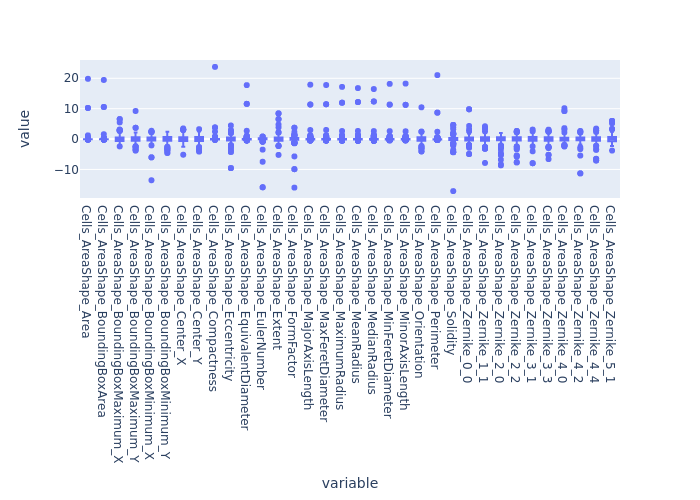

In [31]:
fig = px.box(df_normalized, y=cols_subset[:34], notched=True)
fig.show()

# Get profiles for all compounds in the extended metadata 

## Specify columns to read from extMetadata and parquet files

In [25]:
# extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022"]
# categoricalColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well"]

# print(' Ext Metadata Columns : ', extMetadataColumns)
# print(' Categorical columns  : ', categoricalColumns) 
# print(' Parquet Metadata Columns: ' ,ParquetColumns['Metadata'])

# ## all numeric columns 
# numeric_columns  =  ParquetColumns['Cells'] | ParquetColumns['Cytoplasm'] | ParquetColumns['Nuclei']
# print(f" all numeric columns: {len(numeric_columns)}")
 
# ## Remove numeric columns that contains bad values
# for x in ['Cells_AreaShape_FormFactor', 'Cytoplasm_AreaShape_FormFactor', 'Nuclei_AreaShape_FormFactor']:
#     del numeric_columns[x]
# print(f" all numeric columns after removal of FormFactor Columns : {len(numeric_columns)}")


# ## Conversion dictionary for reading CSV files 
# conversionDict = dict()
# for k,v in numeric_columns.items():
#     conversionDict[k] = np.float32

# print(f" conversion dict length: {len(conversionDict)}")

# conversionDict |= {x:'category'  for x in categoricalColumns}
# print(f" conversion dict length (after addition of Categorical columns): {len(conversionDict)}")

# ## get_column list for fields to read from Parquet files 
# get_columns = list(ParquetColumns['Metadata'] | numeric_columns)
# print(f" all get_columns    : {len(get_columns)}")
# # print(get_columns[:20])

# ## join Columns 
# join_columns = extMetadataColumns + list(numeric_columns)
# print(f" all columns in join: {len(join_columns)}")


## Load Extended metadata and group

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

In [119]:
ext_metadata.info()
ext_metadata.head(2)
ext_metadata.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231342 entries, 0 to 231341
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Metadata_Source     231342 non-null  object 
 1   Metadata_Batch      231342 non-null  object 
 2   Metadata_Plate      231342 non-null  object 
 3   Metadata_Well       231342 non-null  object 
 4   Metadata_JCP2022    231342 non-null  object 
 5   Metadata_TPSA       231342 non-null  float64
 6   Metadata_lnTPSA     231342 non-null  float64
 7   Metadata_log10TPSA  231342 non-null  float64
dtypes: float64(3), object(5)
memory usage: 14.1+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
231340,source_9,20211103-Run16,GR00004421,Z16,JCP2022_075595,69.97,4.248067,1.844912
231341,source_9,20211103-Run16,GR00004421,Z18,JCP2022_073861,95.44,4.558498,1.979730


In [120]:
ext_metadata.memory_usage(deep=True) 

Index                      128
Metadata_Source       15078430
Metadata_Batch        17257228
Metadata_Plate        15525892
Metadata_Well         13892096
Metadata_JCP2022      16425282
Metadata_TPSA          1850736
Metadata_lnTPSA        1850736
Metadata_log10TPSA     1850736
dtype: int64

## Group Extended metadata by Source/Batch/Plate

In [123]:
grouped_metadata = ext_metadata.groupby(by = ['Metadata_Source','Metadata_Batch','Metadata_Plate'])
len(grouped_metadata)
for ctr, (keys, group_data) in enumerate(grouped_metadata):
    print(f"{ctr:5d}     {keys}") 
    # print(group_data.info())
    if ctr > 2:
        break
print(group_data.info())


1684

    0     ('source_1', 'Batch1_20221004', 'UL001641')
    1     ('source_1', 'Batch1_20221004', 'UL001643')
    2     ('source_1', 'Batch1_20221004', 'UL001645')
    3     ('source_1', 'Batch1_20221004', 'UL001651')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 627 entries, 1851 to 2477
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Metadata_Source     627 non-null    object 
 1   Metadata_Batch      627 non-null    object 
 2   Metadata_Plate      627 non-null    object 
 3   Metadata_Well       627 non-null    object 
 4   Metadata_JCP2022    627 non-null    object 
 5   Metadata_TPSA       627 non-null    float64
 6   Metadata_lnTPSA     627 non-null    float64
 7   Metadata_log10TPSA  627 non-null    float64
dtypes: float64(3), object(5)
memory usage: 44.1+ KB
None


## Read profiles for each plate in extended metadata

###  Setup output file

In [128]:
# outputFile = open('./output_11102023/compound_profiles_2samples.npy', mode = 'ab')
outputFile = CompoundProfiles2SampleFileCSV+'.'+type_bz2

print(f" Write  to output {CompoundProfiles2SampleFileCSV}")
print(f" Write  to output {outputFile}")
print()

 Write  to output ./output_11102023/compound_profiles_2samples.csv
 Write  to output ./output_11102023/compound_profiles_2samples.csv.bz2



In [129]:
df_profiles_list = []
chunk = 0
rows = 0
ttl_rows = 0
write_break = 40000
write_header = True

for i, (keys, group_data) in enumerate(grouped_metadata):
    
    df_profile = read_profiles_from_local(keys, local_formatter, get_columns)
    df_join = pd.merge(group_data, df_profile, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])
    
    try:
        df_normalized = normalize(
            profiles=df_join,
            features="infer",
            meta_features="infer",
            samples="all",
            method="standardize",
        )
    except Exception as e:
        print(f" exception:  {e} occurred at {keys}")
        break
        
    df_profiles_list.append(df_normalized)
    
    rows += len(df_normalized)
    ttl_rows += len(df_normalized)
    
    print(f"file ctr: {i:5d}  df_normalized: {len(df_normalized)}    rows: {rows}   Total rows {ttl_rows}")
    
    if rows > write_break:
        df_profiles = pd.concat(df_profiles_list)
        chunk += 1
        print(f" Chunk {chunk:5d} - after group {i:5d} - Write {rows:5d}  profiles  to:{outputFile}")
        df_profiles.to_csv(outputFile, mode = 'a', index = False, header = write_header)
        write_header = False
        rows = 0
        df_profiles_list = []
 
        
if rows > 0:
    df_profiles = pd.concat(df_profiles_list)
    chunk += 1
    print(f" Chunk {chunk:5d} - after group {i:5d} - Write {rows:5d}  profiles  to: {outputFile}")
    df_profiles.to_csv(outputFile, mode = 'a', index = False, header = False)

print(f"----------------------------------------------------------------------------------------------------")
print(f" number of :  groups: {i}   file chunks : {chunk}    rows: {rows}   total number of rows: {ttl_rows}")
print(f"----------------------------------------------------------------------------------------------------")


file ctr:     0  df_normalized: 608    rows: 608   Total rows 608
file ctr:     1  df_normalized: 626    rows: 1234   Total rows 1234
file ctr:     2  df_normalized: 617    rows: 1851   Total rows 1851
file ctr:     3  df_normalized: 627    rows: 2478   Total rows 2478
file ctr:     4  df_normalized: 634    rows: 3112   Total rows 3112
file ctr:     5  df_normalized: 581    rows: 3693   Total rows 3693
file ctr:     6  df_normalized: 637    rows: 4330   Total rows 4330
file ctr:     7  df_normalized: 570    rows: 4900   Total rows 4900
file ctr:     8  df_normalized: 570    rows: 5470   Total rows 5470
file ctr:     9  df_normalized: 569    rows: 6039   Total rows 6039
file ctr:    10  df_normalized: 634    rows: 6673   Total rows 6673
file ctr:    11  df_normalized: 631    rows: 7304   Total rows 7304
file ctr:    12  df_normalized: 217    rows: 7521   Total rows 7521
file ctr:    13  df_normalized: 577    rows: 8098   Total rows 8098
file ctr:    14  df_normalized: 349    rows: 8447 

/home/kbardool/miniconda3/envs/cellpainting/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning:

invalid value encountered in divide

/home/kbardool/miniconda3/envs/cellpainting/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning:

invalid value encountered in divide

/home/kbardool/miniconda3/envs/cellpainting/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning:

invalid value encountered in divide



file ctr:   349  df_normalized: 90    rows: 21631   Total rows 61727
file ctr:   350  df_normalized: 100    rows: 21731   Total rows 61827
file ctr:   351  df_normalized: 103    rows: 21834   Total rows 61930
file ctr:   352  df_normalized: 79    rows: 21913   Total rows 62009
file ctr:   353  df_normalized: 94    rows: 22007   Total rows 62103
file ctr:   354  df_normalized: 98    rows: 22105   Total rows 62201
file ctr:   355  df_normalized: 102    rows: 22207   Total rows 62303
file ctr:   356  df_normalized: 119    rows: 22326   Total rows 62422
file ctr:   357  df_normalized: 113    rows: 22439   Total rows 62535
file ctr:   358  df_normalized: 120    rows: 22559   Total rows 62655
file ctr:   359  df_normalized: 111    rows: 22670   Total rows 62766
file ctr:   360  df_normalized: 110    rows: 22780   Total rows 62876
file ctr:   361  df_normalized: 88    rows: 22868   Total rows 62964
file ctr:   362  df_normalized: 84    rows: 22952   Total rows 63048
file ctr:   363  df_normal

In [614]:
# df_profiles.Metadata_Source = df_profiles.Metadata_Source.astype(str)

In [130]:
df_profiles.head(5)
df_profiles.memory_usage(deep=True).sum()
df_profiles.memory_usage(deep=True)[:100]
df_profiles.info(verbose = True)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_9,20210825_Run6,GR00003390,A04,JCP2022_041403,97.58,4.580673,1.989361,-0.121175,-0.136879,...,-0.153354,-0.149321,-0.154499,-0.158401,-0.146179,-0.156690,-0.156330,-0.161795,-0.148313,-0.161426
1,source_9,20210825_Run6,GR00003390,A07,JCP2022_007767,63.22,4.146621,1.800854,-0.138583,-0.153343,...,-0.249229,-0.259805,-0.252330,-0.255025,-0.251581,-0.253431,-0.254107,-0.252585,-0.252768,-0.255744
2,source_9,20210825_Run6,GR00003390,A08,JCP2022_024727,59.06,4.078554,1.771293,-0.145794,-0.162286,...,-0.249153,-0.239931,-0.258369,-0.259756,-0.260284,-0.262426,-0.261763,-0.258861,-0.260889,-0.259116
3,source_9,20210825_Run6,GR00003390,A14,JCP2022_001948,96.86,4.573267,1.986144,-0.172216,-0.182128,...,-0.239278,-0.250152,-0.247137,-0.247808,-0.247069,-0.246845,-0.244656,-0.243576,-0.244448,-0.244385
4,source_9,20210825_Run6,GR00003390,A18,JCP2022_056489,96.50,4.569543,1.984527,-0.109767,-0.095772,...,-0.284303,-0.283289,-0.281921,-0.282208,-0.279503,-0.282746,-0.279508,-0.279460,-0.282067,-0.281911


923611234

Index                                  248568
Metadata_Source                       2019615
Metadata_Batch                        2194866
Metadata_Plate                        2081757
Metadata_Well                         1870123
                                       ...   
Cells_Correlation_Manders_AGP_Mito     248568
Cells_Correlation_Manders_AGP_RNA      248568
Cells_Correlation_Manders_DNA_AGP      248568
Cells_Correlation_Manders_DNA_ER       248568
Cells_Correlation_Manders_DNA_Mito     248568
Length: 100, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31071 entries, 0 to 243
Data columns (total 3678 columns):
 #     Column                                                        Dtype  
---    ------                                                        -----  
 0     Metadata_Source                                               object 
 1     Metadata_Batch                                                object 
 2     Metadata_Plate                                                object 
 3     Metadata_Well                                                 object 
 4     Metadata_JCP2022                                              object 
 5     Metadata_TPSA                                                 float64
 6     Metadata_lnTPSA                                               float64
 7     Metadata_log10TPSA                                            float64
 8     Cells_AreaShape_Area                                          float64
 9     Cells_AreaShape_BoundingBoxArea      

In [ ]:
# df_profiles.Metadata_Source = df_profiles.Metadata_Source.astype(np.string_)
# df_profiles.Metadata_Batch = df_profiles.Metadata_Batch.astype(np.string_)
# df_profiles.Metadata_Source.dtype
# df_profiles.Metadata_Batch.dtype
# df_profiles.head(10)
# df_profiles.memory_usage(deep=True)[:10]

In [132]:
del df_profiles

# Read Normalized Compound/Profiles table

In [139]:
profilesFile = CompoundProfiles2SampleFileCSV +'.'+ type_bz2
# oldOutputFile ='./output_11102023/compound_profiles_2samples_old2.csv.bz2'
# del df_profiles_list 
print(f" Read from {profilesFile}")
nrows = 5000

 Read from ./output_11102023/compound_profiles_2samples.csv.bz2


In [45]:
df_profiles =  pd.read_csv(profilesFile, 
                           nrows = 20000,
                           skiprows = 20000, 
                           header = 0, 
                           names = join_columns,
                           dtype = conversionDict,
                           usecols = ['Metadata_JCP2022','Cells_AreaShape_Area'])
df_profiles.columns
df_profiles.loc[0]
df_profiles.memory_usage(deep=True).sum()
df_profiles.memory_usage(deep=True)[:20]
df_profiles.head(5)
df_profiles.info(verbose=True)

Index(['Metadata_JCP2022', 'Cells_AreaShape_Area'], dtype='object')

Metadata_JCP2022              JCP2022_002416
Cells_AreaShape_Area    -0.10364100951446817
Name: 0, dtype: object

36797

Index                     128
Metadata_JCP2022        17752
Cells_AreaShape_Area    18917
dtype: int64

,Metadata_JCP2022,Cells_AreaShape_Area
0,JCP2022_002416,-0.10364100951446817
1,JCP2022_067802,0.2909296155289947
2,JCP2022_080082,0.28737492521328745
3,Metadata_JCP2022,Cells_AreaShape_Area
4,JCP2022_066344,0.1530516045343132


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Metadata_JCP2022      250 non-null    object
 1   Cells_AreaShape_Area  250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [142]:
df_iter =  pd.read_csv(profilesFile, 
                       low_memory = True, 
                       chunksize= 15000,  
                       # skiprows=30000, 
                       iterator = True, 
                       dtype = conversionDict,
                       usecols = join_columns)

In [143]:
for i, df_profiles in enumerate(df_iter):
    print(f" Chunk {i}   Starting index : {df_profiles.index[0]}   Ending Index {df_profiles.index[-1]}")
    print(f" Number of rows {df_profiles.shape[0]}   Size of chunk read: {df_profiles.memory_usage(deep=True).sum():,d} bytes")
    inv_cols = check_values(df_profiles,  numeric_columns)
    print("-"*150,'\n')
    # if i >= 0 :
    #     break

 Chunk 0   Starting index : 0   Ending Index 14999
 Number of rows 15000   Size of chunk read: 221,813,649 bytes

 Columns with invalid data from 3670 columns         min           max           std          mean        median                         quantile                     
 **** No Invalid Numeric Columns Found ****
------------------------------------------------------------------------------------------------------------------------------------------------------ 

 Chunk 1   Starting index : 15000   Ending Index 29999
 Number of rows 15000   Size of chunk read: 221,819,138 bytes

 Columns with invalid data from 3670 columns         min           max           std          mean        median                         quantile                     
 **** No Invalid Numeric Columns Found ****
------------------------------------------------------------------------------------------------------------------------------------------------------ 

 Chunk 2   Starting index : 30000   Endi

In [144]:
# df_profiles.shape
# df_profiles.head(2)
# df_profiles.tail(2)
# df_profiles.info()
# print(f" Chunk {i}   Starting index : {df_profiles.index[0]}   Ending Index {df_profiles.index[-1]}")
# print(f" Number of rows {df_profiles.shape[0]}   Size of chunk read: {df_profiles.memory_usage(deep=True).sum():,} bytes")
# df_profiles.index[0], df_profiles.index[-1]
# # inv_cols = check_values(df_profiles,  numeric_columns)

In [145]:
# del df_profiles

In [146]:
# cols = cat_columns(df_profiles)

# Step 5 - Apply feature selection

In this step, we apply a series of feature selection steps to **level 4a profiles** (normalized well-level profiles) to form **level 4b profiles**.

#### `feature_select()` documentation

`feature_select()` Parameters

-   **profiles :** `pandas.core.frame.DataFrame` or file\
        DataFrame or file of profiles.
-   **features :** list\
        A list of strings corresponding to feature measurement column names in the `profiles` DataFrame.\
        All features listed must be found in `profiles`.\
        Defaults to `"infer"`. If `"infer"`, then assume cell painting features are those prefixed with `"Cells"`, `"Nuclei"`, or `"Cytoplasm"`.
-    **image_features:** bool, default False\
        Whether the profiles contain image features.
-    **samples :** list or str, default "all"\
        Samples to provide operation on.
-    **operation:** list of str or str, default "variance_threshold"\
        Operations to perform on the input profiles.\
     **Supported operations**
     -  **variance_threshold:** Exclude features that have low variance (low information content)
        - **freq_cut :** float, default 0.05 - Ratio (2nd most common feature val / most common). Must range between 0 and 1.
        - **unique_cut :** float, default 0.01 - Ratio (num unique features / num samples). Must range between 0 and 1.
     -  **correlation_threshold:** Exclude features that have correlations above a certain threshold
        - **threshold :** float, default 0.9 -  Must be between (0, 1) to exclude feature
        - **method :**  `pearson`, `spearman`, `kendall`, default `pearson` - indicating which correlation metric to use to test cutoff
     -  **blocklist:** Exclude features
     -  **drop_outliers:** Exclude a feature if its min or max absolute value is greater than the threshold.
     -  **noise_removal:** Remove noisy features, as defined by features with excessive standard deviation within the same perturbation group.
        - **noise_removal_perturb_groups :**
        - **noise_removal_stdev_cutoff :**
     -  **drop_na_columns:**  Get features that have more NA values than cutoff defined
        - **outlier_cutoff :**
-    **output_file :** str, optional\
        If provided, will write feature selected profiles to file. If not specified, will return the feature selected profiles as output.
        We recommend that this output file be suffixed with "_normalized_variable_selected.csv".
-    **output_type :** str, optional\
        If provided, will write feature selected profiles as a specified file type (either CSV or parquet).
        If not specified and output_file is provided, then the file will be outputed as CSV as default.
-    **na_cutoff :** float, default 0.05\
        Proportion of missing values in a column to tolerate before removing.
-    **corr_threshold :** float, default 0.9\
        Value between (0, 1) to exclude features above if any two features are correlated above this threshold.
-    **corr_method :** str, default `pearson`\
        Correlation type to compute. Allowed methods are `spearman`, `kendall` and `pearson`.
-    **freq_cut :** float, default 0.05\
        Ratio (2nd most common feature val / most common). Must range between 0 and 1.
        Remove features lower than freq_cut. A low freq_cut will remove features
        that have large difference between the most common feature and second most
        common feature. (e.g. this will remove a feature: [1, 1, 1, 1, 0.01, 0.01, ...])
-    **unique_cut:** float, default 0.01\
        Ratio (num unique features / num samples). Must range between 0 and 1.
        Remove features less than unique cut. A low unique_cut will remove features
        that have very few different measurements compared to the number of samples.
-    **compression_options :** str or dict, optional\
        Contains compression options as input to
        pd.DataFrame.to_csv(compression=compression_options). pandas version >= 1.2.
-    **float_format :** str, optional\
        Decimal precision to use in writing output file as input to
        pd.DataFrame.to_csv(float_format=float_format). For example, use "%.3g" for 3
        decimal precision.
-    **blocklist_file :** str, optional\
        File location of datafrmame with with features to exclude. Note that if "blocklist" in operation then will remove standard blocklist
-    **outlier_cutoff :** float, default 500\
        The threshold at which the maximum or minimum value of a feature across a full experiment is excluded. Note that this procedure is typically applied after normalization.
-    **noise_removal_perturb_groups:** str or list of str, optional\
        Perturbation groups corresponding to rows in profiles or the the name of the metadata column containing this information.
-    **noise_removal_stdev_cutoff:** float,optional\
        Maximum mean feature standard deviation to be kept for noise removal, grouped by the identity of the perturbation from perturb_list. The data must already be normalized so that this cutoff can apply to all columns.

**Returns**

-  **selected_df :** `pandas.core.frame.DataFrame`, optional \
    The feature selected profile DataFrame.
    If output_file=None, then return the DataFrame.
    If you specify output_file, then write to file and do not return data.

#### Code

In [59]:
# Apply feature selection
profilesFile = CompoundProfiles2SampleFileCSV +'.'+ type_bz2
featureSelectionFile = './output_11102023//normalized_feature_select.csv'
# featureSelectionFile = pathlib.Path(f"{output_dir}/{plate_id}_normalized_feature_select.csv.gz")
print(f" Profiles file       :  {profilesFile}")
print(f" Features select file:  {featureSelectionFile}")

 Profiles file       :  ./output_11102023/compound_profiles_2samples.csv.bz2
 Features select file:  ./output_11102023//normalized_feature_select.csv


**Pick columns we want to analyse**

In [60]:
for grp in cell_fld_grps:
# for grp in cytoplasm_fld_grps:
# for grp in nuclei_fld_grps:
    tmpColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(tmpColumns)}")


 Cells_AreaShape                               53
 Cells_Children                                1
 Cells_Correlation                             80
 Cells_Granularity                             80
 Cells_Intensity                               75
 Cells_Neighbors                               14
 Cells_Parent                                  1
 Cells_RadialDistribution                      171
 Cells_Texture                                 780
 Cells_Texture_AngularSecondMoment             60
 Cells_Texture_Contrast                        60
 Cells_Texture_Correlation                     60
 Cells_Texture_DifferenceEntropy               60
 Cells_Texture_DifferenceVariance              60
 Cells_Texture_Entropy                         60
 Cells_Texture_InfoMeas1                       60
 Cells_Texture_InfoMeas2                       60
 Cells_Texture_InverseDifferenceMoment         60
 Cells_Texture_SumAverage                      60
 Cells_Texture_SumEntropy                      60


In [61]:
# featureColumns_1 = get_cols_like(numeric_columns, ['Cells_AreaShape', 'Cells_Correlation', 'Cells_Granularity',
                                                   # 'Cells_Intensity', 'Cells_Children', 'Cells_Neighbors', 'Cells_Parent'])

# featureColumns_2 = get_cols_like(numeric_columns, ['Cells_RadialDistribution', 'Cells_RadialDistribution_FracAtD', 
                                                   # 'Cells_RadialDistribution_MeanFrac', 'Cells_RadialDistribution_RadialCV'])

# featureColumns_3 = get_cols_like(numeric_columns, ['Cells_Texture_AngularSecondMoment', 'Cells_Texture_Contrast', 'Cells_Texture_Correlation',
                                                   # 'Cells_Texture_DifferenceEntropy', 'Cells_Texture_DifferenceVariance', 'Cells_Texture_Entropy'])

# featureColumns_4 = get_cols_like(numeric_columns, ['Cells_Texture_InfoMeas1' , 'Cells_Texture_InfoMeas2' , 'Cells_Texture_InverseDifferenceMoment',
                                                   # 'Cells_Texture_SumAverage', 'Cells_Texture_SumEntropy', 'Cells_Texture_SumVariance',  'Cells_Texture_Variance' ])

# featureColumns_1 = get_cols_like(numeric_columns, ['Cells_AreaShape', 'Cells_Correlation', 'Cells_Granularity', 'Cells_Intensity', 
#                                                    'Cells_Children', 'Cells_Neighbors', 'Cells_Parent', 'Cells_RadialDistribution'])

featureColumns_2 = get_cols_like(numeric_columns, ['Cells_Texture'])


# featureColumns_5 = get_cols_like(numeric_columns, ['Cytoplasm_Number',  'Cytoplasm_Intensity', 'Cytoplasm_RadialDistribution',
#                                                    'Cytoplasm_Granularity',  'Cytoplasm_Correlation', 'Cytoplasm_AreaShape'])

# featureColumns_6 = get_cols_like(numeric_columns, ['Cytoplasm_Texture'])

# featureColumns_7 = get_cols_like(numeric_columns, ['Nuclei_Location'   , 'Nuclei_Neighbors'  , 'Nuclei_ObjectSkeleton', 'Nuclei_Parent',
#                                                    'Nuclei_Number'     , 'Nuclei_Intensity'  , 'Nuclei_Children'      , 'Nuclei_RadialDistribution',
#                                                    'Nuclei_Granularity', 'Nuclei_Correlation', 'Nuclei_AreaShape'     ,])

# featureColumns_8 = get_cols_like(numeric_columns, ['Nuclei_Texture'])

len(featureColumns_2)
# useColumns

780

In [62]:
extMetadataNames
readColumns =  extMetadataNames+ featureColumns_2
print(len(featureColumns_2))
len(readColumns)

['Metadata_Source',
 'Metadata_Batch',
 'Metadata_Plate',
 'Metadata_Well',
 'Metadata_JCP2022',
 'Metadata_TPSA',
 'Metadata_lnTPSA',
 'Metadata_log10TPSA']

780


788

In [63]:
for i in readColumns:
    if i not in conversionDict:
        print(f" {i} not in conversionDict")

 Metadata_JCP2022 not in conversionDict
 Metadata_TPSA not in conversionDict
 Metadata_lnTPSA not in conversionDict
 Metadata_log10TPSA not in conversionDict


In [64]:
df_profiles =  pd.read_csv(profilesFile, 
                       low_memory = True, 
                       # chunksize= 15000,  
                       # skiprows=30000, 
                       # iterator = True, 
                       dtype = conversionDict,
                       usecols = readColumns)

In [65]:
df_profiles.shape
print(f"\nSize of loaded dataframe: {df_profiles.memory_usage(deep=True).sum():,d}\n")
df_profiles.info()
df_profiles.head(3)
df_profiles_columns = df_profiles.columns.to_list()

(231342, 788)


Size of loaded dataframe: 745,465,468

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231342 entries, 0 to 231341
Columns: 788 entries, Metadata_Source to Cells_Texture_Variance_RNA_5_03_256
dtypes: category(4), float32(780), float64(3), object(1)
memory usage: 696.9+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_Texture_AngularSecondMoment_AGP_10_00_256,Cells_Texture_AngularSecondMoment_AGP_10_01_256,...,Cells_Texture_Variance_RNA_10_02_256,Cells_Texture_Variance_RNA_10_03_256,Cells_Texture_Variance_RNA_3_00_256,Cells_Texture_Variance_RNA_3_01_256,Cells_Texture_Variance_RNA_3_02_256,Cells_Texture_Variance_RNA_3_03_256,Cells_Texture_Variance_RNA_5_00_256,Cells_Texture_Variance_RNA_5_01_256,Cells_Texture_Variance_RNA_5_02_256,Cells_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,-0.187201,-0.173379,...,-0.051998,-0.057081,-0.039670,-0.045675,-0.038224,-0.038643,-0.049692,-0.044698,-0.049279,-0.046397
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.108262,-0.104001,...,-0.539813,-0.532339,-0.536878,-0.535471,-0.535379,-0.537669,-0.539228,-0.533155,-0.539169,-0.537161
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.108262,-0.104001,...,-0.539813,-0.532339,-0.536878,-0.535471,-0.535379,-0.537669,-0.539228,-0.533155,-0.539169,-0.537161


In [66]:
len(readColumns), len(df_profiles_columns)
# set(readColumns) - set(df_profiles_columns)


(788, 788)

#### Run feature selection

In [83]:
feature_select_opts = [
    "variance_threshold",
    # "correlation_threshold",
    # "drop_na_columns",
    # "blocklist",
    # "drop_outliers"
]
compression_options = {'method':' bz2'}

In [84]:
df_feature_selection = feature_select(
                               profiles=df_profiles,
                               features="infer",
                               samples="all",
                               corr_threshold=0.95,
                               freq_cut = 0.05,
                               unique_cut = 0.01,
                               operation=feature_select_opts,
                               # output_file=featureSelectionFile,
                               compression_options=compression_options,
                              )

In [85]:
# Read in and preview what was output in the previous step 
# df_feature_selection= pd.read_csv(feature_select_file)
# df_feature_selection.columns.to_list()[:10]
# print(df_feature_selection.shape)

selected_cols = df_feature_selection.columns.to_list()
dropped_cols = set(readColumns) - set(selected_cols)

print(f" Read columns:     {len(readColumns)}")
print(f" Selected columns: {len(selected_cols)}")
print(f" Dropped columns:  {len(dropped_cols)}")

 Read columns:     788
 Selected columns: 788
 Dropped columns:  0


In [86]:
dropped_cols = sorted(list(dropped_cols))
print(len(dropped_cols))

tmp_cols = ["\""+x+"\"" for x in dropped_cols ]
len_tmp_cols = len(tmp_cols)

for i in range(0,len_tmp_cols,4):
    for j in range(i,i+4,1):
        if j < len_tmp_cols:
            print(f" {tmp_cols[j]:60s} " , end = ',')
        else:
            break
    print()

0


In [87]:
print('\n')
print(len(selected_cols))

tmp_cols = ["\""+x+"\"" for x in selected_cols ]
len_tmp_cols = len(tmp_cols)

for i in range(0,len_tmp_cols,4):
    for j in range(i,i+4,1):
        if j < len_tmp_cols:
            print(f" {tmp_cols[j]:60s} " , end = ',')
        else:
            break
    print()




788
 "Metadata_Source"                                            , "Metadata_Batch"                                             , "Metadata_Plate"                                             , "Metadata_Well"                                              ,
 "Metadata_JCP2022"                                           , "Metadata_TPSA"                                              , "Metadata_lnTPSA"                                            , "Metadata_log10TPSA"                                         ,
 "Cells_Texture_AngularSecondMoment_AGP_10_00_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_01_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_02_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_03_256"            ,
 "Cells_Texture_AngularSecondMoment_AGP_3_00_256"             , "Cells_Texture_AngularSecondMoment_AGP_3_01_256"             , "Cells_Texture_AngularSecondMoment_AGP_3_02_256"             , "Cells_Texture_AngularSecondMoment_AGP_3_03_2

In [116]:
# disp_stats(df_profiles, selected_cols[8:])

In [146]:
# disp_stats(df_profiles, dropped_cols)
# print('\n\n')
# df_feature_selection.Metadata_clone_number.value_counts()
# df_feature_selection.sort_values(["Metadata_clone_number", "Metadata_treatment"], inplace=True)

In [282]:
# n = df_profiles.shape[0]
# print(n)
# for drop_col in dropped_columns:
#     n_unique = df_profiles[drop_col].nunique()
#     v_counts = df_profiles[drop_col].value_counts()
#     print(f"     {drop_col:50s}:    {n_unique:15d}     unique ratio: {n_unique/n:.3f}")
#     print(v_counts.head(10))

In [283]:
df_feature_selection.head(10)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_RadialDistribution_FracAtD_AGP_2of4,Cells_RadialDistribution_FracAtD_AGP_3of4,...,Cells_RadialDistribution_RadialCV_mito_tubeness_3of20,Cells_RadialDistribution_RadialCV_mito_tubeness_4of16,Cells_RadialDistribution_RadialCV_mito_tubeness_4of20,Cells_RadialDistribution_RadialCV_mito_tubeness_5of16,Cells_RadialDistribution_RadialCV_mito_tubeness_7of16,Cells_RadialDistribution_RadialCV_mito_tubeness_7of20,Cells_RadialDistribution_RadialCV_mito_tubeness_8of16,Cells_RadialDistribution_RadialCV_mito_tubeness_8of20,Cells_RadialDistribution_RadialCV_mito_tubeness_9of16,Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,-0.091552,-1.213757,...,0.071114,0.096593,0.039908,-0.207430,-0.313511,-0.954389,-0.397926,-0.797392,0.265889,0.0
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.236771,-0.634845,...,0.016265,0.258543,0.231367,0.812633,-0.772362,0.012184,-0.409832,-0.700510,0.344720,0.0
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.236771,-0.634845,...,0.016265,0.258543,0.231367,0.812633,-0.772362,0.012184,-0.409832,-0.700510,0.344720,0.0
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.391403,-0.931852,...,-0.977264,-0.599298,-1.131996,-0.456438,-0.444961,-0.554931,-0.633076,-0.478199,0.210415,0.0
4,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.391403,-0.931852,...,-0.977264,-0.599298,-1.131996,-0.456438,-0.444961,-0.554931,-0.633076,-0.478199,0.210415,0.0
5,source_1,Batch1_20221004,UL001641,A14,JCP2022_070487,52.71,3.964805,1.721893,0.150481,-0.579471,...,0.746764,1.336570,1.160507,1.245523,0.466015,1.197661,0.703412,0.779744,1.655647,0.0
6,source_1,Batch1_20221004,UL001641,A15,JCP2022_070236,31.60,3.453157,1.499687,-0.418296,-0.969607,...,0.192656,-0.420009,-0.221940,-0.633007,-0.677290,-1.006315,0.313479,-0.771880,0.262969,0.0
7,source_1,Batch1_20221004,UL001641,A15,JCP2022_070236,31.60,3.453157,1.499687,-0.418296,-0.969607,...,0.192656,-0.420009,-0.221940,-0.633007,-0.677290,-1.006315,0.313479,-0.771880,0.262969,0.0
8,source_1,Batch1_20221004,UL001641,A16,JCP2022_072313,91.67,4.518195,1.962227,0.106108,-0.813553,...,-0.417235,-1.320382,-1.230228,-0.975001,-0.793455,-0.930632,-0.493176,-1.279674,-0.050602,0.0
9,source_1,Batch1_20221004,UL001641,A21,JCP2022_050822,68.86,4.232075,1.837967,0.003917,-0.123892,...,-1.721475,-1.205873,-1.810862,-0.203250,-0.530556,-0.122213,-0.555685,-0.391643,0.099468,0.0


Feature Selection drops :
- `Cells` features dropped : 1080,  Retained: 98 
- `Cytoplasm` features dropped : 1007, Retained: 154
- `Nuclei` feature dropped : 1049, Retained: 138


#### group 1

In [104]:

# correlation_dropped_cols_1 = \
# {'Cells_Intensity_StdIntensity_Mito', 'Cells_Intensity_MedianIntensity_ER', 'Cells_Intensity_MeanIntensityEdge_RNA', 'Cells_Intensity_MaxIntensityEdge_RNA', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_Neighbors_SecondClosestDistance_Adjacent',
#  'Cells_AreaShape_BoundingBoxArea', 'Cells_Intensity_MaxIntensityEdge_AGP', 'Cells_Intensity_LowerQuartileIntensity_Mito', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Intensity_MeanIntensityEdge_Mito', 'Cells_Intensity_MinIntensity_RNA',
#  'Cells_Intensity_LowerQuartileIntensity_RNA', 'Cells_AreaShape_MinFeretDiameter', 'Cells_Intensity_LowerQuartileIntensity_AGP', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_Intensity_MedianIntensity_RNA', 'Cells_AreaShape_MinorAxisLength', 
#  'Cells_Intensity_MeanIntensity_Mito', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Intensity_UpperQuartileIntensity_Mito', 'Cells_Intensity_MinIntensityEdge_AGP', 'Cells_Intensity_MedianIntensity_AGP', 'Cells_Correlation_Manders_ER_Mito',
#  'Cells_Neighbors_PercentTouching_Adjacent', 'Cells_Neighbors_FirstClosestDistance_Adjacent', 'Cells_Neighbors_FirstClosestObjectNumber_5', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_Correlation_Correlation_AGP_RNA', 
#  'Cells_Neighbors_NumberOfNeighbors_5', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Area', 'Cells_Intensity_StdIntensityEdge_Mito', 'Cells_Intensity_MeanIntensityEdge_ER', 'Cells_Intensity_StdIntensity_AGP', 'Cells_AreaShape_MaximumRadius', 
#  'Cells_Parent_CellsIncludingEdges', 'Cells_Correlation_Correlation_AGP_ER', 'Cells_Neighbors_PercentTouching_5', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_EquivalentDiameter', 'Cells_Intensity_UpperQuartileIntensity_AGP', 
#  'Cells_Neighbors_SecondClosestObjectNumber_5', 'Cells_Intensity_UpperQuartileIntensity_ER', 'Cells_Intensity_MinIntensityEdge_DNA', 'Cells_Intensity_MinIntensityEdge_Mito', 'Cells_AreaShape_MajorAxisLength', 
#  'Cells_Neighbors_SecondClosestDistance_5', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_Intensity_MeanIntensityEdge_AGP', 'Cells_Intensity_StdIntensityEdge_DNA', 'Cells_AreaShape_BoundingBoxMinimum_X', 
#  'Cells_Intensity_MADIntensity_Mito', 'Cells_Intensity_UpperQuartileIntensity_RNA', 'Cells_Intensity_StdIntensityEdge_ER', 'Cells_Intensity_MinIntensity_ER', 'Cells_Neighbors_AngleBetweenNeighbors_Adjacent', 
#  'Cells_Intensity_MedianIntensity_Mito', 'Cells_Intensity_MassDisplacement_RNA', 'Cells_Granularity_1_RNA'}
variance_dropped_cols_1 = set()

# { 
#  "Cells_Children_Cytoplasm_Count"                             , "Cells_Neighbors_SecondClosestObjectNumber_5"                , "Cells_Neighbors_SecondClosestObjectNumber_Adjacent"         , "Cells_Parent_CellsIncludingEdges"                           ,
#  "Cells_RadialDistribution_FracAtD_mito_tubeness_Overflow"    , "Cells_RadialDistribution_MeanFrac_mito_tubeness_Overflow"   , "Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow" }

selected_cols_1 = \
{"Cells_AreaShape_BoundingBoxMaximum_X"                       , "Cells_AreaShape_Center_X"                                   , "Cells_AreaShape_Center_Y"                                   , "Cells_AreaShape_Compactness"                                ,
 "Cells_AreaShape_Eccentricity"                               , "Cells_AreaShape_EulerNumber"                                , "Cells_AreaShape_Extent"                                     , "Cells_AreaShape_MajorAxisLength"                            ,
 "Cells_AreaShape_MedianRadius"                               , "Cells_AreaShape_MinorAxisLength"                            , "Cells_AreaShape_Orientation"                                , "Cells_AreaShape_Perimeter"                                  ,
 "Cells_AreaShape_Solidity"                                   , "Cells_AreaShape_Zernike_0_0"                                , "Cells_AreaShape_Zernike_1_1"                                , "Cells_AreaShape_Zernike_2_0"                                ,
 "Cells_AreaShape_Zernike_2_2"                                , "Cells_AreaShape_Zernike_3_1"                                , "Cells_AreaShape_Zernike_3_3"                                , "Cells_AreaShape_Zernike_4_0"                                ,
 "Cells_AreaShape_Zernike_4_2"                                , "Cells_AreaShape_Zernike_4_4"                                , "Cells_AreaShape_Zernike_5_1"                                , "Cells_AreaShape_Zernike_5_3"                                ,
 "Cells_AreaShape_Zernike_5_5"                                , "Cells_AreaShape_Zernike_6_0"                                , "Cells_AreaShape_Zernike_6_2"                                , "Cells_AreaShape_Zernike_6_4"                                ,
 "Cells_AreaShape_Zernike_6_6"                                , "Cells_AreaShape_Zernike_7_1"                                , "Cells_AreaShape_Zernike_7_3"                                , "Cells_AreaShape_Zernike_7_5"                                ,
 "Cells_AreaShape_Zernike_7_7"                                , "Cells_AreaShape_Zernike_8_0"                                , "Cells_AreaShape_Zernike_8_2"                                , "Cells_AreaShape_Zernike_8_4"                                ,
 "Cells_AreaShape_Zernike_8_6"                                , "Cells_AreaShape_Zernike_8_8"                                , "Cells_AreaShape_Zernike_9_1"                                , "Cells_AreaShape_Zernike_9_3"                                ,
 "Cells_AreaShape_Zernike_9_5"                                , "Cells_AreaShape_Zernike_9_7"                                , "Cells_AreaShape_Zernike_9_9"                                , "Cells_Children_Cytoplasm_Count"                             ,
 "Cells_Correlation_Correlation_AGP_DNA"                      , "Cells_Correlation_Correlation_AGP_ER"                       , "Cells_Correlation_Correlation_AGP_Mito"                     , "Cells_Correlation_Correlation_DNA_ER"                       ,
 "Cells_Correlation_Correlation_DNA_Mito"                     , "Cells_Correlation_Correlation_DNA_RNA"                      , "Cells_Correlation_Correlation_ER_Mito"                      , "Cells_Correlation_Correlation_ER_RNA"                       ,
 "Cells_Correlation_Correlation_Mito_RNA"                     , "Cells_Correlation_K_AGP_DNA"                                , "Cells_Correlation_K_AGP_ER"                                 , "Cells_Correlation_K_AGP_Mito"                               ,
 "Cells_Correlation_K_AGP_RNA"                                , "Cells_Correlation_K_DNA_AGP"                                , "Cells_Correlation_K_DNA_ER"                                 , "Cells_Correlation_K_DNA_Mito"                               ,
 "Cells_Correlation_K_DNA_RNA"                                , "Cells_Correlation_K_ER_AGP"                                 , "Cells_Correlation_K_ER_DNA"                                 , "Cells_Correlation_K_ER_Mito"                                ,
 "Cells_Correlation_K_ER_RNA"                                 , "Cells_Correlation_K_Mito_AGP"                               , "Cells_Correlation_K_Mito_DNA"                               , "Cells_Correlation_K_Mito_ER"                                ,
 "Cells_Correlation_K_Mito_RNA"                               , "Cells_Correlation_K_RNA_AGP"                                , "Cells_Correlation_K_RNA_DNA"                                , "Cells_Correlation_K_RNA_ER"                                 ,
 "Cells_Correlation_K_RNA_Mito"                               , "Cells_Correlation_Manders_AGP_DNA"                          , "Cells_Correlation_Manders_AGP_ER"                           , "Cells_Correlation_Manders_AGP_Mito"                         ,
 "Cells_Correlation_Manders_AGP_RNA"                          , "Cells_Correlation_Manders_DNA_AGP"                          , "Cells_Correlation_Manders_DNA_ER"                           , "Cells_Correlation_Manders_DNA_Mito"                         ,
 "Cells_Correlation_Manders_DNA_RNA"                          , "Cells_Correlation_Manders_ER_AGP"                           , "Cells_Correlation_Manders_ER_DNA"                           , "Cells_Correlation_Manders_ER_Mito"                          ,
 "Cells_Correlation_Manders_ER_RNA"                           , "Cells_Correlation_Manders_Mito_AGP"                         , "Cells_Correlation_Manders_Mito_DNA"                         , "Cells_Correlation_Manders_Mito_ER"                          ,
 "Cells_Correlation_Manders_Mito_RNA"                         , "Cells_Correlation_Manders_RNA_AGP"                          , "Cells_Correlation_Manders_RNA_DNA"                          , "Cells_Correlation_Manders_RNA_ER"                           ,
 "Cells_Correlation_Manders_RNA_Mito"                         , "Cells_Correlation_Overlap_AGP_DNA"                          , "Cells_Correlation_Overlap_AGP_ER"                           , "Cells_Correlation_Overlap_AGP_Mito"                         ,
 "Cells_Correlation_Overlap_AGP_RNA"                          , "Cells_Correlation_Overlap_DNA_ER"                           , "Cells_Correlation_Overlap_DNA_Mito"                         , "Cells_Correlation_Overlap_DNA_RNA"                          ,
 "Cells_Correlation_Overlap_ER_Mito"                          , "Cells_Correlation_Overlap_ER_RNA"                           , "Cells_Correlation_Overlap_Mito_RNA"                         , "Cells_Correlation_RWC_AGP_DNA"                              ,
 "Cells_Correlation_RWC_AGP_ER"                               , "Cells_Correlation_RWC_AGP_Mito"                             , "Cells_Correlation_RWC_AGP_RNA"                              , "Cells_Correlation_RWC_DNA_AGP"                              ,
 "Cells_Correlation_RWC_DNA_ER"                               , "Cells_Correlation_RWC_DNA_Mito"                             , "Cells_Correlation_RWC_DNA_RNA"                              , "Cells_Correlation_RWC_ER_AGP"                               ,
 "Cells_Correlation_RWC_ER_DNA"                               , "Cells_Correlation_RWC_ER_Mito"                              , "Cells_Correlation_RWC_ER_RNA"                               , "Cells_Correlation_RWC_Mito_AGP"                             ,
 "Cells_Correlation_RWC_Mito_DNA"                             , "Cells_Correlation_RWC_Mito_ER"                              , "Cells_Correlation_RWC_Mito_RNA"                             , "Cells_Correlation_RWC_RNA_AGP"                              ,
 "Cells_Correlation_RWC_RNA_DNA"                              , "Cells_Correlation_RWC_RNA_ER"                               , "Cells_Correlation_RWC_RNA_Mito"                             , "Cells_Granularity_10_AGP"                                   ,
 "Cells_Granularity_10_DNA"                                   , "Cells_Granularity_10_ER"                                    , "Cells_Granularity_10_Mito"                                  , "Cells_Granularity_10_RNA"                                   ,
 "Cells_Granularity_11_AGP"                                   , "Cells_Granularity_11_DNA"                                   , "Cells_Granularity_11_ER"                                    , "Cells_Granularity_11_Mito"                                  ,
 "Cells_Granularity_11_RNA"                                   , "Cells_Granularity_12_AGP"                                   , "Cells_Granularity_12_DNA"                                   , "Cells_Granularity_12_ER"                                    ,
 "Cells_Granularity_12_Mito"                                  , "Cells_Granularity_12_RNA"                                   , "Cells_Granularity_13_AGP"                                   , "Cells_Granularity_13_DNA"                                   ,
 "Cells_Granularity_13_ER"                                    , "Cells_Granularity_13_Mito"                                  , "Cells_Granularity_13_RNA"                                   , "Cells_Granularity_14_AGP"                                   ,
 "Cells_Granularity_14_DNA"                                   , "Cells_Granularity_14_ER"                                    , "Cells_Granularity_14_Mito"                                  , "Cells_Granularity_14_RNA"                                   ,
 "Cells_Granularity_15_AGP"                                   , "Cells_Granularity_15_DNA"                                   , "Cells_Granularity_15_ER"                                    , "Cells_Granularity_15_Mito"                                  ,
 "Cells_Granularity_15_RNA"                                   , "Cells_Granularity_16_AGP"                                   , "Cells_Granularity_16_DNA"                                   , "Cells_Granularity_16_ER"                                    ,
 "Cells_Granularity_16_Mito"                                  , "Cells_Granularity_16_RNA"                                   , "Cells_Granularity_1_AGP"                                    , "Cells_Granularity_1_DNA"                                    ,
 "Cells_Granularity_1_ER"                                     , "Cells_Granularity_1_Mito"                                   , "Cells_Granularity_2_AGP"                                    , "Cells_Granularity_2_DNA"                                    ,
 "Cells_Granularity_2_ER"                                     , "Cells_Granularity_2_Mito"                                   , "Cells_Granularity_2_RNA"                                    , "Cells_Granularity_3_AGP"                                    ,
 "Cells_Granularity_3_DNA"                                    , "Cells_Granularity_3_ER"                                     , "Cells_Granularity_3_Mito"                                   , "Cells_Granularity_3_RNA"                                    ,
 "Cells_Granularity_4_AGP"                                    , "Cells_Granularity_4_DNA"                                    , "Cells_Granularity_4_ER"                                     , "Cells_Granularity_4_Mito"                                   ,
 "Cells_Granularity_4_RNA"                                    , "Cells_Granularity_5_AGP"                                    , "Cells_Granularity_5_DNA"                                    , "Cells_Granularity_5_ER"                                     ,
 "Cells_Granularity_5_Mito"                                   , "Cells_Granularity_5_RNA"                                    , "Cells_Granularity_6_AGP"                                    , "Cells_Granularity_6_DNA"                                    ,
 "Cells_Granularity_6_ER"                                     , "Cells_Granularity_6_Mito"                                   , "Cells_Granularity_6_RNA"                                    , "Cells_Granularity_7_AGP"                                    ,
 "Cells_Granularity_7_DNA"                                    , "Cells_Granularity_7_ER"                                     , "Cells_Granularity_7_Mito"                                   , "Cells_Granularity_7_RNA"                                    ,
 "Cells_Granularity_8_AGP"                                    , "Cells_Granularity_8_DNA"                                    , "Cells_Granularity_8_ER"                                     , "Cells_Granularity_8_Mito"                                   ,
 "Cells_Granularity_8_RNA"                                    , "Cells_Granularity_9_AGP"                                    , "Cells_Granularity_9_DNA"                                    , "Cells_Granularity_9_ER"                                     ,
 "Cells_Granularity_9_Mito"                                   , "Cells_Granularity_9_RNA"                                    , "Cells_Intensity_IntegratedIntensityEdge_AGP"                , "Cells_Intensity_IntegratedIntensityEdge_DNA"                ,
 "Cells_Intensity_IntegratedIntensityEdge_ER"                 , "Cells_Intensity_IntegratedIntensityEdge_Mito"               , "Cells_Intensity_IntegratedIntensityEdge_RNA"                , "Cells_Intensity_IntegratedIntensity_AGP"                    ,
 "Cells_Intensity_IntegratedIntensity_DNA"                    , "Cells_Intensity_IntegratedIntensity_ER"                     , "Cells_Intensity_IntegratedIntensity_Mito"                   , "Cells_Intensity_IntegratedIntensity_RNA"                    ,
 "Cells_Intensity_LowerQuartileIntensity_AGP"                 , "Cells_Intensity_LowerQuartileIntensity_DNA"                 , "Cells_Intensity_LowerQuartileIntensity_ER"                  , "Cells_Intensity_LowerQuartileIntensity_Mito"                ,
 "Cells_Intensity_LowerQuartileIntensity_RNA"                 , "Cells_Intensity_MADIntensity_AGP"                           , "Cells_Intensity_MADIntensity_DNA"                           , "Cells_Intensity_MADIntensity_ER"                            ,
 "Cells_Intensity_MADIntensity_Mito"                          , "Cells_Intensity_MADIntensity_RNA"                           , "Cells_Intensity_MassDisplacement_AGP"                       , "Cells_Intensity_MassDisplacement_DNA"                       ,
 "Cells_Intensity_MassDisplacement_ER"                        , "Cells_Intensity_MassDisplacement_Mito"                      , "Cells_Intensity_MaxIntensityEdge_AGP"                       , "Cells_Intensity_MaxIntensityEdge_DNA"                       ,
 "Cells_Intensity_MaxIntensityEdge_Mito"                      , "Cells_Intensity_MaxIntensityEdge_RNA"                       , "Cells_Intensity_MaxIntensity_AGP"                           , "Cells_Intensity_MaxIntensity_DNA"                           ,
 "Cells_Intensity_MaxIntensity_ER"                            , "Cells_Intensity_MaxIntensity_Mito"                          , "Cells_Intensity_MaxIntensity_RNA"                           , "Cells_Intensity_MeanIntensityEdge_AGP"                      ,
 "Cells_Intensity_MeanIntensityEdge_DNA"                      , "Cells_Intensity_MeanIntensityEdge_ER"                       , "Cells_Intensity_MeanIntensity_DNA"                          , "Cells_Intensity_MeanIntensity_ER"                           ,
 "Cells_Intensity_MedianIntensity_DNA"                        , "Cells_Intensity_MedianIntensity_ER"                         , "Cells_Intensity_MedianIntensity_Mito"                       , "Cells_Intensity_MinIntensityEdge_RNA"                       ,
 "Cells_Intensity_MinIntensity_AGP"                           , "Cells_Intensity_MinIntensity_DNA"                           , "Cells_Intensity_MinIntensity_ER"                            , "Cells_Intensity_MinIntensity_Mito"                          ,
 "Cells_Intensity_StdIntensityEdge_AGP"                       , "Cells_Intensity_StdIntensityEdge_ER"                        , "Cells_Intensity_StdIntensityEdge_RNA"                       , "Cells_Intensity_StdIntensity_AGP"                           ,
 "Cells_Intensity_StdIntensity_DNA"                           , "Cells_Intensity_StdIntensity_ER"                            , "Cells_Intensity_StdIntensity_Mito"                          , "Cells_Intensity_StdIntensity_RNA"                           ,
 "Cells_Intensity_UpperQuartileIntensity_AGP"                 , "Cells_Intensity_UpperQuartileIntensity_DNA"                 , "Cells_Intensity_UpperQuartileIntensity_RNA"                 , "Cells_Neighbors_AngleBetweenNeighbors_5"                    ,
 "Cells_Neighbors_FirstClosestDistance_5"                     , "Cells_Neighbors_NumberOfNeighbors_Adjacent"                 , "Cells_Neighbors_SecondClosestDistance_Adjacent"             , "Cells_Neighbors_SecondClosestObjectNumber_Adjacent"         ,
 "Cells_RadialDistribution_FracAtD_AGP_1of4"                  , "Cells_RadialDistribution_FracAtD_AGP_3of4"                  , "Cells_RadialDistribution_FracAtD_AGP_4of4"                  , "Cells_RadialDistribution_FracAtD_DNA_1of4"                  ,
 "Cells_RadialDistribution_FracAtD_DNA_2of4"                  , "Cells_RadialDistribution_FracAtD_DNA_3of4"                  , "Cells_RadialDistribution_FracAtD_ER_1of4"                   , "Cells_RadialDistribution_FracAtD_ER_3of4"                   ,
 "Cells_RadialDistribution_FracAtD_ER_4of4"                   , "Cells_RadialDistribution_FracAtD_Mito_2of4"                 , "Cells_RadialDistribution_FracAtD_Mito_3of4"                 , "Cells_RadialDistribution_FracAtD_Mito_4of4"                 ,
 "Cells_RadialDistribution_FracAtD_RNA_1of4"                  , "Cells_RadialDistribution_FracAtD_RNA_3of4"                  , "Cells_RadialDistribution_FracAtD_RNA_4of4"                  , "Cells_RadialDistribution_FracAtD_mito_tubeness_10of16"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_10of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_12of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_13of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_14of20"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_19of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_1of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_1of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_20of20"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_2of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_3of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_7of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_9of16"       ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_Overflow"    , "Cells_RadialDistribution_MeanFrac_AGP_1of4"                 , "Cells_RadialDistribution_MeanFrac_AGP_3of4"                 , "Cells_RadialDistribution_MeanFrac_AGP_4of4"                 ,
 "Cells_RadialDistribution_MeanFrac_DNA_2of4"                 , "Cells_RadialDistribution_MeanFrac_DNA_3of4"                 , "Cells_RadialDistribution_MeanFrac_DNA_4of4"                 , "Cells_RadialDistribution_MeanFrac_ER_1of4"                  ,
 "Cells_RadialDistribution_MeanFrac_ER_3of4"                  , "Cells_RadialDistribution_MeanFrac_ER_4of4"                  , "Cells_RadialDistribution_MeanFrac_Mito_1of4"                , "Cells_RadialDistribution_MeanFrac_Mito_3of4"                ,
 "Cells_RadialDistribution_MeanFrac_Mito_4of4"                , "Cells_RadialDistribution_MeanFrac_RNA_1of4"                 , "Cells_RadialDistribution_MeanFrac_RNA_3of4"                 , "Cells_RadialDistribution_MeanFrac_RNA_4of4"                 ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_10of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_10of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_12of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_13of20"     ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_14of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_16of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_17of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_19of20"     ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_1of20"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_20of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_2of20"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_7of20"      ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_9of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_Overflow"   , "Cells_RadialDistribution_RadialCV_AGP_1of4"                 , "Cells_RadialDistribution_RadialCV_AGP_2of4"                 ,
 "Cells_RadialDistribution_RadialCV_AGP_3of4"                 , "Cells_RadialDistribution_RadialCV_AGP_4of4"                 , "Cells_RadialDistribution_RadialCV_DNA_1of4"                 , "Cells_RadialDistribution_RadialCV_DNA_2of4"                 ,
 "Cells_RadialDistribution_RadialCV_DNA_3of4"                 , "Cells_RadialDistribution_RadialCV_DNA_4of4"                 , "Cells_RadialDistribution_RadialCV_ER_1of4"                  , "Cells_RadialDistribution_RadialCV_ER_2of4"                  ,
 "Cells_RadialDistribution_RadialCV_ER_3of4"                  , "Cells_RadialDistribution_RadialCV_ER_4of4"                  , "Cells_RadialDistribution_RadialCV_Mito_1of4"                , "Cells_RadialDistribution_RadialCV_Mito_2of4"                ,
 "Cells_RadialDistribution_RadialCV_Mito_3of4"                , "Cells_RadialDistribution_RadialCV_Mito_4of4"                , "Cells_RadialDistribution_RadialCV_RNA_1of4"                 , "Cells_RadialDistribution_RadialCV_RNA_2of4"                 ,
 "Cells_RadialDistribution_RadialCV_RNA_3of4"                 , "Cells_RadialDistribution_RadialCV_mito_tubeness_12of16"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_13of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_16of16"     ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_16of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_17of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_19of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_1of16"      ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_1of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_20of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_2of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_2of20"      ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_3of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_3of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_4of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_5of16"      ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_5of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_6of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_7of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_8of16"      ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_8of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_9of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow"   
}

correlation_dropped_cols_1 = \
{"Cells_AreaShape_Area"                                       , "Cells_AreaShape_BoundingBoxArea"                            , "Cells_AreaShape_BoundingBoxMaximum_Y"                       , "Cells_AreaShape_BoundingBoxMinimum_X"                       ,
 "Cells_AreaShape_BoundingBoxMinimum_Y"                       , "Cells_AreaShape_EquivalentDiameter"                         , "Cells_AreaShape_MaxFeretDiameter"                           , "Cells_AreaShape_MaximumRadius"                              ,
 "Cells_AreaShape_MeanRadius"                                 , "Cells_AreaShape_MinFeretDiameter"                           , "Cells_Correlation_Correlation_AGP_RNA"                      , "Cells_Granularity_1_RNA"                                    ,
 "Cells_Intensity_MassDisplacement_RNA"                       , "Cells_Intensity_MaxIntensityEdge_ER"                        , "Cells_Intensity_MeanIntensityEdge_Mito"                     , "Cells_Intensity_MeanIntensityEdge_RNA"                      ,
 "Cells_Intensity_MeanIntensity_AGP"                          , "Cells_Intensity_MeanIntensity_Mito"                         , "Cells_Intensity_MeanIntensity_RNA"                          , "Cells_Intensity_MedianIntensity_AGP"                        ,
 "Cells_Intensity_MedianIntensity_RNA"                        , "Cells_Intensity_MinIntensityEdge_AGP"                       , "Cells_Intensity_MinIntensityEdge_DNA"                       , "Cells_Intensity_MinIntensityEdge_ER"                        ,
 "Cells_Intensity_MinIntensityEdge_Mito"                      , "Cells_Intensity_MinIntensity_RNA"                           , "Cells_Intensity_StdIntensityEdge_DNA"                       , "Cells_Intensity_StdIntensityEdge_Mito"                      ,
 "Cells_Intensity_UpperQuartileIntensity_ER"                  , "Cells_Intensity_UpperQuartileIntensity_Mito"                , "Cells_Neighbors_AngleBetweenNeighbors_Adjacent"             , "Cells_Neighbors_FirstClosestDistance_Adjacent"              ,
 "Cells_Neighbors_FirstClosestObjectNumber_5"                 , "Cells_Neighbors_FirstClosestObjectNumber_Adjacent"          , "Cells_Neighbors_NumberOfNeighbors_5"                        , "Cells_Neighbors_PercentTouching_5"                          ,
 "Cells_Neighbors_PercentTouching_Adjacent"                   , "Cells_Neighbors_SecondClosestDistance_5"                    , "Cells_Neighbors_SecondClosestObjectNumber_5"                , "Cells_Parent_CellsIncludingEdges"                           ,
 "Cells_RadialDistribution_FracAtD_AGP_2of4"                  , "Cells_RadialDistribution_FracAtD_DNA_4of4"                  , "Cells_RadialDistribution_FracAtD_ER_2of4"                   , "Cells_RadialDistribution_FracAtD_Mito_1of4"                 ,
 "Cells_RadialDistribution_FracAtD_RNA_2of4"                  , "Cells_RadialDistribution_FracAtD_mito_tubeness_11of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_11of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_12of20"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_13of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_14of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_15of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_15of20"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_16of16"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_16of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_17of20"      , "Cells_RadialDistribution_FracAtD_mito_tubeness_18of20"      ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_2of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_3of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_4of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_4of20"       ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_5of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_5of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_6of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_6of20"       ,
 "Cells_RadialDistribution_FracAtD_mito_tubeness_7of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_8of16"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_8of20"       , "Cells_RadialDistribution_FracAtD_mito_tubeness_9of20"       ,
 "Cells_RadialDistribution_MeanFrac_AGP_2of4"                 , "Cells_RadialDistribution_MeanFrac_DNA_1of4"                 , "Cells_RadialDistribution_MeanFrac_ER_2of4"                  , "Cells_RadialDistribution_MeanFrac_Mito_2of4"                ,
 "Cells_RadialDistribution_MeanFrac_RNA_2of4"                 , "Cells_RadialDistribution_MeanFrac_mito_tubeness_11of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_11of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_12of20"     ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_13of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_14of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_15of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_15of20"     ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_18of20"     , "Cells_RadialDistribution_MeanFrac_mito_tubeness_1of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_2of16"      ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_3of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_3of20"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_4of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_4of20"      ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_5of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_5of20"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_6of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_6of20"      ,
 "Cells_RadialDistribution_MeanFrac_mito_tubeness_7of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_8of16"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_8of20"      , "Cells_RadialDistribution_MeanFrac_mito_tubeness_9of20"      ,
 "Cells_RadialDistribution_RadialCV_RNA_4of4"                 , "Cells_RadialDistribution_RadialCV_mito_tubeness_10of16"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_10of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_11of16"     ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_11of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_12of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_13of16"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_14of16"     ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_14of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_15of16"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_15of20"     , "Cells_RadialDistribution_RadialCV_mito_tubeness_18of20"     ,
 "Cells_RadialDistribution_RadialCV_mito_tubeness_4of16"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_6of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_7of20"      , "Cells_RadialDistribution_RadialCV_mito_tubeness_9of20"      
}


In [105]:
variance_dropped_cols_1 & correlation_dropped_cols_1
len(correlation_dropped_cols_1)
len(selected_cols_1)

{'Cells_Neighbors_SecondClosestObjectNumber_5',
 'Cells_Parent_CellsIncludingEdges'}

112

363

#### group 2

In [106]:
selected_cols_2 = \
{"Cells_Texture_AngularSecondMoment_AGP_3_00_256"             , "Cells_Texture_AngularSecondMoment_DNA_10_03_256"            , "Cells_Texture_AngularSecondMoment_ER_10_01_256"             , "Cells_Texture_AngularSecondMoment_Mito_10_01_256"           ,
 "Cells_Texture_AngularSecondMoment_RNA_10_03_256"            , "Cells_Texture_Contrast_DNA_5_00_256"                        , "Cells_Texture_Contrast_Mito_3_00_256"                       , "Cells_Texture_Contrast_RNA_10_02_256"                       ,
 "Cells_Texture_Correlation_AGP_10_00_256"                    , "Cells_Texture_Correlation_AGP_10_01_256"                    , "Cells_Texture_Correlation_AGP_10_02_256"                    , "Cells_Texture_Correlation_AGP_10_03_256"                    ,
 "Cells_Texture_Correlation_AGP_3_00_256"                     , "Cells_Texture_Correlation_AGP_3_01_256"                     , "Cells_Texture_Correlation_AGP_3_02_256"                     , "Cells_Texture_Correlation_AGP_3_03_256"                     ,
 "Cells_Texture_Correlation_AGP_5_01_256"                     , "Cells_Texture_Correlation_DNA_10_00_256"                    , "Cells_Texture_Correlation_DNA_10_01_256"                    , "Cells_Texture_Correlation_DNA_10_02_256"                    ,
 "Cells_Texture_Correlation_DNA_10_03_256"                    , "Cells_Texture_Correlation_DNA_3_00_256"                     , "Cells_Texture_Correlation_DNA_3_01_256"                     , "Cells_Texture_Correlation_DNA_3_02_256"                     ,
 "Cells_Texture_Correlation_DNA_3_03_256"                     , "Cells_Texture_Correlation_DNA_5_01_256"                     , "Cells_Texture_Correlation_DNA_5_03_256"                     , "Cells_Texture_Correlation_ER_10_00_256"                     ,
 "Cells_Texture_Correlation_ER_10_01_256"                     , "Cells_Texture_Correlation_ER_10_02_256"                     , "Cells_Texture_Correlation_ER_10_03_256"                     , "Cells_Texture_Correlation_ER_3_00_256"                      ,
 "Cells_Texture_Correlation_Mito_10_00_256"                   , "Cells_Texture_Correlation_Mito_10_01_256"                   , "Cells_Texture_Correlation_Mito_10_02_256"                   , "Cells_Texture_Correlation_Mito_10_03_256"                   ,
 "Cells_Texture_Correlation_Mito_3_00_256"                    , "Cells_Texture_Correlation_Mito_3_02_256"                    , "Cells_Texture_Correlation_RNA_10_00_256"                    , "Cells_Texture_Correlation_RNA_10_01_256"                    ,
 "Cells_Texture_Correlation_RNA_10_02_256"                    , "Cells_Texture_Correlation_RNA_10_03_256"                    , "Cells_Texture_Correlation_RNA_3_00_256"                     , "Cells_Texture_DifferenceEntropy_AGP_3_00_256"               ,
 "Cells_Texture_DifferenceEntropy_RNA_3_00_256"               , "Cells_Texture_DifferenceVariance_AGP_3_00_256"              , "Cells_Texture_DifferenceVariance_DNA_10_01_256"             , "Cells_Texture_DifferenceVariance_ER_10_03_256"              ,
 "Cells_Texture_DifferenceVariance_Mito_3_00_256"             , "Cells_Texture_DifferenceVariance_RNA_10_03_256"             , "Cells_Texture_Entropy_AGP_10_03_256"                        , "Cells_Texture_Entropy_DNA_10_03_256"                        ,
 "Cells_Texture_Entropy_ER_10_01_256"                         , "Cells_Texture_Entropy_Mito_10_01_256"                       , "Cells_Texture_Entropy_RNA_10_03_256"                        , "Cells_Texture_InfoMeas1_AGP_10_00_256"                      ,
 "Cells_Texture_InfoMeas1_AGP_10_02_256"                      , "Cells_Texture_InfoMeas1_AGP_10_03_256"                      , "Cells_Texture_InfoMeas1_AGP_3_00_256"                       , "Cells_Texture_InfoMeas1_AGP_3_01_256"                       ,
 "Cells_Texture_InfoMeas1_AGP_3_02_256"                       , "Cells_Texture_InfoMeas1_AGP_3_03_256"                       , "Cells_Texture_InfoMeas1_DNA_10_00_256"                      , "Cells_Texture_InfoMeas1_DNA_10_01_256"                      ,
 "Cells_Texture_InfoMeas1_DNA_10_02_256"                      , "Cells_Texture_InfoMeas1_DNA_10_03_256"                      , "Cells_Texture_InfoMeas1_DNA_3_00_256"                       , "Cells_Texture_InfoMeas1_DNA_3_01_256"                       ,
 "Cells_Texture_InfoMeas1_DNA_3_02_256"                       , "Cells_Texture_InfoMeas1_DNA_3_03_256"                       , "Cells_Texture_InfoMeas1_DNA_5_00_256"                       , "Cells_Texture_InfoMeas1_DNA_5_01_256"                       ,
 "Cells_Texture_InfoMeas1_DNA_5_02_256"                       , "Cells_Texture_InfoMeas1_DNA_5_03_256"                       , "Cells_Texture_InfoMeas1_ER_10_00_256"                       , "Cells_Texture_InfoMeas1_ER_10_01_256"                       ,
 "Cells_Texture_InfoMeas1_ER_10_02_256"                       , "Cells_Texture_InfoMeas1_ER_10_03_256"                       , "Cells_Texture_InfoMeas1_ER_5_00_256"                        , "Cells_Texture_InfoMeas1_ER_5_01_256"                        ,
 "Cells_Texture_InfoMeas1_ER_5_02_256"                        , "Cells_Texture_InfoMeas1_ER_5_03_256"                        , "Cells_Texture_InfoMeas1_Mito_10_00_256"                     , "Cells_Texture_InfoMeas1_Mito_10_01_256"                     ,
 "Cells_Texture_InfoMeas1_Mito_10_02_256"                     , "Cells_Texture_InfoMeas1_Mito_10_03_256"                     , "Cells_Texture_InfoMeas1_Mito_3_00_256"                      , "Cells_Texture_InfoMeas1_Mito_3_02_256"                      ,
 "Cells_Texture_InfoMeas1_Mito_5_01_256"                      , "Cells_Texture_InfoMeas1_Mito_5_03_256"                      , "Cells_Texture_InfoMeas1_RNA_10_00_256"                      , "Cells_Texture_InfoMeas1_RNA_10_01_256"                      ,
 "Cells_Texture_InfoMeas1_RNA_10_02_256"                      , "Cells_Texture_InfoMeas1_RNA_10_03_256"                      , "Cells_Texture_InfoMeas1_RNA_5_00_256"                       , "Cells_Texture_InfoMeas1_RNA_5_01_256"                       ,
 "Cells_Texture_InfoMeas1_RNA_5_02_256"                       , "Cells_Texture_InfoMeas1_RNA_5_03_256"                       , "Cells_Texture_InfoMeas2_AGP_10_02_256"                      , "Cells_Texture_InfoMeas2_AGP_10_03_256"                      ,
 "Cells_Texture_InfoMeas2_AGP_3_00_256"                       , "Cells_Texture_InfoMeas2_AGP_3_01_256"                       , "Cells_Texture_InfoMeas2_AGP_3_02_256"                       , "Cells_Texture_InfoMeas2_AGP_3_03_256"                       ,
 "Cells_Texture_InfoMeas2_DNA_10_00_256"                      , "Cells_Texture_InfoMeas2_DNA_10_01_256"                      , "Cells_Texture_InfoMeas2_DNA_10_02_256"                      , "Cells_Texture_InfoMeas2_DNA_10_03_256"                      ,
 "Cells_Texture_InfoMeas2_DNA_3_02_256"                       , "Cells_Texture_InfoMeas2_ER_10_00_256"                       , "Cells_Texture_InfoMeas2_ER_10_01_256"                       , "Cells_Texture_InfoMeas2_ER_10_02_256"                       ,
 "Cells_Texture_InfoMeas2_ER_10_03_256"                       , "Cells_Texture_InfoMeas2_ER_3_02_256"                        , "Cells_Texture_InfoMeas2_Mito_3_02_256"                      , "Cells_Texture_InfoMeas2_RNA_10_00_256"                      ,
 "Cells_Texture_InfoMeas2_RNA_10_02_256"                      , "Cells_Texture_InfoMeas2_RNA_10_03_256"                      , "Cells_Texture_InfoMeas2_RNA_3_02_256"                       , "Cells_Texture_InverseDifferenceMoment_AGP_3_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_DNA_10_03_256"        , "Cells_Texture_InverseDifferenceMoment_ER_10_01_256"         , "Cells_Texture_InverseDifferenceMoment_ER_3_02_256"          , "Cells_Texture_InverseDifferenceMoment_Mito_10_01_256"       ,
 "Cells_Texture_InverseDifferenceMoment_RNA_10_03_256"        , "Cells_Texture_SumAverage_AGP_3_00_256"                      , "Cells_Texture_SumAverage_DNA_10_03_256"                     , "Cells_Texture_SumAverage_ER_3_00_256"                       ,
 "Cells_Texture_SumAverage_Mito_3_00_256"                     , "Cells_Texture_SumAverage_RNA_3_00_256"                      , "Cells_Texture_SumVariance_AGP_10_03_256"                    , "Cells_Texture_SumVariance_DNA_10_01_256"                    ,
 "Cells_Texture_SumVariance_ER_10_01_256"                     , "Cells_Texture_SumVariance_Mito_10_03_256"                   , "Cells_Texture_SumVariance_RNA_10_03_256"                        
}

correlation_dropped_cols_2 = \
{"Cells_Texture_AngularSecondMoment_AGP_10_00_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_01_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_02_256"            , "Cells_Texture_AngularSecondMoment_AGP_10_03_256"            ,
 "Cells_Texture_AngularSecondMoment_AGP_3_01_256"             , "Cells_Texture_AngularSecondMoment_AGP_3_02_256"             , "Cells_Texture_AngularSecondMoment_AGP_3_03_256"             , "Cells_Texture_AngularSecondMoment_AGP_5_00_256"             ,
 "Cells_Texture_AngularSecondMoment_AGP_5_01_256"             , "Cells_Texture_AngularSecondMoment_AGP_5_02_256"             , "Cells_Texture_AngularSecondMoment_AGP_5_03_256"             , "Cells_Texture_AngularSecondMoment_DNA_10_00_256"            ,
 "Cells_Texture_AngularSecondMoment_DNA_10_01_256"            , "Cells_Texture_AngularSecondMoment_DNA_10_02_256"            , "Cells_Texture_AngularSecondMoment_DNA_3_00_256"             , "Cells_Texture_AngularSecondMoment_DNA_3_01_256"             ,
 "Cells_Texture_AngularSecondMoment_DNA_3_02_256"             , "Cells_Texture_AngularSecondMoment_DNA_3_03_256"             , "Cells_Texture_AngularSecondMoment_DNA_5_00_256"             , "Cells_Texture_AngularSecondMoment_DNA_5_01_256"             ,
 "Cells_Texture_AngularSecondMoment_DNA_5_02_256"             , "Cells_Texture_AngularSecondMoment_DNA_5_03_256"             , "Cells_Texture_AngularSecondMoment_ER_10_00_256"             , "Cells_Texture_AngularSecondMoment_ER_10_02_256"             ,
 "Cells_Texture_AngularSecondMoment_ER_10_03_256"             , "Cells_Texture_AngularSecondMoment_ER_3_00_256"              , "Cells_Texture_AngularSecondMoment_ER_3_01_256"              , "Cells_Texture_AngularSecondMoment_ER_3_02_256"              ,
 "Cells_Texture_AngularSecondMoment_ER_3_03_256"              , "Cells_Texture_AngularSecondMoment_ER_5_00_256"              , "Cells_Texture_AngularSecondMoment_ER_5_01_256"              , "Cells_Texture_AngularSecondMoment_ER_5_02_256"              ,
 "Cells_Texture_AngularSecondMoment_ER_5_03_256"              , "Cells_Texture_AngularSecondMoment_Mito_10_00_256"           , "Cells_Texture_AngularSecondMoment_Mito_10_02_256"           , "Cells_Texture_AngularSecondMoment_Mito_10_03_256"           ,
 "Cells_Texture_AngularSecondMoment_Mito_3_00_256"            , "Cells_Texture_AngularSecondMoment_Mito_3_01_256"            , "Cells_Texture_AngularSecondMoment_Mito_3_02_256"            , "Cells_Texture_AngularSecondMoment_Mito_3_03_256"            ,
 "Cells_Texture_AngularSecondMoment_Mito_5_00_256"            , "Cells_Texture_AngularSecondMoment_Mito_5_01_256"            , "Cells_Texture_AngularSecondMoment_Mito_5_02_256"            , "Cells_Texture_AngularSecondMoment_Mito_5_03_256"            ,
 "Cells_Texture_AngularSecondMoment_RNA_10_00_256"            , "Cells_Texture_AngularSecondMoment_RNA_10_01_256"            , "Cells_Texture_AngularSecondMoment_RNA_10_02_256"            , "Cells_Texture_AngularSecondMoment_RNA_3_00_256"             ,
 "Cells_Texture_AngularSecondMoment_RNA_3_01_256"             , "Cells_Texture_AngularSecondMoment_RNA_3_02_256"             , "Cells_Texture_AngularSecondMoment_RNA_3_03_256"             , "Cells_Texture_AngularSecondMoment_RNA_5_00_256"             ,
 "Cells_Texture_AngularSecondMoment_RNA_5_01_256"             , "Cells_Texture_AngularSecondMoment_RNA_5_02_256"             , "Cells_Texture_AngularSecondMoment_RNA_5_03_256"             , "Cells_Texture_Contrast_AGP_10_00_256"                       ,
 "Cells_Texture_Contrast_AGP_10_01_256"                       , "Cells_Texture_Contrast_AGP_10_02_256"                       , "Cells_Texture_Contrast_AGP_10_03_256"                       , "Cells_Texture_Contrast_AGP_3_00_256"                        ,
 "Cells_Texture_Contrast_AGP_3_01_256"                        , "Cells_Texture_Contrast_AGP_3_02_256"                        , "Cells_Texture_Contrast_AGP_3_03_256"                        , "Cells_Texture_Contrast_AGP_5_00_256"                        ,
 "Cells_Texture_Contrast_AGP_5_01_256"                        , "Cells_Texture_Contrast_AGP_5_02_256"                        , "Cells_Texture_Contrast_AGP_5_03_256"                        , "Cells_Texture_Contrast_DNA_10_00_256"                       ,
 "Cells_Texture_Contrast_DNA_10_01_256"                       , "Cells_Texture_Contrast_DNA_10_02_256"                       , "Cells_Texture_Contrast_DNA_10_03_256"                       , "Cells_Texture_Contrast_DNA_3_00_256"                        ,
 "Cells_Texture_Contrast_DNA_3_01_256"                        , "Cells_Texture_Contrast_DNA_3_02_256"                        , "Cells_Texture_Contrast_DNA_3_03_256"                        , "Cells_Texture_Contrast_DNA_5_01_256"                        ,
 "Cells_Texture_Contrast_DNA_5_02_256"                        , "Cells_Texture_Contrast_DNA_5_03_256"                        , "Cells_Texture_Contrast_ER_10_00_256"                        , "Cells_Texture_Contrast_ER_10_01_256"                        ,
 "Cells_Texture_Contrast_ER_10_02_256"                        , "Cells_Texture_Contrast_ER_10_03_256"                        , "Cells_Texture_Contrast_ER_3_00_256"                         , "Cells_Texture_Contrast_ER_3_01_256"                         ,
 "Cells_Texture_Contrast_ER_3_02_256"                         , "Cells_Texture_Contrast_ER_3_03_256"                         , "Cells_Texture_Contrast_ER_5_00_256"                         , "Cells_Texture_Contrast_ER_5_01_256"                         ,
 "Cells_Texture_Contrast_ER_5_02_256"                         , "Cells_Texture_Contrast_ER_5_03_256"                         , "Cells_Texture_Contrast_Mito_10_00_256"                      , "Cells_Texture_Contrast_Mito_10_01_256"                      ,
 "Cells_Texture_Contrast_Mito_10_02_256"                      , "Cells_Texture_Contrast_Mito_10_03_256"                      , "Cells_Texture_Contrast_Mito_3_01_256"                       , "Cells_Texture_Contrast_Mito_3_02_256"                       ,
 "Cells_Texture_Contrast_Mito_3_03_256"                       , "Cells_Texture_Contrast_Mito_5_00_256"                       , "Cells_Texture_Contrast_Mito_5_01_256"                       , "Cells_Texture_Contrast_Mito_5_02_256"                       ,
 "Cells_Texture_Contrast_Mito_5_03_256"                       , "Cells_Texture_Contrast_RNA_10_00_256"                       , "Cells_Texture_Contrast_RNA_10_01_256"                       , "Cells_Texture_Contrast_RNA_10_03_256"                       ,
 "Cells_Texture_Contrast_RNA_3_00_256"                        , "Cells_Texture_Contrast_RNA_3_01_256"                        , "Cells_Texture_Contrast_RNA_3_02_256"                        , "Cells_Texture_Contrast_RNA_3_03_256"                        ,
 "Cells_Texture_Contrast_RNA_5_00_256"                        , "Cells_Texture_Contrast_RNA_5_01_256"                        , "Cells_Texture_Contrast_RNA_5_02_256"                        , "Cells_Texture_Contrast_RNA_5_03_256"                        ,
 "Cells_Texture_Correlation_AGP_5_00_256"                     , "Cells_Texture_Correlation_AGP_5_02_256"                     , "Cells_Texture_Correlation_AGP_5_03_256"                     , "Cells_Texture_Correlation_DNA_5_00_256"                     ,
 "Cells_Texture_Correlation_DNA_5_02_256"                     , "Cells_Texture_Correlation_ER_3_01_256"                      , "Cells_Texture_Correlation_ER_3_02_256"                      , "Cells_Texture_Correlation_ER_3_03_256"                      ,
 "Cells_Texture_Correlation_ER_5_00_256"                      , "Cells_Texture_Correlation_ER_5_01_256"                      , "Cells_Texture_Correlation_ER_5_02_256"                      , "Cells_Texture_Correlation_ER_5_03_256"                      ,
 "Cells_Texture_Correlation_Mito_3_01_256"                    , "Cells_Texture_Correlation_Mito_3_03_256"                    , "Cells_Texture_Correlation_Mito_5_00_256"                    , "Cells_Texture_Correlation_Mito_5_01_256"                    ,
 "Cells_Texture_Correlation_Mito_5_02_256"                    , "Cells_Texture_Correlation_Mito_5_03_256"                    , "Cells_Texture_Correlation_RNA_3_01_256"                     , "Cells_Texture_Correlation_RNA_3_02_256"                     ,
 "Cells_Texture_Correlation_RNA_3_03_256"                     , "Cells_Texture_Correlation_RNA_5_00_256"                     , "Cells_Texture_Correlation_RNA_5_01_256"                     , "Cells_Texture_Correlation_RNA_5_02_256"                     ,
 "Cells_Texture_Correlation_RNA_5_03_256"                     , "Cells_Texture_DifferenceEntropy_AGP_10_00_256"              , "Cells_Texture_DifferenceEntropy_AGP_10_01_256"              , "Cells_Texture_DifferenceEntropy_AGP_10_02_256"              ,
 "Cells_Texture_DifferenceEntropy_AGP_10_03_256"              , "Cells_Texture_DifferenceEntropy_AGP_3_01_256"               , "Cells_Texture_DifferenceEntropy_AGP_3_02_256"               , "Cells_Texture_DifferenceEntropy_AGP_3_03_256"               ,
 "Cells_Texture_DifferenceEntropy_AGP_5_00_256"               , "Cells_Texture_DifferenceEntropy_AGP_5_01_256"               , "Cells_Texture_DifferenceEntropy_AGP_5_02_256"               , "Cells_Texture_DifferenceEntropy_AGP_5_03_256"               ,
 "Cells_Texture_DifferenceEntropy_DNA_10_00_256"              , "Cells_Texture_DifferenceEntropy_DNA_10_01_256"              , "Cells_Texture_DifferenceEntropy_DNA_10_02_256"              , "Cells_Texture_DifferenceEntropy_DNA_10_03_256"              ,
 "Cells_Texture_DifferenceEntropy_DNA_3_00_256"               , "Cells_Texture_DifferenceEntropy_DNA_3_01_256"               , "Cells_Texture_DifferenceEntropy_DNA_3_02_256"               , "Cells_Texture_DifferenceEntropy_DNA_3_03_256"               ,
 "Cells_Texture_DifferenceEntropy_DNA_5_00_256"               , "Cells_Texture_DifferenceEntropy_DNA_5_01_256"               , "Cells_Texture_DifferenceEntropy_DNA_5_02_256"               , "Cells_Texture_DifferenceEntropy_DNA_5_03_256"               ,
 "Cells_Texture_DifferenceEntropy_ER_10_00_256"               , "Cells_Texture_DifferenceEntropy_ER_10_01_256"               , "Cells_Texture_DifferenceEntropy_ER_10_02_256"               , "Cells_Texture_DifferenceEntropy_ER_10_03_256"               ,
 "Cells_Texture_DifferenceEntropy_ER_3_00_256"                , "Cells_Texture_DifferenceEntropy_ER_3_01_256"                , "Cells_Texture_DifferenceEntropy_ER_3_02_256"                , "Cells_Texture_DifferenceEntropy_ER_3_03_256"                ,
 "Cells_Texture_DifferenceEntropy_ER_5_00_256"                , "Cells_Texture_DifferenceEntropy_ER_5_01_256"                , "Cells_Texture_DifferenceEntropy_ER_5_02_256"                , "Cells_Texture_DifferenceEntropy_ER_5_03_256"                ,
 "Cells_Texture_DifferenceEntropy_Mito_10_00_256"             , "Cells_Texture_DifferenceEntropy_Mito_10_01_256"             , "Cells_Texture_DifferenceEntropy_Mito_10_02_256"             , "Cells_Texture_DifferenceEntropy_Mito_10_03_256"             ,
 "Cells_Texture_DifferenceEntropy_Mito_3_00_256"              , "Cells_Texture_DifferenceEntropy_Mito_3_01_256"              , "Cells_Texture_DifferenceEntropy_Mito_3_02_256"              , "Cells_Texture_DifferenceEntropy_Mito_3_03_256"              ,
 "Cells_Texture_DifferenceEntropy_Mito_5_00_256"              , "Cells_Texture_DifferenceEntropy_Mito_5_01_256"              , "Cells_Texture_DifferenceEntropy_Mito_5_02_256"              , "Cells_Texture_DifferenceEntropy_Mito_5_03_256"              ,
 "Cells_Texture_DifferenceEntropy_RNA_10_00_256"              , "Cells_Texture_DifferenceEntropy_RNA_10_01_256"              , "Cells_Texture_DifferenceEntropy_RNA_10_02_256"              , "Cells_Texture_DifferenceEntropy_RNA_10_03_256"              ,
 "Cells_Texture_DifferenceEntropy_RNA_3_01_256"               , "Cells_Texture_DifferenceEntropy_RNA_3_02_256"               , "Cells_Texture_DifferenceEntropy_RNA_3_03_256"               , "Cells_Texture_DifferenceEntropy_RNA_5_00_256"               ,
 "Cells_Texture_DifferenceEntropy_RNA_5_01_256"               , "Cells_Texture_DifferenceEntropy_RNA_5_02_256"               , "Cells_Texture_DifferenceEntropy_RNA_5_03_256"               , "Cells_Texture_DifferenceVariance_AGP_10_00_256"             ,
 "Cells_Texture_DifferenceVariance_AGP_10_01_256"             , "Cells_Texture_DifferenceVariance_AGP_10_02_256"             , "Cells_Texture_DifferenceVariance_AGP_10_03_256"             , "Cells_Texture_DifferenceVariance_AGP_3_01_256"              ,
 "Cells_Texture_DifferenceVariance_AGP_3_02_256"              , "Cells_Texture_DifferenceVariance_AGP_3_03_256"              , "Cells_Texture_DifferenceVariance_AGP_5_00_256"              , "Cells_Texture_DifferenceVariance_AGP_5_01_256"              ,
 "Cells_Texture_DifferenceVariance_AGP_5_02_256"              , "Cells_Texture_DifferenceVariance_AGP_5_03_256"              , "Cells_Texture_DifferenceVariance_DNA_10_00_256"             , "Cells_Texture_DifferenceVariance_DNA_10_02_256"             ,
 "Cells_Texture_DifferenceVariance_DNA_10_03_256"             , "Cells_Texture_DifferenceVariance_DNA_3_00_256"              , "Cells_Texture_DifferenceVariance_DNA_3_01_256"              , "Cells_Texture_DifferenceVariance_DNA_3_02_256"              ,
 "Cells_Texture_DifferenceVariance_DNA_3_03_256"              , "Cells_Texture_DifferenceVariance_DNA_5_00_256"              , "Cells_Texture_DifferenceVariance_DNA_5_01_256"              , "Cells_Texture_DifferenceVariance_DNA_5_02_256"              ,
 "Cells_Texture_DifferenceVariance_DNA_5_03_256"              , "Cells_Texture_DifferenceVariance_ER_10_00_256"              , "Cells_Texture_DifferenceVariance_ER_10_01_256"              , "Cells_Texture_DifferenceVariance_ER_10_02_256"              ,
 "Cells_Texture_DifferenceVariance_ER_3_00_256"               , "Cells_Texture_DifferenceVariance_ER_3_01_256"               , "Cells_Texture_DifferenceVariance_ER_3_02_256"               , "Cells_Texture_DifferenceVariance_ER_3_03_256"               ,
 "Cells_Texture_DifferenceVariance_ER_5_00_256"               , "Cells_Texture_DifferenceVariance_ER_5_01_256"               , "Cells_Texture_DifferenceVariance_ER_5_02_256"               , "Cells_Texture_DifferenceVariance_ER_5_03_256"               ,
 "Cells_Texture_DifferenceVariance_Mito_10_00_256"            , "Cells_Texture_DifferenceVariance_Mito_10_01_256"            , "Cells_Texture_DifferenceVariance_Mito_10_02_256"            , "Cells_Texture_DifferenceVariance_Mito_10_03_256"            ,
 "Cells_Texture_DifferenceVariance_Mito_3_01_256"             , "Cells_Texture_DifferenceVariance_Mito_3_02_256"             , "Cells_Texture_DifferenceVariance_Mito_3_03_256"             , "Cells_Texture_DifferenceVariance_Mito_5_00_256"             ,
 "Cells_Texture_DifferenceVariance_Mito_5_01_256"             , "Cells_Texture_DifferenceVariance_Mito_5_02_256"             , "Cells_Texture_DifferenceVariance_Mito_5_03_256"             , "Cells_Texture_DifferenceVariance_RNA_10_00_256"             ,
 "Cells_Texture_DifferenceVariance_RNA_10_01_256"             , "Cells_Texture_DifferenceVariance_RNA_10_02_256"             , "Cells_Texture_DifferenceVariance_RNA_3_00_256"              , "Cells_Texture_DifferenceVariance_RNA_3_01_256"              ,
 "Cells_Texture_DifferenceVariance_RNA_3_02_256"              , "Cells_Texture_DifferenceVariance_RNA_3_03_256"              , "Cells_Texture_DifferenceVariance_RNA_5_00_256"              , "Cells_Texture_DifferenceVariance_RNA_5_01_256"              ,
 "Cells_Texture_DifferenceVariance_RNA_5_02_256"              , "Cells_Texture_DifferenceVariance_RNA_5_03_256"              , "Cells_Texture_Entropy_AGP_10_00_256"                        , "Cells_Texture_Entropy_AGP_10_01_256"                        ,
 "Cells_Texture_Entropy_AGP_10_02_256"                        , "Cells_Texture_Entropy_AGP_3_00_256"                         , "Cells_Texture_Entropy_AGP_3_01_256"                         , "Cells_Texture_Entropy_AGP_3_02_256"                         ,
 "Cells_Texture_Entropy_AGP_3_03_256"                         , "Cells_Texture_Entropy_AGP_5_00_256"                         , "Cells_Texture_Entropy_AGP_5_01_256"                         , "Cells_Texture_Entropy_AGP_5_02_256"                         ,
 "Cells_Texture_Entropy_AGP_5_03_256"                         , "Cells_Texture_Entropy_DNA_10_00_256"                        , "Cells_Texture_Entropy_DNA_10_01_256"                        , "Cells_Texture_Entropy_DNA_10_02_256"                        ,
 "Cells_Texture_Entropy_DNA_3_00_256"                         , "Cells_Texture_Entropy_DNA_3_01_256"                         , "Cells_Texture_Entropy_DNA_3_02_256"                         , "Cells_Texture_Entropy_DNA_3_03_256"                         ,
 "Cells_Texture_Entropy_DNA_5_00_256"                         , "Cells_Texture_Entropy_DNA_5_01_256"                         , "Cells_Texture_Entropy_DNA_5_02_256"                         , "Cells_Texture_Entropy_DNA_5_03_256"                         ,
 "Cells_Texture_Entropy_ER_10_00_256"                         , "Cells_Texture_Entropy_ER_10_02_256"                         , "Cells_Texture_Entropy_ER_10_03_256"                         , "Cells_Texture_Entropy_ER_3_00_256"                          ,
 "Cells_Texture_Entropy_ER_3_01_256"                          , "Cells_Texture_Entropy_ER_3_02_256"                          , "Cells_Texture_Entropy_ER_3_03_256"                          , "Cells_Texture_Entropy_ER_5_00_256"                          ,
 "Cells_Texture_Entropy_ER_5_01_256"                          , "Cells_Texture_Entropy_ER_5_02_256"                          , "Cells_Texture_Entropy_ER_5_03_256"                          , "Cells_Texture_Entropy_Mito_10_00_256"                       ,
 "Cells_Texture_Entropy_Mito_10_02_256"                       , "Cells_Texture_Entropy_Mito_10_03_256"                       , "Cells_Texture_Entropy_Mito_3_00_256"                        , "Cells_Texture_Entropy_Mito_3_01_256"                        ,
 "Cells_Texture_Entropy_Mito_3_02_256"                        , "Cells_Texture_Entropy_Mito_3_03_256"                        , "Cells_Texture_Entropy_Mito_5_00_256"                        , "Cells_Texture_Entropy_Mito_5_01_256"                        ,
 "Cells_Texture_Entropy_Mito_5_02_256"                        , "Cells_Texture_Entropy_Mito_5_03_256"                        , "Cells_Texture_Entropy_RNA_10_00_256"                        , "Cells_Texture_Entropy_RNA_10_01_256"                        ,
 "Cells_Texture_Entropy_RNA_10_02_256"                        , "Cells_Texture_Entropy_RNA_3_00_256"                         , "Cells_Texture_Entropy_RNA_3_01_256"                         , "Cells_Texture_Entropy_RNA_3_02_256"                         ,
 "Cells_Texture_Entropy_RNA_3_03_256"                         , "Cells_Texture_Entropy_RNA_5_00_256"                         , "Cells_Texture_Entropy_RNA_5_01_256"                         , "Cells_Texture_Entropy_RNA_5_02_256"                         ,
 "Cells_Texture_Entropy_RNA_5_03_256"                         , "Cells_Texture_InfoMeas1_AGP_10_01_256"                      , "Cells_Texture_InfoMeas1_AGP_5_00_256"                       , "Cells_Texture_InfoMeas1_AGP_5_01_256"                       ,
 "Cells_Texture_InfoMeas1_AGP_5_02_256"                       , "Cells_Texture_InfoMeas1_AGP_5_03_256"                       , "Cells_Texture_InfoMeas1_ER_3_00_256"                        , "Cells_Texture_InfoMeas1_ER_3_01_256"                        ,
 "Cells_Texture_InfoMeas1_ER_3_02_256"                        , "Cells_Texture_InfoMeas1_ER_3_03_256"                        , "Cells_Texture_InfoMeas1_Mito_3_01_256"                      , "Cells_Texture_InfoMeas1_Mito_3_03_256"                      ,
 "Cells_Texture_InfoMeas1_Mito_5_00_256"                      , "Cells_Texture_InfoMeas1_Mito_5_02_256"                      , "Cells_Texture_InfoMeas1_RNA_3_00_256"                       , "Cells_Texture_InfoMeas1_RNA_3_01_256"                       ,
 "Cells_Texture_InfoMeas1_RNA_3_02_256"                       , "Cells_Texture_InfoMeas1_RNA_3_03_256"                       , "Cells_Texture_InfoMeas2_AGP_10_00_256"                      , "Cells_Texture_InfoMeas2_AGP_10_01_256"                      ,
 "Cells_Texture_InfoMeas2_AGP_5_00_256"                       , "Cells_Texture_InfoMeas2_AGP_5_01_256"                       , "Cells_Texture_InfoMeas2_AGP_5_02_256"                       , "Cells_Texture_InfoMeas2_AGP_5_03_256"                       ,
 "Cells_Texture_InfoMeas2_DNA_3_00_256"                       , "Cells_Texture_InfoMeas2_DNA_3_01_256"                       , "Cells_Texture_InfoMeas2_DNA_3_03_256"                       , "Cells_Texture_InfoMeas2_DNA_5_00_256"                       ,
 "Cells_Texture_InfoMeas2_DNA_5_01_256"                       , "Cells_Texture_InfoMeas2_DNA_5_02_256"                       , "Cells_Texture_InfoMeas2_DNA_5_03_256"                       , "Cells_Texture_InfoMeas2_ER_3_00_256"                        ,
 "Cells_Texture_InfoMeas2_ER_3_01_256"                        , "Cells_Texture_InfoMeas2_ER_3_03_256"                        , "Cells_Texture_InfoMeas2_ER_5_00_256"                        , "Cells_Texture_InfoMeas2_ER_5_01_256"                        ,
 "Cells_Texture_InfoMeas2_ER_5_02_256"                        , "Cells_Texture_InfoMeas2_ER_5_03_256"                        , "Cells_Texture_InfoMeas2_Mito_10_00_256"                     , "Cells_Texture_InfoMeas2_Mito_10_01_256"                     ,
 "Cells_Texture_InfoMeas2_Mito_10_02_256"                     , "Cells_Texture_InfoMeas2_Mito_10_03_256"                     , "Cells_Texture_InfoMeas2_Mito_3_00_256"                      , "Cells_Texture_InfoMeas2_Mito_3_01_256"                      ,
 "Cells_Texture_InfoMeas2_Mito_3_03_256"                      , "Cells_Texture_InfoMeas2_Mito_5_00_256"                      , "Cells_Texture_InfoMeas2_Mito_5_01_256"                      , "Cells_Texture_InfoMeas2_Mito_5_02_256"                      ,
 "Cells_Texture_InfoMeas2_Mito_5_03_256"                      , "Cells_Texture_InfoMeas2_RNA_10_01_256"                      , "Cells_Texture_InfoMeas2_RNA_3_00_256"                       , "Cells_Texture_InfoMeas2_RNA_3_01_256"                       ,
 "Cells_Texture_InfoMeas2_RNA_3_03_256"                       , "Cells_Texture_InfoMeas2_RNA_5_00_256"                       , "Cells_Texture_InfoMeas2_RNA_5_01_256"                       , "Cells_Texture_InfoMeas2_RNA_5_02_256"                       ,
 "Cells_Texture_InfoMeas2_RNA_5_03_256"                       , "Cells_Texture_InverseDifferenceMoment_AGP_10_00_256"        , "Cells_Texture_InverseDifferenceMoment_AGP_10_01_256"        , "Cells_Texture_InverseDifferenceMoment_AGP_10_02_256"        ,
 "Cells_Texture_InverseDifferenceMoment_AGP_10_03_256"        , "Cells_Texture_InverseDifferenceMoment_AGP_3_01_256"         , "Cells_Texture_InverseDifferenceMoment_AGP_3_02_256"         , "Cells_Texture_InverseDifferenceMoment_AGP_3_03_256"         ,
 "Cells_Texture_InverseDifferenceMoment_AGP_5_00_256"         , "Cells_Texture_InverseDifferenceMoment_AGP_5_01_256"         , "Cells_Texture_InverseDifferenceMoment_AGP_5_02_256"         , "Cells_Texture_InverseDifferenceMoment_AGP_5_03_256"         ,
 "Cells_Texture_InverseDifferenceMoment_DNA_10_00_256"        , "Cells_Texture_InverseDifferenceMoment_DNA_10_01_256"        , "Cells_Texture_InverseDifferenceMoment_DNA_10_02_256"        , "Cells_Texture_InverseDifferenceMoment_DNA_3_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_DNA_3_01_256"         , "Cells_Texture_InverseDifferenceMoment_DNA_3_02_256"         , "Cells_Texture_InverseDifferenceMoment_DNA_3_03_256"         , "Cells_Texture_InverseDifferenceMoment_DNA_5_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_DNA_5_01_256"         , "Cells_Texture_InverseDifferenceMoment_DNA_5_02_256"         , "Cells_Texture_InverseDifferenceMoment_DNA_5_03_256"         , "Cells_Texture_InverseDifferenceMoment_ER_10_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_ER_10_02_256"         , "Cells_Texture_InverseDifferenceMoment_ER_10_03_256"         , "Cells_Texture_InverseDifferenceMoment_ER_3_00_256"          , "Cells_Texture_InverseDifferenceMoment_ER_3_01_256"          ,
 "Cells_Texture_InverseDifferenceMoment_ER_3_03_256"          , "Cells_Texture_InverseDifferenceMoment_ER_5_00_256"          , "Cells_Texture_InverseDifferenceMoment_ER_5_01_256"          , "Cells_Texture_InverseDifferenceMoment_ER_5_02_256"          ,
 "Cells_Texture_InverseDifferenceMoment_ER_5_03_256"          , "Cells_Texture_InverseDifferenceMoment_Mito_10_00_256"       , "Cells_Texture_InverseDifferenceMoment_Mito_10_02_256"       , "Cells_Texture_InverseDifferenceMoment_Mito_10_03_256"       ,
 "Cells_Texture_InverseDifferenceMoment_Mito_3_00_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_3_01_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_3_02_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_3_03_256"        ,
 "Cells_Texture_InverseDifferenceMoment_Mito_5_00_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_5_01_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_5_02_256"        , "Cells_Texture_InverseDifferenceMoment_Mito_5_03_256"        ,
 "Cells_Texture_InverseDifferenceMoment_RNA_10_00_256"        , "Cells_Texture_InverseDifferenceMoment_RNA_10_01_256"        , "Cells_Texture_InverseDifferenceMoment_RNA_10_02_256"        , "Cells_Texture_InverseDifferenceMoment_RNA_3_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_RNA_3_01_256"         , "Cells_Texture_InverseDifferenceMoment_RNA_3_02_256"         , "Cells_Texture_InverseDifferenceMoment_RNA_3_03_256"         , "Cells_Texture_InverseDifferenceMoment_RNA_5_00_256"         ,
 "Cells_Texture_InverseDifferenceMoment_RNA_5_01_256"         , "Cells_Texture_InverseDifferenceMoment_RNA_5_02_256"         , "Cells_Texture_InverseDifferenceMoment_RNA_5_03_256"         , "Cells_Texture_SumAverage_AGP_10_00_256"                     ,
 "Cells_Texture_SumAverage_AGP_10_01_256"                     , "Cells_Texture_SumAverage_AGP_10_02_256"                     , "Cells_Texture_SumAverage_AGP_10_03_256"                     , "Cells_Texture_SumAverage_AGP_3_01_256"                      ,
 "Cells_Texture_SumAverage_AGP_3_02_256"                      , "Cells_Texture_SumAverage_AGP_3_03_256"                      , "Cells_Texture_SumAverage_AGP_5_00_256"                      , "Cells_Texture_SumAverage_AGP_5_01_256"                      ,
 "Cells_Texture_SumAverage_AGP_5_02_256"                      , "Cells_Texture_SumAverage_AGP_5_03_256"                      , "Cells_Texture_SumAverage_DNA_10_00_256"                     , "Cells_Texture_SumAverage_DNA_10_01_256"                     ,
 "Cells_Texture_SumAverage_DNA_10_02_256"                     , "Cells_Texture_SumAverage_DNA_3_00_256"                      , "Cells_Texture_SumAverage_DNA_3_01_256"                      , "Cells_Texture_SumAverage_DNA_3_02_256"                      ,
 "Cells_Texture_SumAverage_DNA_3_03_256"                      , "Cells_Texture_SumAverage_DNA_5_00_256"                      , "Cells_Texture_SumAverage_DNA_5_01_256"                      , "Cells_Texture_SumAverage_DNA_5_02_256"                      ,
 "Cells_Texture_SumAverage_DNA_5_03_256"                      , "Cells_Texture_SumAverage_ER_10_00_256"                      , "Cells_Texture_SumAverage_ER_10_01_256"                      , "Cells_Texture_SumAverage_ER_10_02_256"                      ,
 "Cells_Texture_SumAverage_ER_10_03_256"                      , "Cells_Texture_SumAverage_ER_3_01_256"                       , "Cells_Texture_SumAverage_ER_3_02_256"                       , "Cells_Texture_SumAverage_ER_3_03_256"                       ,
 "Cells_Texture_SumAverage_ER_5_00_256"                       , "Cells_Texture_SumAverage_ER_5_01_256"                       , "Cells_Texture_SumAverage_ER_5_02_256"                       , "Cells_Texture_SumAverage_ER_5_03_256"                       ,
 "Cells_Texture_SumAverage_Mito_10_00_256"                    , "Cells_Texture_SumAverage_Mito_10_01_256"                    , "Cells_Texture_SumAverage_Mito_10_02_256"                    , "Cells_Texture_SumAverage_Mito_10_03_256"                    ,
 "Cells_Texture_SumAverage_Mito_3_01_256"                     , "Cells_Texture_SumAverage_Mito_3_02_256"                     , "Cells_Texture_SumAverage_Mito_3_03_256"                     , "Cells_Texture_SumAverage_Mito_5_00_256"                     ,
 "Cells_Texture_SumAverage_Mito_5_01_256"                     , "Cells_Texture_SumAverage_Mito_5_02_256"                     , "Cells_Texture_SumAverage_Mito_5_03_256"                     , "Cells_Texture_SumAverage_RNA_10_00_256"                     ,
 "Cells_Texture_SumAverage_RNA_10_01_256"                     , "Cells_Texture_SumAverage_RNA_10_02_256"                     , "Cells_Texture_SumAverage_RNA_10_03_256"                     , "Cells_Texture_SumAverage_RNA_3_01_256"                      ,
 "Cells_Texture_SumAverage_RNA_3_02_256"                      , "Cells_Texture_SumAverage_RNA_3_03_256"                      , "Cells_Texture_SumAverage_RNA_5_00_256"                      , "Cells_Texture_SumAverage_RNA_5_01_256"                      ,
 "Cells_Texture_SumAverage_RNA_5_02_256"                      , "Cells_Texture_SumAverage_RNA_5_03_256"                      , "Cells_Texture_SumEntropy_AGP_10_00_256"                     , "Cells_Texture_SumEntropy_AGP_10_01_256"                     ,
 "Cells_Texture_SumEntropy_AGP_10_02_256"                     , "Cells_Texture_SumEntropy_AGP_10_03_256"                     , "Cells_Texture_SumEntropy_AGP_3_00_256"                      , "Cells_Texture_SumEntropy_AGP_3_01_256"                      ,
 "Cells_Texture_SumEntropy_AGP_3_02_256"                      , "Cells_Texture_SumEntropy_AGP_3_03_256"                      , "Cells_Texture_SumEntropy_AGP_5_00_256"                      , "Cells_Texture_SumEntropy_AGP_5_01_256"                      ,
 "Cells_Texture_SumEntropy_AGP_5_02_256"                      , "Cells_Texture_SumEntropy_AGP_5_03_256"                      , "Cells_Texture_SumEntropy_DNA_10_00_256"                     , "Cells_Texture_SumEntropy_DNA_10_01_256"                     ,
 "Cells_Texture_SumEntropy_DNA_10_02_256"                     , "Cells_Texture_SumEntropy_DNA_10_03_256"                     , "Cells_Texture_SumEntropy_DNA_3_00_256"                      , "Cells_Texture_SumEntropy_DNA_3_01_256"                      ,
 "Cells_Texture_SumEntropy_DNA_3_02_256"                      , "Cells_Texture_SumEntropy_DNA_3_03_256"                      , "Cells_Texture_SumEntropy_DNA_5_00_256"                      , "Cells_Texture_SumEntropy_DNA_5_01_256"                      ,
 "Cells_Texture_SumEntropy_DNA_5_02_256"                      , "Cells_Texture_SumEntropy_DNA_5_03_256"                      , "Cells_Texture_SumEntropy_ER_10_00_256"                      , "Cells_Texture_SumEntropy_ER_10_01_256"                      ,
 "Cells_Texture_SumEntropy_ER_10_02_256"                      , "Cells_Texture_SumEntropy_ER_10_03_256"                      , "Cells_Texture_SumEntropy_ER_3_00_256"                       , "Cells_Texture_SumEntropy_ER_3_01_256"                       ,
 "Cells_Texture_SumEntropy_ER_3_02_256"                       , "Cells_Texture_SumEntropy_ER_3_03_256"                       , "Cells_Texture_SumEntropy_ER_5_00_256"                       , "Cells_Texture_SumEntropy_ER_5_01_256"                       ,
 "Cells_Texture_SumEntropy_ER_5_02_256"                       , "Cells_Texture_SumEntropy_ER_5_03_256"                       , "Cells_Texture_SumEntropy_Mito_10_00_256"                    , "Cells_Texture_SumEntropy_Mito_10_01_256"                    ,
 "Cells_Texture_SumEntropy_Mito_10_02_256"                    , "Cells_Texture_SumEntropy_Mito_10_03_256"                    , "Cells_Texture_SumEntropy_Mito_3_00_256"                     , "Cells_Texture_SumEntropy_Mito_3_01_256"                     ,
 "Cells_Texture_SumEntropy_Mito_3_02_256"                     , "Cells_Texture_SumEntropy_Mito_3_03_256"                     , "Cells_Texture_SumEntropy_Mito_5_00_256"                     , "Cells_Texture_SumEntropy_Mito_5_01_256"                     ,
 "Cells_Texture_SumEntropy_Mito_5_02_256"                     , "Cells_Texture_SumEntropy_Mito_5_03_256"                     , "Cells_Texture_SumEntropy_RNA_10_00_256"                     , "Cells_Texture_SumEntropy_RNA_10_01_256"                     ,
 "Cells_Texture_SumEntropy_RNA_10_02_256"                     , "Cells_Texture_SumEntropy_RNA_10_03_256"                     , "Cells_Texture_SumEntropy_RNA_3_00_256"                      , "Cells_Texture_SumEntropy_RNA_3_01_256"                      ,
 "Cells_Texture_SumEntropy_RNA_3_02_256"                      , "Cells_Texture_SumEntropy_RNA_3_03_256"                      , "Cells_Texture_SumEntropy_RNA_5_00_256"                      , "Cells_Texture_SumEntropy_RNA_5_01_256"                      ,
 "Cells_Texture_SumEntropy_RNA_5_02_256"                      , "Cells_Texture_SumEntropy_RNA_5_03_256"                      , "Cells_Texture_SumVariance_AGP_10_00_256"                    , "Cells_Texture_SumVariance_AGP_10_01_256"                    ,
 "Cells_Texture_SumVariance_AGP_10_02_256"                    , "Cells_Texture_SumVariance_AGP_3_00_256"                     , "Cells_Texture_SumVariance_AGP_3_01_256"                     , "Cells_Texture_SumVariance_AGP_3_02_256"                     ,
 "Cells_Texture_SumVariance_AGP_3_03_256"                     , "Cells_Texture_SumVariance_AGP_5_00_256"                     , "Cells_Texture_SumVariance_AGP_5_01_256"                     , "Cells_Texture_SumVariance_AGP_5_02_256"                     ,
 "Cells_Texture_SumVariance_AGP_5_03_256"                     , "Cells_Texture_SumVariance_DNA_10_00_256"                    , "Cells_Texture_SumVariance_DNA_10_02_256"                    , "Cells_Texture_SumVariance_DNA_10_03_256"                    ,
 "Cells_Texture_SumVariance_DNA_3_00_256"                     , "Cells_Texture_SumVariance_DNA_3_01_256"                     , "Cells_Texture_SumVariance_DNA_3_02_256"                     , "Cells_Texture_SumVariance_DNA_3_03_256"                     ,
 "Cells_Texture_SumVariance_DNA_5_00_256"                     , "Cells_Texture_SumVariance_DNA_5_01_256"                     , "Cells_Texture_SumVariance_DNA_5_02_256"                     , "Cells_Texture_SumVariance_DNA_5_03_256"                     ,
 "Cells_Texture_SumVariance_ER_10_00_256"                     , "Cells_Texture_SumVariance_ER_10_02_256"                     , "Cells_Texture_SumVariance_ER_10_03_256"                     , "Cells_Texture_SumVariance_ER_3_00_256"                      ,
 "Cells_Texture_SumVariance_ER_3_01_256"                      , "Cells_Texture_SumVariance_ER_3_02_256"                      , "Cells_Texture_SumVariance_ER_3_03_256"                      , "Cells_Texture_SumVariance_ER_5_00_256"                      ,
 "Cells_Texture_SumVariance_ER_5_01_256"                      , "Cells_Texture_SumVariance_ER_5_02_256"                      , "Cells_Texture_SumVariance_ER_5_03_256"                      , "Cells_Texture_SumVariance_Mito_10_00_256"                   ,
 "Cells_Texture_SumVariance_Mito_10_01_256"                   , "Cells_Texture_SumVariance_Mito_10_02_256"                   , "Cells_Texture_SumVariance_Mito_3_00_256"                    , "Cells_Texture_SumVariance_Mito_3_01_256"                    ,
 "Cells_Texture_SumVariance_Mito_3_02_256"                    , "Cells_Texture_SumVariance_Mito_3_03_256"                    , "Cells_Texture_SumVariance_Mito_5_00_256"                    , "Cells_Texture_SumVariance_Mito_5_01_256"                    ,
 "Cells_Texture_SumVariance_Mito_5_02_256"                    , "Cells_Texture_SumVariance_Mito_5_03_256"                    , "Cells_Texture_SumVariance_RNA_10_00_256"                    , "Cells_Texture_SumVariance_RNA_10_01_256"                    ,
 "Cells_Texture_SumVariance_RNA_10_02_256"                    , "Cells_Texture_SumVariance_RNA_3_00_256"                     , "Cells_Texture_SumVariance_RNA_3_01_256"                     , "Cells_Texture_SumVariance_RNA_3_02_256"                     ,
 "Cells_Texture_SumVariance_RNA_3_03_256"                     , "Cells_Texture_SumVariance_RNA_5_00_256"                     , "Cells_Texture_SumVariance_RNA_5_01_256"                     , "Cells_Texture_SumVariance_RNA_5_02_256"                     ,
 "Cells_Texture_SumVariance_RNA_5_03_256"                     , "Cells_Texture_Variance_AGP_10_00_256"                       , "Cells_Texture_Variance_AGP_10_01_256"                       , "Cells_Texture_Variance_AGP_10_02_256"                       ,
 "Cells_Texture_Variance_AGP_10_03_256"                       , "Cells_Texture_Variance_AGP_3_00_256"                        , "Cells_Texture_Variance_AGP_3_01_256"                        , "Cells_Texture_Variance_AGP_3_02_256"                        ,
 "Cells_Texture_Variance_AGP_3_03_256"                        , "Cells_Texture_Variance_AGP_5_00_256"                        , "Cells_Texture_Variance_AGP_5_01_256"                        , "Cells_Texture_Variance_AGP_5_02_256"                        ,
 "Cells_Texture_Variance_AGP_5_03_256"                        , "Cells_Texture_Variance_DNA_10_00_256"                       , "Cells_Texture_Variance_DNA_10_01_256"                       , "Cells_Texture_Variance_DNA_10_02_256"                       ,
 "Cells_Texture_Variance_DNA_10_03_256"                       , "Cells_Texture_Variance_DNA_3_00_256"                        , "Cells_Texture_Variance_DNA_3_01_256"                        , "Cells_Texture_Variance_DNA_3_02_256"                        ,
 "Cells_Texture_Variance_DNA_3_03_256"                        , "Cells_Texture_Variance_DNA_5_00_256"                        , "Cells_Texture_Variance_DNA_5_01_256"                        , "Cells_Texture_Variance_DNA_5_02_256"                        ,
 "Cells_Texture_Variance_DNA_5_03_256"                        , "Cells_Texture_Variance_ER_10_00_256"                        , "Cells_Texture_Variance_ER_10_01_256"                        , "Cells_Texture_Variance_ER_10_02_256"                        ,
 "Cells_Texture_Variance_ER_10_03_256"                        , "Cells_Texture_Variance_ER_3_00_256"                         , "Cells_Texture_Variance_ER_3_01_256"                         , "Cells_Texture_Variance_ER_3_02_256"                         ,
 "Cells_Texture_Variance_ER_3_03_256"                         , "Cells_Texture_Variance_ER_5_00_256"                         , "Cells_Texture_Variance_ER_5_01_256"                         , "Cells_Texture_Variance_ER_5_02_256"                         ,
 "Cells_Texture_Variance_ER_5_03_256"                         , "Cells_Texture_Variance_Mito_10_00_256"                      , "Cells_Texture_Variance_Mito_10_01_256"                      , "Cells_Texture_Variance_Mito_10_02_256"                      ,
 "Cells_Texture_Variance_Mito_10_03_256"                      , "Cells_Texture_Variance_Mito_3_00_256"                       , "Cells_Texture_Variance_Mito_3_01_256"                       , "Cells_Texture_Variance_Mito_3_02_256"                       ,
 "Cells_Texture_Variance_Mito_3_03_256"                       , "Cells_Texture_Variance_Mito_5_00_256"                       , "Cells_Texture_Variance_Mito_5_01_256"                       , "Cells_Texture_Variance_Mito_5_02_256"                       ,
 "Cells_Texture_Variance_Mito_5_03_256"                       , "Cells_Texture_Variance_RNA_10_00_256"                       , "Cells_Texture_Variance_RNA_10_01_256"                       , "Cells_Texture_Variance_RNA_10_02_256"                       ,
 "Cells_Texture_Variance_RNA_10_03_256"                       , "Cells_Texture_Variance_RNA_3_00_256"                        , "Cells_Texture_Variance_RNA_3_01_256"                        , "Cells_Texture_Variance_RNA_3_02_256"                        ,
 "Cells_Texture_Variance_RNA_3_03_256"                        , "Cells_Texture_Variance_RNA_5_00_256"                        , "Cells_Texture_Variance_RNA_5_01_256"                        , "Cells_Texture_Variance_RNA_5_02_256"                        ,
 "Cells_Texture_Variance_RNA_5_03_256"                        }

variance_dropped_cols_2 = set()

In [89]:
variance_dropped_cols_2 & correlation_dropped_cols_2
len(correlation_dropped_cols_2)
len(selected_cols_2)

set()

645

135

In [296]:
# selected_cols_2 = []
# correlation_dropped_cols_2 = \
# ['Cells_RadialDistribution_FracAtD_AGP_1of4', 'Cells_RadialDistribution_FracAtD_DNA_4of4', 'Cells_RadialDistribution_FracAtD_ER_2of4', 'Cells_RadialDistribution_FracAtD_Mito_1of4', 'Cells_RadialDistribution_FracAtD_RNA_2of4', 
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_11of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_11of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_12of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_13of16',
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_14of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_15of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_15of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_16of16', 
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_16of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_17of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_18of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_2of16', 
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_3of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_3of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_4of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_4of20', 
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_5of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_5of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_6of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_6of20', 
#  'Cells_RadialDistribution_FracAtD_mito_tubeness_7of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_8of16', 'Cells_RadialDistribution_FracAtD_mito_tubeness_8of20', 'Cells_RadialDistribution_FracAtD_mito_tubeness_9of20', 
#  'Cells_RadialDistribution_MeanFrac_AGP_1of4', 'Cells_RadialDistribution_MeanFrac_DNA_1of4', 'Cells_RadialDistribution_MeanFrac_ER_1of4', 'Cells_RadialDistribution_MeanFrac_Mito_1of4', 'Cells_RadialDistribution_MeanFrac_RNA_2of4', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_11of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_11of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_12of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_13of16', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_14of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_15of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_15of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_18of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_1of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_2of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_3of16', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_3of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_4of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_4of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_5of16', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_5of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_6of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_6of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_7of16', 
#  'Cells_RadialDistribution_MeanFrac_mito_tubeness_8of16', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_8of20', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_9of20', 'Cells_RadialDistribution_RadialCV_RNA_4of4', 
#  'Cells_RadialDistribution_RadialCV_mito_tubeness_10of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_10of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_11of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_11of20', 
#  'Cells_RadialDistribution_RadialCV_mito_tubeness_12of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_13of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_14of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_14of20', 
#  'Cells_RadialDistribution_RadialCV_mito_tubeness_15of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_15of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_17of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_18of20', 
#  'Cells_RadialDistribution_RadialCV_mito_tubeness_5of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_6of16', 'Cells_RadialDistribution_RadialCV_mito_tubeness_6of20', 'Cells_RadialDistribution_RadialCV_mito_tubeness_9of20']
# variance_dropped_cols_2 = \
# ['Cells_RadialDistribution_FracAtD_mito_tubeness_Overflow', 'Cells_RadialDistribution_MeanFrac_mito_tubeness_Overflow', 'Cells_RadialDistribution_RadialCV_mito_tubeness_Overflow']

In [90]:
# selected_cols_3 = []
# correlation_dropped_cols_3 = \
# ['Cells_Texture_AngularSecondMoment_AGP_10_00_256', 'Cells_Texture_AngularSecondMoment_AGP_10_01_256', 'Cells_Texture_AngularSecondMoment_AGP_10_02_256', 'Cells_Texture_AngularSecondMoment_AGP_3_00_256', 
#  'Cells_Texture_AngularSecondMoment_AGP_3_01_256', 'Cells_Texture_AngularSecondMoment_AGP_3_02_256', 'Cells_Texture_AngularSecondMoment_AGP_3_03_256', 'Cells_Texture_AngularSecondMoment_AGP_5_00_256', 
#  'Cells_Texture_AngularSecondMoment_AGP_5_01_256', 'Cells_Texture_AngularSecondMoment_AGP_5_02_256', 'Cells_Texture_AngularSecondMoment_AGP_5_03_256', 'Cells_Texture_AngularSecondMoment_DNA_10_00_256', 
#  'Cells_Texture_AngularSecondMoment_DNA_10_01_256', 'Cells_Texture_AngularSecondMoment_DNA_10_02_256', 'Cells_Texture_AngularSecondMoment_DNA_3_00_256', 'Cells_Texture_AngularSecondMoment_DNA_3_01_256', 
#  'Cells_Texture_AngularSecondMoment_DNA_3_02_256', 'Cells_Texture_AngularSecondMoment_DNA_3_03_256', 'Cells_Texture_AngularSecondMoment_DNA_5_00_256', 'Cells_Texture_AngularSecondMoment_DNA_5_01_256', 
#  'Cells_Texture_AngularSecondMoment_DNA_5_02_256', 'Cells_Texture_AngularSecondMoment_DNA_5_03_256', 'Cells_Texture_AngularSecondMoment_ER_10_00_256', 'Cells_Texture_AngularSecondMoment_ER_10_02_256', 
#  'Cells_Texture_AngularSecondMoment_ER_10_03_256', 'Cells_Texture_AngularSecondMoment_ER_3_00_256', 'Cells_Texture_AngularSecondMoment_ER_3_01_256', 'Cells_Texture_AngularSecondMoment_ER_3_02_256', 
#  'Cells_Texture_AngularSecondMoment_ER_3_03_256', 'Cells_Texture_AngularSecondMoment_ER_5_00_256', 'Cells_Texture_AngularSecondMoment_ER_5_01_256', 'Cells_Texture_AngularSecondMoment_ER_5_02_256', 
#  'Cells_Texture_AngularSecondMoment_ER_5_03_256', 'Cells_Texture_AngularSecondMoment_Mito_10_00_256', 'Cells_Texture_AngularSecondMoment_Mito_10_02_256', 'Cells_Texture_AngularSecondMoment_Mito_10_03_256', 
#  'Cells_Texture_AngularSecondMoment_Mito_3_00_256', 'Cells_Texture_AngularSecondMoment_Mito_3_01_256', 'Cells_Texture_AngularSecondMoment_Mito_3_02_256', 'Cells_Texture_AngularSecondMoment_Mito_3_03_256', 
#  'Cells_Texture_AngularSecondMoment_Mito_5_00_256', 'Cells_Texture_AngularSecondMoment_Mito_5_01_256', 'Cells_Texture_AngularSecondMoment_Mito_5_02_256', 'Cells_Texture_AngularSecondMoment_Mito_5_03_256', 
#  'Cells_Texture_AngularSecondMoment_RNA_10_00_256', 'Cells_Texture_AngularSecondMoment_RNA_10_01_256', 'Cells_Texture_AngularSecondMoment_RNA_10_02_256', 'Cells_Texture_AngularSecondMoment_RNA_3_00_256', 
#  'Cells_Texture_AngularSecondMoment_RNA_3_01_256', 'Cells_Texture_AngularSecondMoment_RNA_3_02_256', 'Cells_Texture_AngularSecondMoment_RNA_3_03_256', 'Cells_Texture_AngularSecondMoment_RNA_5_00_256', 
#  'Cells_Texture_AngularSecondMoment_RNA_5_01_256', 'Cells_Texture_AngularSecondMoment_RNA_5_02_256', 'Cells_Texture_AngularSecondMoment_RNA_5_03_256', 'Cells_Texture_Contrast_AGP_10_00_256',
#  'Cells_Texture_Contrast_AGP_10_01_256', 'Cells_Texture_Contrast_AGP_10_02_256', 'Cells_Texture_Contrast_AGP_3_00_256', 'Cells_Texture_Contrast_AGP_3_01_256', 'Cells_Texture_Contrast_AGP_3_02_256', 
#  'Cells_Texture_Contrast_AGP_3_03_256', 'Cells_Texture_Contrast_AGP_5_00_256', 'Cells_Texture_Contrast_AGP_5_01_256', 'Cells_Texture_Contrast_AGP_5_02_256', 'Cells_Texture_Contrast_AGP_5_03_256', 
#  'Cells_Texture_Contrast_DNA_10_00_256', 'Cells_Texture_Contrast_DNA_10_02_256', 'Cells_Texture_Contrast_DNA_10_03_256', 'Cells_Texture_Contrast_DNA_3_00_256', 'Cells_Texture_Contrast_DNA_3_01_256', 
#  'Cells_Texture_Contrast_DNA_3_02_256', 'Cells_Texture_Contrast_DNA_3_03_256', 'Cells_Texture_Contrast_DNA_5_00_256', 'Cells_Texture_Contrast_DNA_5_01_256', 'Cells_Texture_Contrast_DNA_5_02_256', 
#  'Cells_Texture_Contrast_DNA_5_03_256', 'Cells_Texture_Contrast_ER_10_00_256', 'Cells_Texture_Contrast_ER_10_02_256', 'Cells_Texture_Contrast_ER_10_03_256', 'Cells_Texture_Contrast_ER_3_00_256', 
#  'Cells_Texture_Contrast_ER_3_01_256', 'Cells_Texture_Contrast_ER_3_02_256', 'Cells_Texture_Contrast_ER_3_03_256', 'Cells_Texture_Contrast_ER_5_00_256', 'Cells_Texture_Contrast_ER_5_01_256', 
#  'Cells_Texture_Contrast_ER_5_02_256', 'Cells_Texture_Contrast_ER_5_03_256', 'Cells_Texture_Contrast_Mito_10_00_256', 'Cells_Texture_Contrast_Mito_10_01_256', 'Cells_Texture_Contrast_Mito_10_02_256', 
#  'Cells_Texture_Contrast_Mito_10_03_256', 'Cells_Texture_Contrast_Mito_3_01_256', 'Cells_Texture_Contrast_Mito_3_02_256', 'Cells_Texture_Contrast_Mito_3_03_256', 'Cells_Texture_Contrast_Mito_5_00_256',
#  'Cells_Texture_Contrast_Mito_5_01_256', 'Cells_Texture_Contrast_Mito_5_02_256', 'Cells_Texture_Contrast_Mito_5_03_256', 'Cells_Texture_Contrast_RNA_10_00_256', 'Cells_Texture_Contrast_RNA_10_02_256', 
#  'Cells_Texture_Contrast_RNA_10_03_256', 'Cells_Texture_Contrast_RNA_3_00_256', 'Cells_Texture_Contrast_RNA_3_01_256', 'Cells_Texture_Contrast_RNA_3_02_256', 'Cells_Texture_Contrast_RNA_3_03_256', 
#  'Cells_Texture_Contrast_RNA_5_00_256', 'Cells_Texture_Contrast_RNA_5_01_256', 'Cells_Texture_Contrast_RNA_5_02_256', 'Cells_Texture_Contrast_RNA_5_03_256', 'Cells_Texture_Correlation_AGP_5_00_256', 
#  'Cells_Texture_Correlation_AGP_5_02_256', 'Cells_Texture_Correlation_AGP_5_03_256', 'Cells_Texture_Correlation_DNA_5_00_256', 'Cells_Texture_Correlation_DNA_5_02_256', 'Cells_Texture_Correlation_ER_3_01_256', 
#  'Cells_Texture_Correlation_ER_3_02_256', 'Cells_Texture_Correlation_ER_3_03_256', 'Cells_Texture_Correlation_ER_5_00_256', 'Cells_Texture_Correlation_ER_5_01_256', 'Cells_Texture_Correlation_ER_5_02_256', 
#  'Cells_Texture_Correlation_ER_5_03_256', 'Cells_Texture_Correlation_Mito_3_01_256', 'Cells_Texture_Correlation_Mito_3_03_256', 'Cells_Texture_Correlation_Mito_5_00_256', 'Cells_Texture_Correlation_Mito_5_01_256', 
#  'Cells_Texture_Correlation_Mito_5_02_256', 'Cells_Texture_Correlation_Mito_5_03_256', 'Cells_Texture_Correlation_RNA_3_01_256', 'Cells_Texture_Correlation_RNA_3_02_256', 'Cells_Texture_Correlation_RNA_3_03_256', 
#  'Cells_Texture_Correlation_RNA_5_00_256', 'Cells_Texture_Correlation_RNA_5_01_256', 'Cells_Texture_Correlation_RNA_5_02_256', 'Cells_Texture_Correlation_RNA_5_03_256', 'Cells_Texture_DifferenceEntropy_AGP_10_00_256', 
#  'Cells_Texture_DifferenceEntropy_AGP_10_01_256', 'Cells_Texture_DifferenceEntropy_AGP_10_02_256', 'Cells_Texture_DifferenceEntropy_AGP_10_03_256', 'Cells_Texture_DifferenceEntropy_AGP_3_00_256', 
#  'Cells_Texture_DifferenceEntropy_AGP_3_01_256', 'Cells_Texture_DifferenceEntropy_AGP_3_02_256', 'Cells_Texture_DifferenceEntropy_AGP_3_03_256', 'Cells_Texture_DifferenceEntropy_AGP_5_00_256', 
#  'Cells_Texture_DifferenceEntropy_AGP_5_01_256', 'Cells_Texture_DifferenceEntropy_AGP_5_02_256', 'Cells_Texture_DifferenceEntropy_AGP_5_03_256', 'Cells_Texture_DifferenceEntropy_DNA_10_00_256', 
#  'Cells_Texture_DifferenceEntropy_DNA_10_01_256', 'Cells_Texture_DifferenceEntropy_DNA_10_02_256', 'Cells_Texture_DifferenceEntropy_DNA_10_03_256', 'Cells_Texture_DifferenceEntropy_DNA_3_00_256', 
#  'Cells_Texture_DifferenceEntropy_DNA_3_01_256', 'Cells_Texture_DifferenceEntropy_DNA_3_02_256', 'Cells_Texture_DifferenceEntropy_DNA_3_03_256', 'Cells_Texture_DifferenceEntropy_DNA_5_00_256', 
#  'Cells_Texture_DifferenceEntropy_DNA_5_01_256', 'Cells_Texture_DifferenceEntropy_DNA_5_02_256', 'Cells_Texture_DifferenceEntropy_DNA_5_03_256', 'Cells_Texture_DifferenceEntropy_ER_10_00_256', 
#  'Cells_Texture_DifferenceEntropy_ER_10_01_256', 'Cells_Texture_DifferenceEntropy_ER_10_02_256', 'Cells_Texture_DifferenceEntropy_ER_3_00_256', 'Cells_Texture_DifferenceEntropy_ER_3_01_256', 
#  'Cells_Texture_DifferenceEntropy_ER_3_02_256', 'Cells_Texture_DifferenceEntropy_ER_3_03_256', 'Cells_Texture_DifferenceEntropy_ER_5_00_256', 'Cells_Texture_DifferenceEntropy_ER_5_01_256', 
#  'Cells_Texture_DifferenceEntropy_ER_5_02_256', 'Cells_Texture_DifferenceEntropy_ER_5_03_256', 'Cells_Texture_DifferenceEntropy_Mito_10_00_256', 'Cells_Texture_DifferenceEntropy_Mito_10_01_256', 
#  'Cells_Texture_DifferenceEntropy_Mito_10_02_256', 'Cells_Texture_DifferenceEntropy_Mito_10_03_256', 'Cells_Texture_DifferenceEntropy_Mito_3_00_256', 'Cells_Texture_DifferenceEntropy_Mito_3_01_256', 
#  'Cells_Texture_DifferenceEntropy_Mito_3_02_256', 'Cells_Texture_DifferenceEntropy_Mito_3_03_256', 'Cells_Texture_DifferenceEntropy_Mito_5_00_256', 'Cells_Texture_DifferenceEntropy_Mito_5_01_256', 
#  'Cells_Texture_DifferenceEntropy_Mito_5_02_256', 'Cells_Texture_DifferenceEntropy_Mito_5_03_256', 'Cells_Texture_DifferenceEntropy_RNA_10_00_256', 'Cells_Texture_DifferenceEntropy_RNA_10_01_256', 
#  'Cells_Texture_DifferenceEntropy_RNA_10_02_256', 'Cells_Texture_DifferenceEntropy_RNA_3_00_256', 'Cells_Texture_DifferenceEntropy_RNA_3_01_256', 'Cells_Texture_DifferenceEntropy_RNA_3_02_256', 
#  'Cells_Texture_DifferenceEntropy_RNA_3_03_256', 'Cells_Texture_DifferenceEntropy_RNA_5_00_256', 'Cells_Texture_DifferenceEntropy_RNA_5_01_256', 'Cells_Texture_DifferenceEntropy_RNA_5_02_256', 
#  'Cells_Texture_DifferenceEntropy_RNA_5_03_256', 'Cells_Texture_DifferenceVariance_AGP_10_00_256', 'Cells_Texture_DifferenceVariance_AGP_10_01_256', 'Cells_Texture_DifferenceVariance_AGP_10_02_256', 
#  'Cells_Texture_DifferenceVariance_AGP_10_03_256', 'Cells_Texture_DifferenceVariance_AGP_3_01_256', 'Cells_Texture_DifferenceVariance_AGP_3_02_256', 'Cells_Texture_DifferenceVariance_AGP_3_03_256', 
#  'Cells_Texture_DifferenceVariance_AGP_5_00_256', 'Cells_Texture_DifferenceVariance_AGP_5_01_256', 'Cells_Texture_DifferenceVariance_AGP_5_02_256', 'Cells_Texture_DifferenceVariance_AGP_5_03_256', 
#  'Cells_Texture_DifferenceVariance_DNA_10_00_256', 'Cells_Texture_DifferenceVariance_DNA_10_02_256', 'Cells_Texture_DifferenceVariance_DNA_10_03_256', 'Cells_Texture_DifferenceVariance_DNA_3_00_256', 
#  'Cells_Texture_DifferenceVariance_DNA_3_01_256', 'Cells_Texture_DifferenceVariance_DNA_3_02_256', 'Cells_Texture_DifferenceVariance_DNA_3_03_256', 'Cells_Texture_DifferenceVariance_DNA_5_00_256', 
#  'Cells_Texture_DifferenceVariance_DNA_5_01_256', 'Cells_Texture_DifferenceVariance_DNA_5_02_256', 'Cells_Texture_DifferenceVariance_DNA_5_03_256', 'Cells_Texture_DifferenceVariance_ER_10_00_256', 
#  'Cells_Texture_DifferenceVariance_ER_10_01_256', 'Cells_Texture_DifferenceVariance_ER_10_02_256', 'Cells_Texture_DifferenceVariance_ER_3_00_256', 'Cells_Texture_DifferenceVariance_ER_3_01_256',
#  'Cells_Texture_DifferenceVariance_ER_3_02_256', 'Cells_Texture_DifferenceVariance_ER_3_03_256', 'Cells_Texture_DifferenceVariance_ER_5_00_256', 'Cells_Texture_DifferenceVariance_ER_5_01_256', 
#  'Cells_Texture_DifferenceVariance_ER_5_02_256', 'Cells_Texture_DifferenceVariance_ER_5_03_256', 'Cells_Texture_DifferenceVariance_Mito_10_00_256', 'Cells_Texture_DifferenceVariance_Mito_10_01_256', 
#  'Cells_Texture_DifferenceVariance_Mito_10_02_256', 'Cells_Texture_DifferenceVariance_Mito_10_03_256', 'Cells_Texture_DifferenceVariance_Mito_3_00_256', 'Cells_Texture_DifferenceVariance_Mito_3_01_256', 
#  'Cells_Texture_DifferenceVariance_Mito_3_03_256', 'Cells_Texture_DifferenceVariance_Mito_5_00_256', 'Cells_Texture_DifferenceVariance_Mito_5_01_256', 'Cells_Texture_DifferenceVariance_Mito_5_02_256', 
#  'Cells_Texture_DifferenceVariance_Mito_5_03_256', 'Cells_Texture_DifferenceVariance_RNA_10_00_256', 'Cells_Texture_DifferenceVariance_RNA_10_01_256', 'Cells_Texture_DifferenceVariance_RNA_10_02_256', 
#  'Cells_Texture_DifferenceVariance_RNA_3_00_256', 'Cells_Texture_DifferenceVariance_RNA_3_01_256', 'Cells_Texture_DifferenceVariance_RNA_3_02_256', 'Cells_Texture_DifferenceVariance_RNA_3_03_256', 
#  'Cells_Texture_DifferenceVariance_RNA_5_00_256', 'Cells_Texture_DifferenceVariance_RNA_5_01_256', 'Cells_Texture_DifferenceVariance_RNA_5_02_256', 'Cells_Texture_DifferenceVariance_RNA_5_03_256',
#  'Cells_Texture_Entropy_AGP_10_00_256', 'Cells_Texture_Entropy_AGP_10_01_256', 'Cells_Texture_Entropy_AGP_10_02_256', 'Cells_Texture_Entropy_AGP_3_00_256', 'Cells_Texture_Entropy_AGP_3_01_256', 
#  'Cells_Texture_Entropy_AGP_3_02_256', 'Cells_Texture_Entropy_AGP_3_03_256', 'Cells_Texture_Entropy_AGP_5_00_256', 'Cells_Texture_Entropy_AGP_5_01_256', 'Cells_Texture_Entropy_AGP_5_02_256', 
#  'Cells_Texture_Entropy_AGP_5_03_256', 'Cells_Texture_Entropy_DNA_10_00_256', 'Cells_Texture_Entropy_DNA_10_01_256', 'Cells_Texture_Entropy_DNA_10_02_256', 'Cells_Texture_Entropy_DNA_3_00_256', 
#  'Cells_Texture_Entropy_DNA_3_01_256', 'Cells_Texture_Entropy_DNA_3_02_256', 'Cells_Texture_Entropy_DNA_3_03_256', 'Cells_Texture_Entropy_DNA_5_00_256', 'Cells_Texture_Entropy_DNA_5_01_256', 
#  'Cells_Texture_Entropy_DNA_5_02_256', 'Cells_Texture_Entropy_DNA_5_03_256', 'Cells_Texture_Entropy_ER_10_00_256', 'Cells_Texture_Entropy_ER_10_02_256', 'Cells_Texture_Entropy_ER_10_03_256', 
#  'Cells_Texture_Entropy_ER_3_00_256', 'Cells_Texture_Entropy_ER_3_01_256', 'Cells_Texture_Entropy_ER_3_02_256', 'Cells_Texture_Entropy_ER_3_03_256', 'Cells_Texture_Entropy_ER_5_00_256', 
#  'Cells_Texture_Entropy_ER_5_01_256', 'Cells_Texture_Entropy_ER_5_02_256', 'Cells_Texture_Entropy_ER_5_03_256', 'Cells_Texture_Entropy_Mito_10_00_256', 'Cells_Texture_Entropy_Mito_10_02_256', 
#  'Cells_Texture_Entropy_Mito_10_03_256', 'Cells_Texture_Entropy_Mito_3_00_256', 'Cells_Texture_Entropy_Mito_3_01_256', 'Cells_Texture_Entropy_Mito_3_02_256', 'Cells_Texture_Entropy_Mito_3_03_256',
#  'Cells_Texture_Entropy_Mito_5_00_256', 'Cells_Texture_Entropy_Mito_5_01_256', 'Cells_Texture_Entropy_Mito_5_02_256', 'Cells_Texture_Entropy_Mito_5_03_256', 'Cells_Texture_Entropy_RNA_10_00_256', 
#  'Cells_Texture_Entropy_RNA_10_01_256', 'Cells_Texture_Entropy_RNA_10_02_256', 'Cells_Texture_Entropy_RNA_3_00_256', 'Cells_Texture_Entropy_RNA_3_01_256', 'Cells_Texture_Entropy_RNA_3_02_256', 
#  'Cells_Texture_Entropy_RNA_3_03_256', 'Cells_Texture_Entropy_RNA_5_00_256', 'Cells_Texture_Entropy_RNA_5_01_256', 'Cells_Texture_Entropy_RNA_5_02_256', 'Cells_Texture_Entropy_RNA_5_03_256']

# variance_dropped_cols_3 = \
# []

In [91]:
# selected_cols_4 = \
#     ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
#      'Cells_Texture_InfoMeas1_AGP_10_00_256', 'Cells_Texture_InfoMeas1_AGP_10_02_256', 'Cells_Texture_InfoMeas1_AGP_10_03_256', 'Cells_Texture_InfoMeas1_AGP_3_00_256', 'Cells_Texture_InfoMeas1_AGP_3_01_256', 
#      'Cells_Texture_InfoMeas1_AGP_3_02_256', 'Cells_Texture_InfoMeas1_AGP_3_03_256', 'Cells_Texture_InfoMeas1_DNA_10_00_256', 'Cells_Texture_InfoMeas1_DNA_10_01_256', 'Cells_Texture_InfoMeas1_DNA_10_02_256', 
#      'Cells_Texture_InfoMeas1_DNA_10_03_256', 'Cells_Texture_InfoMeas1_DNA_3_00_256', 'Cells_Texture_InfoMeas1_DNA_3_01_256', 'Cells_Texture_InfoMeas1_DNA_3_02_256', 'Cells_Texture_InfoMeas1_DNA_3_03_256', 
#      'Cells_Texture_InfoMeas1_DNA_5_00_256', 'Cells_Texture_InfoMeas1_DNA_5_01_256', 'Cells_Texture_InfoMeas1_DNA_5_02_256', 'Cells_Texture_InfoMeas1_DNA_5_03_256', 'Cells_Texture_InfoMeas1_ER_10_00_256', 
#      'Cells_Texture_InfoMeas1_ER_10_01_256', 'Cells_Texture_InfoMeas1_ER_10_02_256', 'Cells_Texture_InfoMeas1_ER_10_03_256', 'Cells_Texture_InfoMeas1_ER_5_00_256', 'Cells_Texture_InfoMeas1_ER_5_02_256', 
#      'Cells_Texture_InfoMeas1_Mito_10_00_256', 'Cells_Texture_InfoMeas1_Mito_10_01_256', 'Cells_Texture_InfoMeas1_Mito_10_02_256', 'Cells_Texture_InfoMeas1_Mito_10_03_256', 'Cells_Texture_InfoMeas1_Mito_3_00_256', 
#      'Cells_Texture_InfoMeas1_Mito_3_02_256', 'Cells_Texture_InfoMeas1_Mito_5_01_256', 'Cells_Texture_InfoMeas1_Mito_5_03_256', 'Cells_Texture_InfoMeas1_RNA_10_00_256', 'Cells_Texture_InfoMeas1_RNA_10_01_256', 
#      'Cells_Texture_InfoMeas1_RNA_10_02_256', 'Cells_Texture_InfoMeas1_RNA_10_03_256', 'Cells_Texture_InfoMeas1_RNA_3_00_256', 'Cells_Texture_InfoMeas2_AGP_10_02_256', 'Cells_Texture_InfoMeas2_AGP_10_03_256', 
#      'Cells_Texture_InfoMeas2_AGP_3_00_256', 'Cells_Texture_InfoMeas2_AGP_3_01_256', 'Cells_Texture_InfoMeas2_AGP_3_02_256', 'Cells_Texture_InfoMeas2_AGP_3_03_256', 'Cells_Texture_InfoMeas2_DNA_10_00_256', 
#      'Cells_Texture_InfoMeas2_DNA_10_01_256', 'Cells_Texture_InfoMeas2_DNA_10_02_256', 'Cells_Texture_InfoMeas2_DNA_10_03_256', 'Cells_Texture_InfoMeas2_DNA_3_02_256', 'Cells_Texture_InfoMeas2_ER_10_00_256', 
#      'Cells_Texture_InfoMeas2_ER_10_01_256', 'Cells_Texture_InfoMeas2_ER_10_02_256', 'Cells_Texture_InfoMeas2_ER_10_03_256', 'Cells_Texture_InfoMeas2_ER_3_02_256', 'Cells_Texture_InfoMeas2_Mito_3_02_256', 
#      'Cells_Texture_InfoMeas2_RNA_10_00_256', 'Cells_Texture_InfoMeas2_RNA_10_02_256', 'Cells_Texture_InfoMeas2_RNA_10_03_256', 'Cells_Texture_InfoMeas2_RNA_3_02_256', 'Cells_Texture_InverseDifferenceMoment_AGP_3_00_256', 
#      'Cells_Texture_InverseDifferenceMoment_DNA_10_01_256', 'Cells_Texture_InverseDifferenceMoment_ER_10_01_256', 'Cells_Texture_InverseDifferenceMoment_ER_3_00_256', 'Cells_Texture_InverseDifferenceMoment_Mito_10_01_256', 
#      'Cells_Texture_InverseDifferenceMoment_RNA_10_03_256', 'Cells_Texture_InverseDifferenceMoment_RNA_3_00_256', 'Cells_Texture_SumAverage_AGP_3_00_256', 'Cells_Texture_SumAverage_DNA_10_03_256', 
#      'Cells_Texture_SumAverage_ER_3_00_256', 'Cells_Texture_SumAverage_Mito_3_00_256', 'Cells_Texture_SumAverage_RNA_3_00_256', 'Cells_Texture_SumEntropy_AGP_3_02_256', 'Cells_Texture_SumEntropy_DNA_10_01_256', 
#      'Cells_Texture_SumEntropy_ER_10_01_256', 'Cells_Texture_SumEntropy_Mito_3_00_256', 'Cells_Texture_SumEntropy_RNA_10_01_256', 'Cells_Texture_SumVariance_AGP_10_03_256', 'Cells_Texture_SumVariance_DNA_10_01_256', 
#      'Cells_Texture_SumVariance_ER_10_01_256', 'Cells_Texture_SumVariance_Mito_10_03_256', 'Cells_Texture_SumVariance_RNA_10_03_256']

# correlation_dropped_cols_4 = \
#     ['Cells_Texture_InfoMeas1_AGP_10_01_256', 'Cells_Texture_InfoMeas1_AGP_5_00_256', 'Cells_Texture_InfoMeas1_AGP_5_01_256', 'Cells_Texture_InfoMeas1_AGP_5_02_256', 'Cells_Texture_InfoMeas1_AGP_5_03_256', 
#      'Cells_Texture_InfoMeas1_ER_3_00_256', 'Cells_Texture_InfoMeas1_ER_3_01_256', 'Cells_Texture_InfoMeas1_ER_3_02_256', 'Cells_Texture_InfoMeas1_ER_3_03_256', 'Cells_Texture_InfoMeas1_ER_5_01_256', 
#      'Cells_Texture_InfoMeas1_ER_5_03_256', 'Cells_Texture_InfoMeas1_Mito_3_01_256', 'Cells_Texture_InfoMeas1_Mito_3_03_256', 'Cells_Texture_InfoMeas1_Mito_5_00_256', 'Cells_Texture_InfoMeas1_Mito_5_02_256', 
#      'Cells_Texture_InfoMeas1_RNA_3_01_256', 'Cells_Texture_InfoMeas1_RNA_3_02_256', 'Cells_Texture_InfoMeas1_RNA_3_03_256', 'Cells_Texture_InfoMeas1_RNA_5_00_256', 'Cells_Texture_InfoMeas1_RNA_5_01_256', 
#      'Cells_Texture_InfoMeas1_RNA_5_02_256', 'Cells_Texture_InfoMeas1_RNA_5_03_256', 'Cells_Texture_InfoMeas2_AGP_10_00_256', 'Cells_Texture_InfoMeas2_AGP_10_01_256', 'Cells_Texture_InfoMeas2_AGP_5_00_256', 
#      'Cells_Texture_InfoMeas2_AGP_5_01_256', 'Cells_Texture_InfoMeas2_AGP_5_02_256', 'Cells_Texture_InfoMeas2_AGP_5_03_256', 'Cells_Texture_InfoMeas2_DNA_3_00_256', 'Cells_Texture_InfoMeas2_DNA_3_01_256', 
#      'Cells_Texture_InfoMeas2_DNA_3_03_256', 'Cells_Texture_InfoMeas2_DNA_5_00_256', 'Cells_Texture_InfoMeas2_DNA_5_01_256', 'Cells_Texture_InfoMeas2_DNA_5_02_256', 'Cells_Texture_InfoMeas2_DNA_5_03_256', 
#      'Cells_Texture_InfoMeas2_ER_3_00_256', 'Cells_Texture_InfoMeas2_ER_3_01_256', 'Cells_Texture_InfoMeas2_ER_3_03_256', 'Cells_Texture_InfoMeas2_ER_5_00_256', 'Cells_Texture_InfoMeas2_ER_5_01_256', 
#      'Cells_Texture_InfoMeas2_ER_5_02_256', 'Cells_Texture_InfoMeas2_ER_5_03_256', 'Cells_Texture_InfoMeas2_Mito_10_00_256', 'Cells_Texture_InfoMeas2_Mito_10_01_256', 'Cells_Texture_InfoMeas2_Mito_10_02_256', 
#      'Cells_Texture_InfoMeas2_Mito_10_03_256', 'Cells_Texture_InfoMeas2_Mito_3_00_256', 'Cells_Texture_InfoMeas2_Mito_3_01_256', 'Cells_Texture_InfoMeas2_Mito_3_03_256', 'Cells_Texture_InfoMeas2_Mito_5_00_256', 
#      'Cells_Texture_InfoMeas2_Mito_5_01_256', 'Cells_Texture_InfoMeas2_Mito_5_02_256', 'Cells_Texture_InfoMeas2_Mito_5_03_256', 'Cells_Texture_InfoMeas2_RNA_10_01_256', 'Cells_Texture_InfoMeas2_RNA_3_00_256', 
#      'Cells_Texture_InfoMeas2_RNA_3_01_256', 'Cells_Texture_InfoMeas2_RNA_3_03_256', 'Cells_Texture_InfoMeas2_RNA_5_00_256', 'Cells_Texture_InfoMeas2_RNA_5_01_256', 'Cells_Texture_InfoMeas2_RNA_5_02_256', 
#      'Cells_Texture_InfoMeas2_RNA_5_03_256', 'Cells_Texture_InverseDifferenceMoment_AGP_10_00_256', 'Cells_Texture_InverseDifferenceMoment_AGP_10_01_256', 'Cells_Texture_InverseDifferenceMoment_AGP_10_02_256', 
#      'Cells_Texture_InverseDifferenceMoment_AGP_10_03_256', 'Cells_Texture_InverseDifferenceMoment_AGP_3_01_256', 'Cells_Texture_InverseDifferenceMoment_AGP_3_02_256', 'Cells_Texture_InverseDifferenceMoment_AGP_3_03_256', 
#      'Cells_Texture_InverseDifferenceMoment_AGP_5_00_256', 'Cells_Texture_InverseDifferenceMoment_AGP_5_01_256', 'Cells_Texture_InverseDifferenceMoment_AGP_5_02_256', 'Cells_Texture_InverseDifferenceMoment_AGP_5_03_256', 
#      'Cells_Texture_InverseDifferenceMoment_DNA_10_00_256', 'Cells_Texture_InverseDifferenceMoment_DNA_10_02_256', 'Cells_Texture_InverseDifferenceMoment_DNA_10_03_256', 'Cells_Texture_InverseDifferenceMoment_DNA_3_00_256', 
#      'Cells_Texture_InverseDifferenceMoment_DNA_3_01_256', 'Cells_Texture_InverseDifferenceMoment_DNA_3_02_256', 'Cells_Texture_InverseDifferenceMoment_DNA_3_03_256', 'Cells_Texture_InverseDifferenceMoment_DNA_5_00_256', 
#      'Cells_Texture_InverseDifferenceMoment_DNA_5_01_256', 'Cells_Texture_InverseDifferenceMoment_DNA_5_02_256', 'Cells_Texture_InverseDifferenceMoment_DNA_5_03_256', 'Cells_Texture_InverseDifferenceMoment_ER_10_00_256', 
#      'Cells_Texture_InverseDifferenceMoment_ER_10_02_256', 'Cells_Texture_InverseDifferenceMoment_ER_10_03_256', 'Cells_Texture_InverseDifferenceMoment_ER_3_01_256', 'Cells_Texture_InverseDifferenceMoment_ER_3_02_256', 
#      'Cells_Texture_InverseDifferenceMoment_ER_3_03_256', 'Cells_Texture_InverseDifferenceMoment_ER_5_00_256', 'Cells_Texture_InverseDifferenceMoment_ER_5_01_256', 'Cells_Texture_InverseDifferenceMoment_ER_5_02_256', 
#      'Cells_Texture_InverseDifferenceMoment_ER_5_03_256', 'Cells_Texture_InverseDifferenceMoment_Mito_10_00_256', 'Cells_Texture_InverseDifferenceMoment_Mito_10_02_256', 'Cells_Texture_InverseDifferenceMoment_Mito_10_03_256', 
#      'Cells_Texture_InverseDifferenceMoment_Mito_3_00_256', 'Cells_Texture_InverseDifferenceMoment_Mito_3_01_256', 'Cells_Texture_InverseDifferenceMoment_Mito_3_02_256', 'Cells_Texture_InverseDifferenceMoment_Mito_3_03_256', 
#      'Cells_Texture_InverseDifferenceMoment_Mito_5_00_256', 'Cells_Texture_InverseDifferenceMoment_Mito_5_01_256', 'Cells_Texture_InverseDifferenceMoment_Mito_5_02_256', 'Cells_Texture_InverseDifferenceMoment_Mito_5_03_256', 
#      'Cells_Texture_InverseDifferenceMoment_RNA_10_00_256', 'Cells_Texture_InverseDifferenceMoment_RNA_10_01_256', 'Cells_Texture_InverseDifferenceMoment_RNA_10_02_256', 'Cells_Texture_InverseDifferenceMoment_RNA_3_01_256', 
#      'Cells_Texture_InverseDifferenceMoment_RNA_3_02_256', 'Cells_Texture_InverseDifferenceMoment_RNA_3_03_256', 'Cells_Texture_InverseDifferenceMoment_RNA_5_00_256', 'Cells_Texture_InverseDifferenceMoment_RNA_5_01_256', 
#      'Cells_Texture_InverseDifferenceMoment_RNA_5_02_256', 'Cells_Texture_InverseDifferenceMoment_RNA_5_03_256', 'Cells_Texture_SumAverage_AGP_10_00_256', 'Cells_Texture_SumAverage_AGP_10_01_256', 'Cells_Texture_SumAverage_AGP_10_02_256', 
#      'Cells_Texture_SumAverage_AGP_10_03_256', 'Cells_Texture_SumAverage_AGP_3_01_256', 'Cells_Texture_SumAverage_AGP_3_02_256', 'Cells_Texture_SumAverage_AGP_3_03_256', 'Cells_Texture_SumAverage_AGP_5_00_256', 
#      'Cells_Texture_SumAverage_AGP_5_01_256', 'Cells_Texture_SumAverage_AGP_5_02_256', 'Cells_Texture_SumAverage_AGP_5_03_256', 'Cells_Texture_SumAverage_DNA_10_00_256', 'Cells_Texture_SumAverage_DNA_10_01_256', 
#      'Cells_Texture_SumAverage_DNA_10_02_256', 'Cells_Texture_SumAverage_DNA_3_00_256', 'Cells_Texture_SumAverage_DNA_3_01_256', 'Cells_Texture_SumAverage_DNA_3_02_256', 'Cells_Texture_SumAverage_DNA_3_03_256', 
#      'Cells_Texture_SumAverage_DNA_5_00_256', 'Cells_Texture_SumAverage_DNA_5_01_256', 'Cells_Texture_SumAverage_DNA_5_02_256', 'Cells_Texture_SumAverage_DNA_5_03_256', 'Cells_Texture_SumAverage_ER_10_00_256', 
#      'Cells_Texture_SumAverage_ER_10_01_256', 'Cells_Texture_SumAverage_ER_10_02_256', 'Cells_Texture_SumAverage_ER_10_03_256', 'Cells_Texture_SumAverage_ER_3_01_256', 'Cells_Texture_SumAverage_ER_3_02_256', 
#      'Cells_Texture_SumAverage_ER_3_03_256', 'Cells_Texture_SumAverage_ER_5_00_256', 'Cells_Texture_SumAverage_ER_5_01_256', 'Cells_Texture_SumAverage_ER_5_02_256', 'Cells_Texture_SumAverage_ER_5_03_256', 
#      'Cells_Texture_SumAverage_Mito_10_00_256', 'Cells_Texture_SumAverage_Mito_10_01_256', 'Cells_Texture_SumAverage_Mito_10_02_256', 'Cells_Texture_SumAverage_Mito_10_03_256', 'Cells_Texture_SumAverage_Mito_3_01_256', 
#      'Cells_Texture_SumAverage_Mito_3_02_256', 'Cells_Texture_SumAverage_Mito_3_03_256', 'Cells_Texture_SumAverage_Mito_5_00_256', 'Cells_Texture_SumAverage_Mito_5_01_256', 'Cells_Texture_SumAverage_Mito_5_02_256', 
#      'Cells_Texture_SumAverage_Mito_5_03_256', 'Cells_Texture_SumAverage_RNA_10_00_256', 'Cells_Texture_SumAverage_RNA_10_01_256', 'Cells_Texture_SumAverage_RNA_10_02_256', 'Cells_Texture_SumAverage_RNA_10_03_256', 
#      'Cells_Texture_SumAverage_RNA_3_01_256', 'Cells_Texture_SumAverage_RNA_3_02_256', 'Cells_Texture_SumAverage_RNA_3_03_256', 'Cells_Texture_SumAverage_RNA_5_00_256', 'Cells_Texture_SumAverage_RNA_5_01_256', 
#      'Cells_Texture_SumAverage_RNA_5_02_256', 'Cells_Texture_SumAverage_RNA_5_03_256', 'Cells_Texture_SumEntropy_AGP_10_00_256', 'Cells_Texture_SumEntropy_AGP_10_01_256', 'Cells_Texture_SumEntropy_AGP_10_02_256', 
#      'Cells_Texture_SumEntropy_AGP_10_03_256', 'Cells_Texture_SumEntropy_AGP_3_00_256', 'Cells_Texture_SumEntropy_AGP_3_01_256', 'Cells_Texture_SumEntropy_AGP_3_03_256', 'Cells_Texture_SumEntropy_AGP_5_00_256', 
#      'Cells_Texture_SumEntropy_AGP_5_01_256', 'Cells_Texture_SumEntropy_AGP_5_02_256', 'Cells_Texture_SumEntropy_AGP_5_03_256', 'Cells_Texture_SumEntropy_DNA_10_00_256', 'Cells_Texture_SumEntropy_DNA_10_02_256', 
#      'Cells_Texture_SumEntropy_DNA_10_03_256', 'Cells_Texture_SumEntropy_DNA_3_00_256', 'Cells_Texture_SumEntropy_DNA_3_01_256', 'Cells_Texture_SumEntropy_DNA_3_02_256', 'Cells_Texture_SumEntropy_DNA_3_03_256', 
#      'Cells_Texture_SumEntropy_DNA_5_00_256', 'Cells_Texture_SumEntropy_DNA_5_01_256', 'Cells_Texture_SumEntropy_DNA_5_02_256', 'Cells_Texture_SumEntropy_DNA_5_03_256', 'Cells_Texture_SumEntropy_ER_10_00_256', 
#      'Cells_Texture_SumEntropy_ER_10_02_256', 'Cells_Texture_SumEntropy_ER_10_03_256', 'Cells_Texture_SumEntropy_ER_3_00_256', 'Cells_Texture_SumEntropy_ER_3_01_256', 'Cells_Texture_SumEntropy_ER_3_02_256', 
#      'Cells_Texture_SumEntropy_ER_3_03_256', 'Cells_Texture_SumEntropy_ER_5_00_256', 'Cells_Texture_SumEntropy_ER_5_01_256', 'Cells_Texture_SumEntropy_ER_5_02_256', 'Cells_Texture_SumEntropy_ER_5_03_256', 
#      'Cells_Texture_SumEntropy_Mito_10_00_256', 'Cells_Texture_SumEntropy_Mito_10_01_256', 'Cells_Texture_SumEntropy_Mito_10_02_256', 'Cells_Texture_SumEntropy_Mito_10_03_256', 'Cells_Texture_SumEntropy_Mito_3_01_256', 
#      'Cells_Texture_SumEntropy_Mito_3_02_256', 'Cells_Texture_SumEntropy_Mito_3_03_256', 'Cells_Texture_SumEntropy_Mito_5_00_256', 'Cells_Texture_SumEntropy_Mito_5_01_256', 'Cells_Texture_SumEntropy_Mito_5_02_256', 
#      'Cells_Texture_SumEntropy_Mito_5_03_256', 'Cells_Texture_SumEntropy_RNA_10_00_256', 'Cells_Texture_SumEntropy_RNA_10_02_256', 'Cells_Texture_SumEntropy_RNA_10_03_256', 'Cells_Texture_SumEntropy_RNA_3_00_256', 
#      'Cells_Texture_SumEntropy_RNA_3_01_256', 'Cells_Texture_SumEntropy_RNA_3_02_256', 'Cells_Texture_SumEntropy_RNA_3_03_256', 'Cells_Texture_SumEntropy_RNA_5_00_256', 'Cells_Texture_SumEntropy_RNA_5_01_256', 
#      'Cells_Texture_SumEntropy_RNA_5_02_256', 'Cells_Texture_SumEntropy_RNA_5_03_256', 'Cells_Texture_SumVariance_AGP_10_00_256', 'Cells_Texture_SumVariance_AGP_10_01_256', 'Cells_Texture_SumVariance_AGP_10_02_256', 
#      'Cells_Texture_SumVariance_AGP_3_00_256', 'Cells_Texture_SumVariance_AGP_3_01_256', 'Cells_Texture_SumVariance_AGP_3_02_256', 'Cells_Texture_SumVariance_AGP_3_03_256', 'Cells_Texture_SumVariance_AGP_5_00_256', 
#      'Cells_Texture_SumVariance_AGP_5_01_256', 'Cells_Texture_SumVariance_AGP_5_02_256', 'Cells_Texture_SumVariance_AGP_5_03_256', 'Cells_Texture_SumVariance_DNA_10_00_256', 'Cells_Texture_SumVariance_DNA_10_02_256', 
#      'Cells_Texture_SumVariance_DNA_10_03_256', 'Cells_Texture_SumVariance_DNA_3_00_256', 'Cells_Texture_SumVariance_DNA_3_01_256', 'Cells_Texture_SumVariance_DNA_3_02_256', 'Cells_Texture_SumVariance_DNA_3_03_256', 
#      'Cells_Texture_SumVariance_DNA_5_00_256', 'Cells_Texture_SumVariance_DNA_5_01_256', 'Cells_Texture_SumVariance_DNA_5_02_256', 'Cells_Texture_SumVariance_DNA_5_03_256', 'Cells_Texture_SumVariance_ER_10_00_256', 
#      'Cells_Texture_SumVariance_ER_10_02_256', 'Cells_Texture_SumVariance_ER_10_03_256', 'Cells_Texture_SumVariance_ER_3_00_256', 'Cells_Texture_SumVariance_ER_3_01_256', 'Cells_Texture_SumVariance_ER_3_02_256', 
#      'Cells_Texture_SumVariance_ER_3_03_256', 'Cells_Texture_SumVariance_ER_5_00_256', 'Cells_Texture_SumVariance_ER_5_01_256', 'Cells_Texture_SumVariance_ER_5_02_256', 'Cells_Texture_SumVariance_ER_5_03_256', 
#      'Cells_Texture_SumVariance_Mito_10_00_256', 'Cells_Texture_SumVariance_Mito_10_01_256', 'Cells_Texture_SumVariance_Mito_10_02_256', 'Cells_Texture_SumVariance_Mito_3_00_256', 'Cells_Texture_SumVariance_Mito_3_01_256', 
#      'Cells_Texture_SumVariance_Mito_3_02_256', 'Cells_Texture_SumVariance_Mito_3_03_256', 'Cells_Texture_SumVariance_Mito_5_00_256', 'Cells_Texture_SumVariance_Mito_5_01_256', 'Cells_Texture_SumVariance_Mito_5_02_256', 
#      'Cells_Texture_SumVariance_Mito_5_03_256', 'Cells_Texture_SumVariance_RNA_10_00_256', 'Cells_Texture_SumVariance_RNA_10_01_256', 'Cells_Texture_SumVariance_RNA_10_02_256', 'Cells_Texture_SumVariance_RNA_3_00_256', 
#      'Cells_Texture_SumVariance_RNA_3_01_256', 'Cells_Texture_SumVariance_RNA_3_02_256', 'Cells_Texture_SumVariance_RNA_3_03_256', 'Cells_Texture_SumVariance_RNA_5_00_256', 'Cells_Texture_SumVariance_RNA_5_01_256', 
#      'Cells_Texture_SumVariance_RNA_5_02_256', 'Cells_Texture_SumVariance_RNA_5_03_256', 'Cells_Texture_Variance_AGP_10_00_256', 'Cells_Texture_Variance_AGP_10_01_256', 'Cells_Texture_Variance_AGP_10_02_256', 
#      'Cells_Texture_Variance_AGP_10_03_256', 'Cells_Texture_Variance_AGP_3_00_256', 'Cells_Texture_Variance_AGP_3_01_256', 'Cells_Texture_Variance_AGP_3_02_256', 'Cells_Texture_Variance_AGP_3_03_256', 
#      'Cells_Texture_Variance_AGP_5_00_256', 'Cells_Texture_Variance_AGP_5_01_256', 'Cells_Texture_Variance_AGP_5_02_256', 'Cells_Texture_Variance_AGP_5_03_256', 'Cells_Texture_Variance_DNA_10_00_256', 
#      'Cells_Texture_Variance_DNA_10_01_256', 'Cells_Texture_Variance_DNA_10_02_256', 'Cells_Texture_Variance_DNA_10_03_256', 'Cells_Texture_Variance_DNA_3_00_256', 'Cells_Texture_Variance_DNA_3_01_256', 
#      'Cells_Texture_Variance_DNA_3_02_256', 'Cells_Texture_Variance_DNA_3_03_256', 'Cells_Texture_Variance_DNA_5_00_256', 'Cells_Texture_Variance_DNA_5_01_256', 'Cells_Texture_Variance_DNA_5_02_256', 
#      'Cells_Texture_Variance_DNA_5_03_256', 'Cells_Texture_Variance_ER_10_00_256', 'Cells_Texture_Variance_ER_10_01_256', 'Cells_Texture_Variance_ER_10_02_256', 'Cells_Texture_Variance_ER_10_03_256', 
#      'Cells_Texture_Variance_ER_3_00_256', 'Cells_Texture_Variance_ER_3_01_256', 'Cells_Texture_Variance_ER_3_02_256', 'Cells_Texture_Variance_ER_3_03_256', 'Cells_Texture_Variance_ER_5_00_256', 
#      'Cells_Texture_Variance_ER_5_01_256', 'Cells_Texture_Variance_ER_5_02_256', 'Cells_Texture_Variance_ER_5_03_256', 'Cells_Texture_Variance_Mito_10_00_256', 'Cells_Texture_Variance_Mito_10_01_256', 
#      'Cells_Texture_Variance_Mito_10_02_256', 'Cells_Texture_Variance_Mito_10_03_256', 'Cells_Texture_Variance_Mito_3_00_256', 'Cells_Texture_Variance_Mito_3_01_256', 'Cells_Texture_Variance_Mito_3_02_256', 
#      'Cells_Texture_Variance_Mito_3_03_256', 'Cells_Texture_Variance_Mito_5_00_256', 'Cells_Texture_Variance_Mito_5_01_256', 'Cells_Texture_Variance_Mito_5_02_256', 'Cells_Texture_Variance_Mito_5_03_256', 
#      'Cells_Texture_Variance_RNA_10_00_256', 'Cells_Texture_Variance_RNA_10_01_256', 'Cells_Texture_Variance_RNA_10_02_256', 'Cells_Texture_Variance_RNA_10_03_256', 'Cells_Texture_Variance_RNA_3_00_256', 
#      'Cells_Texture_Variance_RNA_3_01_256', 'Cells_Texture_Variance_RNA_3_02_256', 'Cells_Texture_Variance_RNA_3_03_256', 'Cells_Texture_Variance_RNA_5_00_256', 'Cells_Texture_Variance_RNA_5_01_256', 
#      'Cells_Texture_Variance_RNA_5_02_256', 'Cells_Texture_Variance_RNA_5_03_256']
# variance_dropped_cols_4 = \
# []

#### group 3

In [107]:
selected_cols_3 = \
{'Cytoplasm_AreaShape_BoundingBoxMaximum_X', 'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 
 'Cytoplasm_AreaShape_EulerNumber', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_MaximumRadius', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Orientation', 
 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity', 'Cytoplasm_AreaShape_Zernike_0_0', 'Cytoplasm_AreaShape_Zernike_1_1', 'Cytoplasm_AreaShape_Zernike_2_0', 
 'Cytoplasm_AreaShape_Zernike_2_2', 'Cytoplasm_AreaShape_Zernike_3_1', 'Cytoplasm_AreaShape_Zernike_3_3', 'Cytoplasm_AreaShape_Zernike_4_0', 'Cytoplasm_AreaShape_Zernike_4_2', 
 'Cytoplasm_AreaShape_Zernike_4_4', 'Cytoplasm_AreaShape_Zernike_5_1', 'Cytoplasm_AreaShape_Zernike_5_3', 'Cytoplasm_AreaShape_Zernike_5_5', 'Cytoplasm_AreaShape_Zernike_6_0', 
 'Cytoplasm_AreaShape_Zernike_6_2', 'Cytoplasm_AreaShape_Zernike_6_4', 'Cytoplasm_AreaShape_Zernike_6_6', 'Cytoplasm_AreaShape_Zernike_7_1', 'Cytoplasm_AreaShape_Zernike_7_3', 
 'Cytoplasm_AreaShape_Zernike_7_5', 'Cytoplasm_AreaShape_Zernike_7_7', 'Cytoplasm_AreaShape_Zernike_8_0', 'Cytoplasm_AreaShape_Zernike_8_2', 'Cytoplasm_AreaShape_Zernike_8_4', 
 'Cytoplasm_AreaShape_Zernike_8_6', 'Cytoplasm_AreaShape_Zernike_8_8', 'Cytoplasm_AreaShape_Zernike_9_1', 'Cytoplasm_AreaShape_Zernike_9_3', 'Cytoplasm_AreaShape_Zernike_9_5', 
 'Cytoplasm_AreaShape_Zernike_9_7', 'Cytoplasm_AreaShape_Zernike_9_9', 'Cytoplasm_Correlation_Correlation_AGP_DNA', 'Cytoplasm_Correlation_Correlation_AGP_ER', 'Cytoplasm_Correlation_Correlation_AGP_Mito', 
 'Cytoplasm_Correlation_Correlation_DNA_ER', 'Cytoplasm_Correlation_Correlation_DNA_Mito', 'Cytoplasm_Correlation_Correlation_DNA_RNA', 'Cytoplasm_Correlation_Correlation_ER_Mito', 'Cytoplasm_Correlation_Correlation_ER_RNA', 
 'Cytoplasm_Correlation_Correlation_Mito_RNA', 'Cytoplasm_Correlation_K_AGP_DNA', 'Cytoplasm_Correlation_K_AGP_ER', 'Cytoplasm_Correlation_K_AGP_Mito', 'Cytoplasm_Correlation_K_AGP_RNA', 
 'Cytoplasm_Correlation_K_DNA_AGP',  'Cytoplasm_Correlation_K_DNA_ER', 'Cytoplasm_Correlation_K_DNA_Mito', 'Cytoplasm_Correlation_K_DNA_RNA', 'Cytoplasm_Correlation_K_ER_AGP', 
 'Cytoplasm_Correlation_K_ER_DNA', 'Cytoplasm_Correlation_K_ER_Mito', 'Cytoplasm_Correlation_K_ER_RNA', 'Cytoplasm_Correlation_K_Mito_AGP', 'Cytoplasm_Correlation_K_Mito_DNA',
 'Cytoplasm_Correlation_K_Mito_ER', 'Cytoplasm_Correlation_K_Mito_RNA', 'Cytoplasm_Correlation_K_RNA_AGP', 'Cytoplasm_Correlation_K_RNA_DNA', 'Cytoplasm_Correlation_K_RNA_ER', 
 'Cytoplasm_Correlation_K_RNA_Mito', 'Cytoplasm_Correlation_Manders_AGP_ER', 'Cytoplasm_Correlation_Manders_AGP_Mito', 'Cytoplasm_Correlation_Manders_AGP_RNA', 'Cytoplasm_Correlation_Manders_DNA_AGP', 
 'Cytoplasm_Correlation_Manders_DNA_ER', 'Cytoplasm_Correlation_Manders_DNA_Mito', 'Cytoplasm_Correlation_Manders_DNA_RNA', 'Cytoplasm_Correlation_Manders_ER_DNA', 'Cytoplasm_Correlation_Manders_ER_Mito', 
 'Cytoplasm_Correlation_Manders_ER_RNA', 'Cytoplasm_Correlation_Manders_Mito_AGP', 'Cytoplasm_Correlation_Manders_Mito_DNA', 'Cytoplasm_Correlation_Manders_Mito_ER', 'Cytoplasm_Correlation_Manders_Mito_RNA', 
 'Cytoplasm_Correlation_Manders_RNA_AGP', 'Cytoplasm_Correlation_Manders_RNA_DNA', 'Cytoplasm_Correlation_Manders_RNA_ER', 'Cytoplasm_Correlation_Manders_RNA_Mito', 'Cytoplasm_Correlation_Overlap_AGP_DNA', 
 'Cytoplasm_Correlation_Overlap_AGP_ER', 'Cytoplasm_Correlation_Overlap_AGP_Mito', 'Cytoplasm_Correlation_Overlap_AGP_RNA', 'Cytoplasm_Correlation_Overlap_DNA_ER', 'Cytoplasm_Correlation_Overlap_DNA_Mito', 
 'Cytoplasm_Correlation_Overlap_DNA_RNA', 'Cytoplasm_Correlation_Overlap_ER_Mito', 'Cytoplasm_Correlation_Overlap_ER_RNA', 'Cytoplasm_Correlation_Overlap_Mito_RNA', 'Cytoplasm_Correlation_RWC_AGP_DNA', 
 'Cytoplasm_Correlation_RWC_AGP_ER', 'Cytoplasm_Correlation_RWC_AGP_Mito', 'Cytoplasm_Correlation_RWC_AGP_RNA', 'Cytoplasm_Correlation_RWC_DNA_AGP', 'Cytoplasm_Correlation_RWC_DNA_ER', 
 'Cytoplasm_Correlation_RWC_DNA_Mito', 'Cytoplasm_Correlation_RWC_DNA_RNA', 'Cytoplasm_Correlation_RWC_ER_AGP', 'Cytoplasm_Correlation_RWC_ER_DNA', 'Cytoplasm_Correlation_RWC_ER_Mito', 
 'Cytoplasm_Correlation_RWC_ER_RNA', 'Cytoplasm_Correlation_RWC_Mito_AGP', 'Cytoplasm_Correlation_RWC_Mito_DNA', 'Cytoplasm_Correlation_RWC_Mito_ER', 'Cytoplasm_Correlation_RWC_Mito_RNA', 
 'Cytoplasm_Correlation_RWC_RNA_AGP', 'Cytoplasm_Correlation_RWC_RNA_DNA', 'Cytoplasm_Correlation_RWC_RNA_ER', 'Cytoplasm_Correlation_RWC_RNA_Mito', 'Cytoplasm_Granularity_10_AGP', 
 'Cytoplasm_Granularity_10_DNA', 'Cytoplasm_Granularity_10_ER', 'Cytoplasm_Granularity_10_Mito', 'Cytoplasm_Granularity_10_RNA', 'Cytoplasm_Granularity_11_AGP', 'Cytoplasm_Granularity_11_DNA', 
 'Cytoplasm_Granularity_11_ER', 'Cytoplasm_Granularity_11_Mito', 'Cytoplasm_Granularity_11_RNA', 'Cytoplasm_Granularity_12_AGP', 'Cytoplasm_Granularity_12_DNA', 'Cytoplasm_Granularity_12_ER', 
 'Cytoplasm_Granularity_12_Mito', 'Cytoplasm_Granularity_12_RNA', 'Cytoplasm_Granularity_13_AGP', 'Cytoplasm_Granularity_13_DNA', 'Cytoplasm_Granularity_13_ER', 'Cytoplasm_Granularity_13_Mito', 
 'Cytoplasm_Granularity_13_RNA', 'Cytoplasm_Granularity_14_AGP', 'Cytoplasm_Granularity_14_DNA', 'Cytoplasm_Granularity_14_ER', 'Cytoplasm_Granularity_14_Mito', 'Cytoplasm_Granularity_14_RNA', 
 'Cytoplasm_Granularity_15_AGP', 'Cytoplasm_Granularity_15_DNA', 'Cytoplasm_Granularity_15_ER', 'Cytoplasm_Granularity_15_Mito', 'Cytoplasm_Granularity_15_RNA', 'Cytoplasm_Granularity_16_AGP', 
 'Cytoplasm_Granularity_16_DNA', 'Cytoplasm_Granularity_16_ER', 'Cytoplasm_Granularity_16_Mito', 'Cytoplasm_Granularity_16_RNA', 'Cytoplasm_Granularity_1_AGP', 'Cytoplasm_Granularity_1_DNA', 
 'Cytoplasm_Granularity_1_Mito', 'Cytoplasm_Granularity_1_RNA', 'Cytoplasm_Granularity_2_AGP', 'Cytoplasm_Granularity_2_DNA', 'Cytoplasm_Granularity_2_ER', 'Cytoplasm_Granularity_2_Mito', 
 'Cytoplasm_Granularity_2_RNA', 'Cytoplasm_Granularity_3_AGP', 'Cytoplasm_Granularity_3_DNA', 'Cytoplasm_Granularity_3_ER', 'Cytoplasm_Granularity_3_Mito', 'Cytoplasm_Granularity_3_RNA', 
 'Cytoplasm_Granularity_4_AGP', 'Cytoplasm_Granularity_4_DNA', 'Cytoplasm_Granularity_4_ER', 'Cytoplasm_Granularity_4_Mito', 'Cytoplasm_Granularity_4_RNA', 'Cytoplasm_Granularity_5_AGP',
 'Cytoplasm_Granularity_5_DNA', 'Cytoplasm_Granularity_5_ER', 'Cytoplasm_Granularity_5_Mito', 'Cytoplasm_Granularity_5_RNA', 'Cytoplasm_Granularity_6_AGP', 'Cytoplasm_Granularity_6_DNA',
 'Cytoplasm_Granularity_6_ER', 'Cytoplasm_Granularity_6_Mito', 'Cytoplasm_Granularity_6_RNA', 'Cytoplasm_Granularity_7_AGP', 'Cytoplasm_Granularity_7_DNA', 'Cytoplasm_Granularity_7_ER', 
 'Cytoplasm_Granularity_7_Mito', 'Cytoplasm_Granularity_7_RNA', 'Cytoplasm_Granularity_8_AGP', 'Cytoplasm_Granularity_8_DNA', 'Cytoplasm_Granularity_8_ER', 'Cytoplasm_Granularity_8_Mito', 
 'Cytoplasm_Granularity_8_RNA', 'Cytoplasm_Granularity_9_AGP', 'Cytoplasm_Granularity_9_DNA', 'Cytoplasm_Granularity_9_ER', 'Cytoplasm_Granularity_9_Mito', 'Cytoplasm_Granularity_9_RNA', 
 'Cytoplasm_Intensity_IntegratedIntensityEdge_AGP', 'Cytoplasm_Intensity_IntegratedIntensityEdge_DNA', 'Cytoplasm_Intensity_IntegratedIntensityEdge_ER', 'Cytoplasm_Intensity_IntegratedIntensityEdge_Mito', 
 'Cytoplasm_Intensity_IntegratedIntensityEdge_RNA', 'Cytoplasm_Intensity_IntegratedIntensity_AGP', 'Cytoplasm_Intensity_IntegratedIntensity_DNA', 'Cytoplasm_Intensity_IntegratedIntensity_ER', 
 'Cytoplasm_Intensity_IntegratedIntensity_Mito', 'Cytoplasm_Intensity_IntegratedIntensity_RNA', 'Cytoplasm_Intensity_LowerQuartileIntensity_DNA', 'Cytoplasm_Intensity_LowerQuartileIntensity_ER', 
 'Cytoplasm_Intensity_LowerQuartileIntensity_Mito', 'Cytoplasm_Intensity_LowerQuartileIntensity_RNA', 'Cytoplasm_Intensity_MADIntensity_AGP', 'Cytoplasm_Intensity_MADIntensity_DNA', 'Cytoplasm_Intensity_MADIntensity_ER', 
 'Cytoplasm_Intensity_MADIntensity_Mito', 'Cytoplasm_Intensity_MADIntensity_RNA', 'Cytoplasm_Intensity_MassDisplacement_AGP', 'Cytoplasm_Intensity_MassDisplacement_DNA', 'Cytoplasm_Intensity_MassDisplacement_ER', 
 'Cytoplasm_Intensity_MassDisplacement_Mito', 'Cytoplasm_Intensity_MassDisplacement_RNA', 'Cytoplasm_Intensity_MaxIntensityEdge_AGP', 'Cytoplasm_Intensity_MaxIntensityEdge_DNA', 'Cytoplasm_Intensity_MaxIntensityEdge_ER', 
 'Cytoplasm_Intensity_MaxIntensityEdge_RNA', 'Cytoplasm_Intensity_MaxIntensity_ER', 'Cytoplasm_Intensity_MaxIntensity_Mito', 'Cytoplasm_Intensity_MeanIntensityEdge_DNA', 'Cytoplasm_Intensity_MeanIntensityEdge_ER', 
 'Cytoplasm_Intensity_MeanIntensityEdge_Mito', 'Cytoplasm_Intensity_MeanIntensity_ER', 'Cytoplasm_Intensity_MeanIntensity_RNA', 'Cytoplasm_Intensity_MedianIntensity_ER', 'Cytoplasm_Intensity_MinIntensityEdge_DNA', 
 'Cytoplasm_Intensity_MinIntensityEdge_ER', 'Cytoplasm_Intensity_MinIntensityEdge_Mito', 'Cytoplasm_Intensity_MinIntensityEdge_RNA', 'Cytoplasm_Intensity_MinIntensity_AGP', 'Cytoplasm_Intensity_MinIntensity_DNA', 
 'Cytoplasm_Intensity_StdIntensityEdge_DNA', 'Cytoplasm_Intensity_StdIntensityEdge_ER', 'Cytoplasm_Intensity_StdIntensity_AGP', 'Cytoplasm_Intensity_StdIntensity_DNA', 'Cytoplasm_Intensity_StdIntensity_ER',
 'Cytoplasm_Intensity_StdIntensity_RNA', 'Cytoplasm_Intensity_UpperQuartileIntensity_AGP', 'Cytoplasm_Intensity_UpperQuartileIntensity_DNA', 'Cytoplasm_Number_Object_Number', 
 'Cytoplasm_RadialDistribution_FracAtD_AGP_2of4', 'Cytoplasm_RadialDistribution_FracAtD_AGP_3of4', 'Cytoplasm_RadialDistribution_FracAtD_AGP_4of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_1of4',
 'Cytoplasm_RadialDistribution_FracAtD_DNA_4of4', 'Cytoplasm_RadialDistribution_FracAtD_ER_2of4', 'Cytoplasm_RadialDistribution_FracAtD_ER_3of4', 'Cytoplasm_RadialDistribution_FracAtD_ER_4of4', 
 'Cytoplasm_RadialDistribution_FracAtD_Mito_2of4', 'Cytoplasm_RadialDistribution_FracAtD_Mito_3of4', 'Cytoplasm_RadialDistribution_FracAtD_Mito_4of4', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_10of16',
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_10of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_11of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_12of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_13of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_13of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_14of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_15of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_17of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_19of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_1of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_20of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of16', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_3of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_4of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_5of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_5of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of16', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_6of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_7of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_8of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_9of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_9of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_Overflow',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_1of4', 'Cytoplasm_RadialDistribution_MeanFrac_AGP_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_AGP_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_1of4', 
 'Cytoplasm_RadialDistribution_MeanFrac_DNA_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_ER_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_ER_3of4', 
 'Cytoplasm_RadialDistribution_MeanFrac_ER_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_Mito_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_Mito_4of4', 
 'Cytoplasm_RadialDistribution_MeanFrac_RNA_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_RNA_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_10of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_10of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_11of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_12of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_12of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_13of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_14of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_14of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_1of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_20of20', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_3of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_3of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_4of20', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_5of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_5of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_6of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_6of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_7of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_8of20', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_9of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_Overflow', 'Cytoplasm_RadialDistribution_RadialCV_AGP_1of4', 
 'Cytoplasm_RadialDistribution_RadialCV_AGP_2of4', 'Cytoplasm_RadialDistribution_RadialCV_AGP_3of4', 'Cytoplasm_RadialDistribution_RadialCV_AGP_4of4', 'Cytoplasm_RadialDistribution_RadialCV_DNA_1of4', 
 'Cytoplasm_RadialDistribution_RadialCV_DNA_2of4', 'Cytoplasm_RadialDistribution_RadialCV_DNA_3of4', 'Cytoplasm_RadialDistribution_RadialCV_DNA_4of4', 'Cytoplasm_RadialDistribution_RadialCV_ER_1of4', 
 'Cytoplasm_RadialDistribution_RadialCV_ER_2of4', 'Cytoplasm_RadialDistribution_RadialCV_ER_4of4', 'Cytoplasm_RadialDistribution_RadialCV_Mito_1of4', 'Cytoplasm_RadialDistribution_RadialCV_Mito_2of4',
 'Cytoplasm_RadialDistribution_RadialCV_Mito_4of4', 'Cytoplasm_RadialDistribution_RadialCV_RNA_1of4', 'Cytoplasm_RadialDistribution_RadialCV_RNA_2of4', 'Cytoplasm_RadialDistribution_RadialCV_RNA_4of4', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_10of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_10of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_11of20', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_12of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_12of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_13of16', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_13of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_14of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_1of16', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_1of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_20of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_3of20', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_4of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_4of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of16', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_6of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_6of20', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_7of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_7of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_8of20',
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_9of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_9of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_Overflow'

 }
correlation_dropped_cols_3 = \
{'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_BoundingBoxArea', 'Cytoplasm_AreaShape_BoundingBoxMaximum_Y', 'Cytoplasm_AreaShape_BoundingBoxMinimum_X', 'Cytoplasm_AreaShape_BoundingBoxMinimum_Y', 
 'Cytoplasm_AreaShape_EquivalentDiameter', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MaxFeretDiameter', 'Cytoplasm_AreaShape_MeanRadius', 'Cytoplasm_AreaShape_MedianRadius', 
 'Cytoplasm_AreaShape_MinFeretDiameter', 'Cytoplasm_Correlation_Correlation_AGP_RNA', 'Cytoplasm_Correlation_Manders_AGP_DNA', 'Cytoplasm_Correlation_Manders_ER_AGP', 'Cytoplasm_Granularity_1_ER', 
 'Cytoplasm_Intensity_LowerQuartileIntensity_AGP', 'Cytoplasm_Intensity_MaxIntensityEdge_Mito', 'Cytoplasm_Intensity_MaxIntensity_AGP', 'Cytoplasm_Intensity_MaxIntensity_DNA', 'Cytoplasm_Intensity_MaxIntensity_RNA', 
 'Cytoplasm_Intensity_MeanIntensityEdge_AGP', 'Cytoplasm_Intensity_MeanIntensityEdge_RNA', 'Cytoplasm_Intensity_MeanIntensity_AGP', 'Cytoplasm_Intensity_MeanIntensity_DNA', 'Cytoplasm_Intensity_MeanIntensity_Mito', 
 'Cytoplasm_Intensity_MedianIntensity_AGP', 'Cytoplasm_Intensity_MedianIntensity_DNA', 'Cytoplasm_Intensity_MedianIntensity_Mito', 'Cytoplasm_Intensity_MedianIntensity_RNA', 'Cytoplasm_Intensity_MinIntensityEdge_AGP', 
 'Cytoplasm_Intensity_MinIntensity_ER', 'Cytoplasm_Intensity_MinIntensity_Mito', 'Cytoplasm_Intensity_MinIntensity_RNA', 'Cytoplasm_Intensity_StdIntensityEdge_AGP', 'Cytoplasm_Intensity_StdIntensityEdge_Mito', 
 'Cytoplasm_Intensity_StdIntensityEdge_RNA', 'Cytoplasm_Intensity_StdIntensity_Mito', 'Cytoplasm_Intensity_UpperQuartileIntensity_ER', 'Cytoplasm_Intensity_UpperQuartileIntensity_Mito', 'Cytoplasm_Intensity_UpperQuartileIntensity_RNA', 
 'Cytoplasm_RadialDistribution_FracAtD_AGP_1of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_2of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_3of4', 'Cytoplasm_RadialDistribution_FracAtD_ER_1of4', 
 'Cytoplasm_RadialDistribution_FracAtD_Mito_1of4', 'Cytoplasm_RadialDistribution_FracAtD_RNA_1of4', 'Cytoplasm_RadialDistribution_FracAtD_RNA_2of4', 'Cytoplasm_RadialDistribution_FracAtD_RNA_3of4', 
 'Cytoplasm_RadialDistribution_FracAtD_RNA_4of4', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_11of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_12of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_14of16', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_15of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_16of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_16of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_18of20', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_1of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_3of20', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_4of16', 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_7of16', 
 'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_8of16', 'Cytoplasm_RadialDistribution_MeanFrac_AGP_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_ER_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_1of4', 'Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_11of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_13of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_15of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_15of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_16of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_16of20', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_17of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_18of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_19of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_1of16', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_2of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_2of20', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_4of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_7of20', 
 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_8of16', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_9of20', 'Cytoplasm_RadialDistribution_RadialCV_ER_3of4', 'Cytoplasm_RadialDistribution_RadialCV_Mito_3of4', 
 'Cytoplasm_RadialDistribution_RadialCV_RNA_3of4', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_11of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_14of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_15of16', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_15of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_16of16', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_16of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_17of20', 
 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_18of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_19of20', 'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_8of16'}

variance_dropped_cols_3 = set()

In [108]:
variance_dropped_cols_3 & correlation_dropped_cols_3
len(correlation_dropped_cols_3)
len(selected_cols_3)

set()

95

365

#### group 4

In [109]:
selected_cols_4 = \
{"Cytoplasm_Texture_AngularSecondMoment_AGP_10_03_256"       , "Cytoplasm_Texture_AngularSecondMoment_DNA_10_03_256"       , "Cytoplasm_Texture_AngularSecondMoment_ER_10_01_256"        , "Cytoplasm_Texture_AngularSecondMoment_Mito_10_01_256"       ,
 "Cytoplasm_Texture_AngularSecondMoment_RNA_10_03_256"       , "Cytoplasm_Texture_Contrast_DNA_5_00_256"                   , "Cytoplasm_Texture_Contrast_Mito_3_00_256"                  , "Cytoplasm_Texture_Contrast_RNA_10_02_256"                   ,
 "Cytoplasm_Texture_Correlation_AGP_10_00_256"               , "Cytoplasm_Texture_Correlation_AGP_10_01_256"               , "Cytoplasm_Texture_Correlation_AGP_10_02_256"               , "Cytoplasm_Texture_Correlation_AGP_10_03_256"                ,
 "Cytoplasm_Texture_Correlation_AGP_3_00_256"                , "Cytoplasm_Texture_Correlation_AGP_3_01_256"                , "Cytoplasm_Texture_Correlation_AGP_3_02_256"                , "Cytoplasm_Texture_Correlation_AGP_3_03_256"                 ,
 "Cytoplasm_Texture_Correlation_AGP_5_00_256"                , "Cytoplasm_Texture_Correlation_AGP_5_01_256"                , "Cytoplasm_Texture_Correlation_AGP_5_02_256"                , "Cytoplasm_Texture_Correlation_AGP_5_03_256"                 ,
 "Cytoplasm_Texture_Correlation_DNA_10_00_256"               , "Cytoplasm_Texture_Correlation_DNA_10_01_256"               , "Cytoplasm_Texture_Correlation_DNA_10_02_256"               , "Cytoplasm_Texture_Correlation_DNA_10_03_256"                ,
 "Cytoplasm_Texture_Correlation_DNA_3_00_256"                , "Cytoplasm_Texture_Correlation_DNA_3_01_256"                , "Cytoplasm_Texture_Correlation_DNA_3_02_256"                , "Cytoplasm_Texture_Correlation_DNA_3_03_256"                 ,
 "Cytoplasm_Texture_Correlation_DNA_5_00_256"                , "Cytoplasm_Texture_Correlation_DNA_5_01_256"                , "Cytoplasm_Texture_Correlation_DNA_5_02_256"                , "Cytoplasm_Texture_Correlation_DNA_5_03_256"                 ,
 "Cytoplasm_Texture_Correlation_ER_10_00_256"                , "Cytoplasm_Texture_Correlation_ER_10_01_256"                , "Cytoplasm_Texture_Correlation_ER_10_02_256"                , "Cytoplasm_Texture_Correlation_ER_10_03_256"                 ,
 "Cytoplasm_Texture_Correlation_ER_3_00_256"                 , "Cytoplasm_Texture_Correlation_ER_3_02_256"                 , "Cytoplasm_Texture_Correlation_Mito_10_00_256"              , "Cytoplasm_Texture_Correlation_Mito_10_01_256"               ,
 "Cytoplasm_Texture_Correlation_Mito_10_02_256"              , "Cytoplasm_Texture_Correlation_Mito_10_03_256"              , "Cytoplasm_Texture_Correlation_Mito_3_00_256"               , "Cytoplasm_Texture_Correlation_Mito_3_01_256"                ,
 "Cytoplasm_Texture_Correlation_Mito_3_02_256"               , "Cytoplasm_Texture_Correlation_Mito_3_03_256"               , "Cytoplasm_Texture_Correlation_Mito_5_01_256"               , "Cytoplasm_Texture_Correlation_Mito_5_03_256"                ,
 "Cytoplasm_Texture_Correlation_RNA_10_00_256"               , "Cytoplasm_Texture_Correlation_RNA_10_01_256"               , "Cytoplasm_Texture_Correlation_RNA_10_02_256"               , "Cytoplasm_Texture_Correlation_RNA_10_03_256"                ,
 "Cytoplasm_Texture_Correlation_RNA_3_00_256"                , "Cytoplasm_Texture_Correlation_RNA_3_02_256"                , "Cytoplasm_Texture_DifferenceEntropy_ER_10_01_256"          , "Cytoplasm_Texture_DifferenceVariance_AGP_3_00_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_DNA_10_03_256"        , "Cytoplasm_Texture_DifferenceVariance_ER_10_01_256"         , "Cytoplasm_Texture_DifferenceVariance_Mito_10_01_256"       , "Cytoplasm_Texture_DifferenceVariance_RNA_10_03_256"         ,
 "Cytoplasm_Texture_Entropy_AGP_10_03_256"                   , "Cytoplasm_Texture_Entropy_DNA_3_02_256"                    , "Cytoplasm_Texture_Entropy_ER_10_01_256"                    , "Cytoplasm_Texture_Entropy_Mito_10_01_256"                   ,
 "Cytoplasm_Texture_Entropy_RNA_10_03_256"                   , "Cytoplasm_Texture_InfoMeas1_AGP_10_00_256"                 , "Cytoplasm_Texture_InfoMeas1_AGP_10_02_256"                 , "Cytoplasm_Texture_InfoMeas1_AGP_10_03_256"                  ,
 "Cytoplasm_Texture_InfoMeas1_AGP_3_00_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_3_01_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_3_02_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_3_03_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_AGP_5_00_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_5_01_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_5_02_256"                  , "Cytoplasm_Texture_InfoMeas1_AGP_5_03_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_DNA_10_00_256"                 , "Cytoplasm_Texture_InfoMeas1_DNA_10_01_256"                 , "Cytoplasm_Texture_InfoMeas1_DNA_10_02_256"                 , "Cytoplasm_Texture_InfoMeas1_DNA_10_03_256"                  ,
 "Cytoplasm_Texture_InfoMeas1_DNA_3_00_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_3_01_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_3_02_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_3_03_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_DNA_5_00_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_5_01_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_5_02_256"                  , "Cytoplasm_Texture_InfoMeas1_DNA_5_03_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_ER_10_00_256"                  , "Cytoplasm_Texture_InfoMeas1_ER_10_02_256"                  , "Cytoplasm_Texture_InfoMeas1_ER_10_03_256"                  , "Cytoplasm_Texture_InfoMeas1_ER_3_00_256"                    ,
 "Cytoplasm_Texture_InfoMeas1_ER_3_02_256"                   , "Cytoplasm_Texture_InfoMeas1_ER_5_00_256"                   , "Cytoplasm_Texture_InfoMeas1_ER_5_01_256"                   , "Cytoplasm_Texture_InfoMeas1_ER_5_02_256"                    ,
 "Cytoplasm_Texture_InfoMeas1_ER_5_03_256"                   , "Cytoplasm_Texture_InfoMeas1_Mito_10_00_256"                , "Cytoplasm_Texture_InfoMeas1_Mito_10_01_256"                , "Cytoplasm_Texture_InfoMeas1_Mito_10_02_256"                 ,
 "Cytoplasm_Texture_InfoMeas1_Mito_3_00_256"                 , "Cytoplasm_Texture_InfoMeas1_Mito_3_01_256"                 , "Cytoplasm_Texture_InfoMeas1_Mito_3_02_256"                 , "Cytoplasm_Texture_InfoMeas1_Mito_3_03_256"                  ,
 "Cytoplasm_Texture_InfoMeas1_Mito_5_00_256"                 , "Cytoplasm_Texture_InfoMeas1_Mito_5_01_256"                 , "Cytoplasm_Texture_InfoMeas1_Mito_5_03_256"                 , "Cytoplasm_Texture_InfoMeas1_RNA_10_00_256"                  ,
 "Cytoplasm_Texture_InfoMeas1_RNA_10_02_256"                 , "Cytoplasm_Texture_InfoMeas1_RNA_10_03_256"                 , "Cytoplasm_Texture_InfoMeas1_RNA_5_00_256"                  , "Cytoplasm_Texture_InfoMeas1_RNA_5_01_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_RNA_5_02_256"                  , "Cytoplasm_Texture_InfoMeas1_RNA_5_03_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_10_02_256"                 , "Cytoplasm_Texture_InfoMeas2_AGP_3_00_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_AGP_3_01_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_3_02_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_3_03_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_10_01_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_DNA_10_02_256"                 , "Cytoplasm_Texture_InfoMeas2_DNA_10_03_256"                 , "Cytoplasm_Texture_InfoMeas2_DNA_3_02_256"                  , "Cytoplasm_Texture_InfoMeas2_ER_10_02_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_ER_10_03_256"                  , "Cytoplasm_Texture_InfoMeas2_ER_3_00_256"                   , "Cytoplasm_Texture_InfoMeas2_ER_3_02_256"                   , "Cytoplasm_Texture_InfoMeas2_ER_5_01_256"                    ,
 "Cytoplasm_Texture_InfoMeas2_ER_5_03_256"                   , "Cytoplasm_Texture_InfoMeas2_Mito_3_02_256"                 , "Cytoplasm_Texture_InfoMeas2_RNA_10_02_256"                 , "Cytoplasm_Texture_InfoMeas2_RNA_10_03_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_RNA_3_00_256"                  , "Cytoplasm_Texture_InfoMeas2_RNA_5_01_256"                  , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_3_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_3_02_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_ER_10_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_10_01_256"  , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_10_01_256"   , "Cytoplasm_Texture_SumAverage_AGP_3_00_256"                  ,
 "Cytoplasm_Texture_SumAverage_DNA_3_02_256"                 , "Cytoplasm_Texture_SumAverage_ER_3_00_256"                  , "Cytoplasm_Texture_SumAverage_Mito_3_00_256"                , "Cytoplasm_Texture_SumAverage_RNA_3_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_DNA_10_03_256"                , "Cytoplasm_Texture_SumVariance_AGP_10_03_256"               , "Cytoplasm_Texture_SumVariance_DNA_10_01_256"               , "Cytoplasm_Texture_SumVariance_DNA_10_03_256"                ,
 "Cytoplasm_Texture_SumVariance_DNA_3_02_256"                , "Cytoplasm_Texture_SumVariance_ER_10_01_256"                , "Cytoplasm_Texture_SumVariance_Mito_10_01_256"              , "Cytoplasm_Texture_SumVariance_RNA_10_03_256"                
}

correlation_dropped_cols_4 = \
{"Cytoplasm_Texture_AngularSecondMoment_AGP_10_00_256"       , "Cytoplasm_Texture_AngularSecondMoment_AGP_10_01_256"       , "Cytoplasm_Texture_AngularSecondMoment_AGP_10_02_256"       , "Cytoplasm_Texture_AngularSecondMoment_AGP_3_00_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_AGP_3_01_256"        , "Cytoplasm_Texture_AngularSecondMoment_AGP_3_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_AGP_3_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_AGP_5_00_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_AGP_5_01_256"        , "Cytoplasm_Texture_AngularSecondMoment_AGP_5_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_AGP_5_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_10_00_256"        ,
 "Cytoplasm_Texture_AngularSecondMoment_DNA_10_01_256"       , "Cytoplasm_Texture_AngularSecondMoment_DNA_10_02_256"       , "Cytoplasm_Texture_AngularSecondMoment_DNA_3_00_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_3_01_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_DNA_3_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_3_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_5_00_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_5_01_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_DNA_5_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_DNA_5_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_ER_10_00_256"        , "Cytoplasm_Texture_AngularSecondMoment_ER_10_02_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_ER_10_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_ER_3_00_256"         , "Cytoplasm_Texture_AngularSecondMoment_ER_3_01_256"         , "Cytoplasm_Texture_AngularSecondMoment_ER_3_02_256"          ,
 "Cytoplasm_Texture_AngularSecondMoment_ER_3_03_256"         , "Cytoplasm_Texture_AngularSecondMoment_ER_5_00_256"         , "Cytoplasm_Texture_AngularSecondMoment_ER_5_01_256"         , "Cytoplasm_Texture_AngularSecondMoment_ER_5_02_256"          ,
 "Cytoplasm_Texture_AngularSecondMoment_ER_5_03_256"         , "Cytoplasm_Texture_AngularSecondMoment_Mito_10_00_256"      , "Cytoplasm_Texture_AngularSecondMoment_Mito_10_02_256"      , "Cytoplasm_Texture_AngularSecondMoment_Mito_10_03_256"       ,
 "Cytoplasm_Texture_AngularSecondMoment_Mito_3_00_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_3_01_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_3_02_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_3_03_256"        ,
 "Cytoplasm_Texture_AngularSecondMoment_Mito_5_00_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_5_01_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_5_02_256"       , "Cytoplasm_Texture_AngularSecondMoment_Mito_5_03_256"        ,
 "Cytoplasm_Texture_AngularSecondMoment_RNA_10_00_256"       , "Cytoplasm_Texture_AngularSecondMoment_RNA_10_01_256"       , "Cytoplasm_Texture_AngularSecondMoment_RNA_10_02_256"       , "Cytoplasm_Texture_AngularSecondMoment_RNA_3_00_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_RNA_3_01_256"        , "Cytoplasm_Texture_AngularSecondMoment_RNA_3_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_RNA_3_03_256"        , "Cytoplasm_Texture_AngularSecondMoment_RNA_5_00_256"         ,
 "Cytoplasm_Texture_AngularSecondMoment_RNA_5_01_256"        , "Cytoplasm_Texture_AngularSecondMoment_RNA_5_02_256"        , "Cytoplasm_Texture_AngularSecondMoment_RNA_5_03_256"        , "Cytoplasm_Texture_Contrast_AGP_10_00_256"                   ,
 "Cytoplasm_Texture_Contrast_AGP_10_01_256"                  , "Cytoplasm_Texture_Contrast_AGP_10_02_256"                  , "Cytoplasm_Texture_Contrast_AGP_10_03_256"                  , "Cytoplasm_Texture_Contrast_AGP_3_00_256"                    ,
 "Cytoplasm_Texture_Contrast_AGP_3_01_256"                   , "Cytoplasm_Texture_Contrast_AGP_3_02_256"                   , "Cytoplasm_Texture_Contrast_AGP_3_03_256"                   , "Cytoplasm_Texture_Contrast_AGP_5_00_256"                    ,
 "Cytoplasm_Texture_Contrast_AGP_5_01_256"                   , "Cytoplasm_Texture_Contrast_AGP_5_02_256"                   , "Cytoplasm_Texture_Contrast_AGP_5_03_256"                   , "Cytoplasm_Texture_Contrast_DNA_10_00_256"                   ,
 "Cytoplasm_Texture_Contrast_DNA_10_01_256"                  , "Cytoplasm_Texture_Contrast_DNA_10_02_256"                  , "Cytoplasm_Texture_Contrast_DNA_10_03_256"                  , "Cytoplasm_Texture_Contrast_DNA_3_00_256"                    ,
 "Cytoplasm_Texture_Contrast_DNA_3_01_256"                   , "Cytoplasm_Texture_Contrast_DNA_3_02_256"                   , "Cytoplasm_Texture_Contrast_DNA_3_03_256"                   , "Cytoplasm_Texture_Contrast_DNA_5_01_256"                    ,
 "Cytoplasm_Texture_Contrast_DNA_5_02_256"                   , "Cytoplasm_Texture_Contrast_DNA_5_03_256"                   , "Cytoplasm_Texture_Contrast_ER_10_00_256"                   , "Cytoplasm_Texture_Contrast_ER_10_01_256"                    ,
 "Cytoplasm_Texture_Contrast_ER_10_02_256"                   , "Cytoplasm_Texture_Contrast_ER_10_03_256"                   , "Cytoplasm_Texture_Contrast_ER_3_00_256"                    , "Cytoplasm_Texture_Contrast_ER_3_01_256"                     ,
 "Cytoplasm_Texture_Contrast_ER_3_02_256"                    , "Cytoplasm_Texture_Contrast_ER_3_03_256"                    , "Cytoplasm_Texture_Contrast_ER_5_00_256"                    , "Cytoplasm_Texture_Contrast_ER_5_01_256"                     ,
 "Cytoplasm_Texture_Contrast_ER_5_02_256"                    , "Cytoplasm_Texture_Contrast_ER_5_03_256"                    , "Cytoplasm_Texture_Contrast_Mito_10_00_256"                 , "Cytoplasm_Texture_Contrast_Mito_10_01_256"                  ,
 "Cytoplasm_Texture_Contrast_Mito_10_02_256"                 , "Cytoplasm_Texture_Contrast_Mito_10_03_256"                 , "Cytoplasm_Texture_Contrast_Mito_3_01_256"                  , "Cytoplasm_Texture_Contrast_Mito_3_02_256"                   ,
 "Cytoplasm_Texture_Contrast_Mito_3_03_256"                  , "Cytoplasm_Texture_Contrast_Mito_5_00_256"                  , "Cytoplasm_Texture_Contrast_Mito_5_01_256"                  , "Cytoplasm_Texture_Contrast_Mito_5_02_256"                   ,
 "Cytoplasm_Texture_Contrast_Mito_5_03_256"                  , "Cytoplasm_Texture_Contrast_RNA_10_00_256"                  , "Cytoplasm_Texture_Contrast_RNA_10_01_256"                  , "Cytoplasm_Texture_Contrast_RNA_10_03_256"                   ,
 "Cytoplasm_Texture_Contrast_RNA_3_00_256"                   , "Cytoplasm_Texture_Contrast_RNA_3_01_256"                   , "Cytoplasm_Texture_Contrast_RNA_3_02_256"                   , "Cytoplasm_Texture_Contrast_RNA_3_03_256"                    ,
 "Cytoplasm_Texture_Contrast_RNA_5_00_256"                   , "Cytoplasm_Texture_Contrast_RNA_5_01_256"                   , "Cytoplasm_Texture_Contrast_RNA_5_02_256"                   , "Cytoplasm_Texture_Contrast_RNA_5_03_256"                    ,
 "Cytoplasm_Texture_Correlation_ER_3_01_256"                 , "Cytoplasm_Texture_Correlation_ER_3_03_256"                 , "Cytoplasm_Texture_Correlation_ER_5_00_256"                 , "Cytoplasm_Texture_Correlation_ER_5_01_256"                  ,
 "Cytoplasm_Texture_Correlation_ER_5_02_256"                 , "Cytoplasm_Texture_Correlation_ER_5_03_256"                 , "Cytoplasm_Texture_Correlation_Mito_5_00_256"               , "Cytoplasm_Texture_Correlation_Mito_5_02_256"                ,
 "Cytoplasm_Texture_Correlation_RNA_3_01_256"                , "Cytoplasm_Texture_Correlation_RNA_3_03_256"                , "Cytoplasm_Texture_Correlation_RNA_5_00_256"                , "Cytoplasm_Texture_Correlation_RNA_5_01_256"                 ,
 "Cytoplasm_Texture_Correlation_RNA_5_02_256"                , "Cytoplasm_Texture_Correlation_RNA_5_03_256"                , "Cytoplasm_Texture_DifferenceEntropy_AGP_10_00_256"         , "Cytoplasm_Texture_DifferenceEntropy_AGP_10_01_256"          ,
 "Cytoplasm_Texture_DifferenceEntropy_AGP_10_02_256"         , "Cytoplasm_Texture_DifferenceEntropy_AGP_10_03_256"         , "Cytoplasm_Texture_DifferenceEntropy_AGP_3_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_AGP_3_01_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_AGP_3_02_256"          , "Cytoplasm_Texture_DifferenceEntropy_AGP_3_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_AGP_5_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_AGP_5_01_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_AGP_5_02_256"          , "Cytoplasm_Texture_DifferenceEntropy_AGP_5_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_10_00_256"         , "Cytoplasm_Texture_DifferenceEntropy_DNA_10_01_256"          ,
 "Cytoplasm_Texture_DifferenceEntropy_DNA_10_02_256"         , "Cytoplasm_Texture_DifferenceEntropy_DNA_10_03_256"         , "Cytoplasm_Texture_DifferenceEntropy_DNA_3_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_3_01_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_DNA_3_02_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_3_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_5_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_5_01_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_DNA_5_02_256"          , "Cytoplasm_Texture_DifferenceEntropy_DNA_5_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_ER_10_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_ER_10_02_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_ER_10_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_ER_3_00_256"           , "Cytoplasm_Texture_DifferenceEntropy_ER_3_01_256"           , "Cytoplasm_Texture_DifferenceEntropy_ER_3_02_256"            ,
 "Cytoplasm_Texture_DifferenceEntropy_ER_3_03_256"           , "Cytoplasm_Texture_DifferenceEntropy_ER_5_00_256"           , "Cytoplasm_Texture_DifferenceEntropy_ER_5_01_256"           , "Cytoplasm_Texture_DifferenceEntropy_ER_5_02_256"            ,
 "Cytoplasm_Texture_DifferenceEntropy_ER_5_03_256"           , "Cytoplasm_Texture_DifferenceEntropy_Mito_10_00_256"        , "Cytoplasm_Texture_DifferenceEntropy_Mito_10_01_256"        , "Cytoplasm_Texture_DifferenceEntropy_Mito_10_02_256"         ,
 "Cytoplasm_Texture_DifferenceEntropy_Mito_10_03_256"        , "Cytoplasm_Texture_DifferenceEntropy_Mito_3_00_256"         , "Cytoplasm_Texture_DifferenceEntropy_Mito_3_01_256"         , "Cytoplasm_Texture_DifferenceEntropy_Mito_3_02_256"          ,
 "Cytoplasm_Texture_DifferenceEntropy_Mito_3_03_256"         , "Cytoplasm_Texture_DifferenceEntropy_Mito_5_00_256"         , "Cytoplasm_Texture_DifferenceEntropy_Mito_5_01_256"         , "Cytoplasm_Texture_DifferenceEntropy_Mito_5_02_256"          ,
 "Cytoplasm_Texture_DifferenceEntropy_Mito_5_03_256"         , "Cytoplasm_Texture_DifferenceEntropy_RNA_10_00_256"         , "Cytoplasm_Texture_DifferenceEntropy_RNA_10_01_256"         , "Cytoplasm_Texture_DifferenceEntropy_RNA_10_02_256"          ,
 "Cytoplasm_Texture_DifferenceEntropy_RNA_10_03_256"         , "Cytoplasm_Texture_DifferenceEntropy_RNA_3_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_RNA_3_01_256"          , "Cytoplasm_Texture_DifferenceEntropy_RNA_3_02_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_RNA_3_03_256"          , "Cytoplasm_Texture_DifferenceEntropy_RNA_5_00_256"          , "Cytoplasm_Texture_DifferenceEntropy_RNA_5_01_256"          , "Cytoplasm_Texture_DifferenceEntropy_RNA_5_02_256"           ,
 "Cytoplasm_Texture_DifferenceEntropy_RNA_5_03_256"          , "Cytoplasm_Texture_DifferenceVariance_AGP_10_00_256"        , "Cytoplasm_Texture_DifferenceVariance_AGP_10_01_256"        , "Cytoplasm_Texture_DifferenceVariance_AGP_10_02_256"         ,
 "Cytoplasm_Texture_DifferenceVariance_AGP_10_03_256"        , "Cytoplasm_Texture_DifferenceVariance_AGP_3_01_256"         , "Cytoplasm_Texture_DifferenceVariance_AGP_3_02_256"         , "Cytoplasm_Texture_DifferenceVariance_AGP_3_03_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_AGP_5_00_256"         , "Cytoplasm_Texture_DifferenceVariance_AGP_5_01_256"         , "Cytoplasm_Texture_DifferenceVariance_AGP_5_02_256"         , "Cytoplasm_Texture_DifferenceVariance_AGP_5_03_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_DNA_10_00_256"        , "Cytoplasm_Texture_DifferenceVariance_DNA_10_01_256"        , "Cytoplasm_Texture_DifferenceVariance_DNA_10_02_256"        , "Cytoplasm_Texture_DifferenceVariance_DNA_3_00_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_DNA_3_01_256"         , "Cytoplasm_Texture_DifferenceVariance_DNA_3_02_256"         , "Cytoplasm_Texture_DifferenceVariance_DNA_3_03_256"         , "Cytoplasm_Texture_DifferenceVariance_DNA_5_00_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_DNA_5_01_256"         , "Cytoplasm_Texture_DifferenceVariance_DNA_5_02_256"         , "Cytoplasm_Texture_DifferenceVariance_DNA_5_03_256"         , "Cytoplasm_Texture_DifferenceVariance_ER_10_00_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_ER_10_02_256"         , "Cytoplasm_Texture_DifferenceVariance_ER_10_03_256"         , "Cytoplasm_Texture_DifferenceVariance_ER_3_00_256"          , "Cytoplasm_Texture_DifferenceVariance_ER_3_01_256"           ,
 "Cytoplasm_Texture_DifferenceVariance_ER_3_02_256"          , "Cytoplasm_Texture_DifferenceVariance_ER_3_03_256"          , "Cytoplasm_Texture_DifferenceVariance_ER_5_00_256"          , "Cytoplasm_Texture_DifferenceVariance_ER_5_01_256"           ,
 "Cytoplasm_Texture_DifferenceVariance_ER_5_02_256"          , "Cytoplasm_Texture_DifferenceVariance_ER_5_03_256"          , "Cytoplasm_Texture_DifferenceVariance_Mito_10_00_256"       , "Cytoplasm_Texture_DifferenceVariance_Mito_10_02_256"        ,
 "Cytoplasm_Texture_DifferenceVariance_Mito_10_03_256"       , "Cytoplasm_Texture_DifferenceVariance_Mito_3_00_256"        , "Cytoplasm_Texture_DifferenceVariance_Mito_3_01_256"        , "Cytoplasm_Texture_DifferenceVariance_Mito_3_02_256"         ,
 "Cytoplasm_Texture_DifferenceVariance_Mito_3_03_256"        , "Cytoplasm_Texture_DifferenceVariance_Mito_5_00_256"        , "Cytoplasm_Texture_DifferenceVariance_Mito_5_01_256"        , "Cytoplasm_Texture_DifferenceVariance_Mito_5_02_256"         ,
 "Cytoplasm_Texture_DifferenceVariance_Mito_5_03_256"        , "Cytoplasm_Texture_DifferenceVariance_RNA_10_00_256"        , "Cytoplasm_Texture_DifferenceVariance_RNA_10_01_256"        , "Cytoplasm_Texture_DifferenceVariance_RNA_10_02_256"         ,
 "Cytoplasm_Texture_DifferenceVariance_RNA_3_00_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_3_01_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_3_02_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_3_03_256"          ,
 "Cytoplasm_Texture_DifferenceVariance_RNA_5_00_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_5_01_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_5_02_256"         , "Cytoplasm_Texture_DifferenceVariance_RNA_5_03_256"          ,
 "Cytoplasm_Texture_Entropy_AGP_10_00_256"                   , "Cytoplasm_Texture_Entropy_AGP_10_01_256"                   , "Cytoplasm_Texture_Entropy_AGP_10_02_256"                   , "Cytoplasm_Texture_Entropy_AGP_3_00_256"                     ,
 "Cytoplasm_Texture_Entropy_AGP_3_01_256"                    , "Cytoplasm_Texture_Entropy_AGP_3_02_256"                    , "Cytoplasm_Texture_Entropy_AGP_3_03_256"                    , "Cytoplasm_Texture_Entropy_AGP_5_00_256"                     ,
 "Cytoplasm_Texture_Entropy_AGP_5_01_256"                    , "Cytoplasm_Texture_Entropy_AGP_5_02_256"                    , "Cytoplasm_Texture_Entropy_AGP_5_03_256"                    , "Cytoplasm_Texture_Entropy_DNA_10_00_256"                    ,
 "Cytoplasm_Texture_Entropy_DNA_10_01_256"                   , "Cytoplasm_Texture_Entropy_DNA_10_02_256"                   , "Cytoplasm_Texture_Entropy_DNA_10_03_256"                   , "Cytoplasm_Texture_Entropy_DNA_3_00_256"                     ,
 "Cytoplasm_Texture_Entropy_DNA_3_01_256"                    , "Cytoplasm_Texture_Entropy_DNA_3_03_256"                    , "Cytoplasm_Texture_Entropy_DNA_5_00_256"                    , "Cytoplasm_Texture_Entropy_DNA_5_01_256"                     ,
 "Cytoplasm_Texture_Entropy_DNA_5_02_256"                    , "Cytoplasm_Texture_Entropy_DNA_5_03_256"                    , "Cytoplasm_Texture_Entropy_ER_10_00_256"                    , "Cytoplasm_Texture_Entropy_ER_10_02_256"                     ,
 "Cytoplasm_Texture_Entropy_ER_10_03_256"                    , "Cytoplasm_Texture_Entropy_ER_3_00_256"                     , "Cytoplasm_Texture_Entropy_ER_3_01_256"                     , "Cytoplasm_Texture_Entropy_ER_3_02_256"                      ,
 "Cytoplasm_Texture_Entropy_ER_3_03_256"                     , "Cytoplasm_Texture_Entropy_ER_5_00_256"                     , "Cytoplasm_Texture_Entropy_ER_5_01_256"                     , "Cytoplasm_Texture_Entropy_ER_5_02_256"                      ,
 "Cytoplasm_Texture_Entropy_ER_5_03_256"                     , "Cytoplasm_Texture_Entropy_Mito_10_00_256"                  , "Cytoplasm_Texture_Entropy_Mito_10_02_256"                  , "Cytoplasm_Texture_Entropy_Mito_10_03_256"                   ,
 "Cytoplasm_Texture_Entropy_Mito_3_00_256"                   , "Cytoplasm_Texture_Entropy_Mito_3_01_256"                   , "Cytoplasm_Texture_Entropy_Mito_3_02_256"                   , "Cytoplasm_Texture_Entropy_Mito_3_03_256"                    ,
 "Cytoplasm_Texture_Entropy_Mito_5_00_256"                   , "Cytoplasm_Texture_Entropy_Mito_5_01_256"                   , "Cytoplasm_Texture_Entropy_Mito_5_02_256"                   , "Cytoplasm_Texture_Entropy_Mito_5_03_256"                    ,
 "Cytoplasm_Texture_Entropy_RNA_10_00_256"                   , "Cytoplasm_Texture_Entropy_RNA_10_01_256"                   , "Cytoplasm_Texture_Entropy_RNA_10_02_256"                   , "Cytoplasm_Texture_Entropy_RNA_3_00_256"                     ,
 "Cytoplasm_Texture_Entropy_RNA_3_01_256"                    , "Cytoplasm_Texture_Entropy_RNA_3_02_256"                    , "Cytoplasm_Texture_Entropy_RNA_3_03_256"                    , "Cytoplasm_Texture_Entropy_RNA_5_00_256"                     ,
 "Cytoplasm_Texture_Entropy_RNA_5_01_256"                    , "Cytoplasm_Texture_Entropy_RNA_5_02_256"                    , "Cytoplasm_Texture_Entropy_RNA_5_03_256"                    , "Cytoplasm_Texture_InfoMeas1_AGP_10_01_256"                  ,
 "Cytoplasm_Texture_InfoMeas1_ER_10_01_256"                  , "Cytoplasm_Texture_InfoMeas1_ER_3_01_256"                   , "Cytoplasm_Texture_InfoMeas1_ER_3_03_256"                   , "Cytoplasm_Texture_InfoMeas1_Mito_10_03_256"                 ,
 "Cytoplasm_Texture_InfoMeas1_Mito_5_02_256"                 , "Cytoplasm_Texture_InfoMeas1_RNA_10_01_256"                 , "Cytoplasm_Texture_InfoMeas1_RNA_3_00_256"                  , "Cytoplasm_Texture_InfoMeas1_RNA_3_01_256"                   ,
 "Cytoplasm_Texture_InfoMeas1_RNA_3_02_256"                  , "Cytoplasm_Texture_InfoMeas1_RNA_3_03_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_10_00_256"                 , "Cytoplasm_Texture_InfoMeas2_AGP_10_01_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_AGP_10_03_256"                 , "Cytoplasm_Texture_InfoMeas2_AGP_5_00_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_5_01_256"                  , "Cytoplasm_Texture_InfoMeas2_AGP_5_02_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_AGP_5_03_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_10_00_256"                 , "Cytoplasm_Texture_InfoMeas2_DNA_3_00_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_3_01_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_DNA_3_03_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_5_00_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_5_01_256"                  , "Cytoplasm_Texture_InfoMeas2_DNA_5_02_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_DNA_5_03_256"                  , "Cytoplasm_Texture_InfoMeas2_ER_10_00_256"                  , "Cytoplasm_Texture_InfoMeas2_ER_10_01_256"                  , "Cytoplasm_Texture_InfoMeas2_ER_3_01_256"                    ,
 "Cytoplasm_Texture_InfoMeas2_ER_3_03_256"                   , "Cytoplasm_Texture_InfoMeas2_ER_5_00_256"                   , "Cytoplasm_Texture_InfoMeas2_ER_5_02_256"                   , "Cytoplasm_Texture_InfoMeas2_Mito_10_00_256"                 ,
 "Cytoplasm_Texture_InfoMeas2_Mito_10_01_256"                , "Cytoplasm_Texture_InfoMeas2_Mito_10_02_256"                , "Cytoplasm_Texture_InfoMeas2_Mito_10_03_256"                , "Cytoplasm_Texture_InfoMeas2_Mito_3_00_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_Mito_3_01_256"                 , "Cytoplasm_Texture_InfoMeas2_Mito_3_03_256"                 , "Cytoplasm_Texture_InfoMeas2_Mito_5_00_256"                 , "Cytoplasm_Texture_InfoMeas2_Mito_5_01_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_Mito_5_02_256"                 , "Cytoplasm_Texture_InfoMeas2_Mito_5_03_256"                 , "Cytoplasm_Texture_InfoMeas2_RNA_10_00_256"                 , "Cytoplasm_Texture_InfoMeas2_RNA_10_01_256"                  ,
 "Cytoplasm_Texture_InfoMeas2_RNA_3_01_256"                  , "Cytoplasm_Texture_InfoMeas2_RNA_3_02_256"                  , "Cytoplasm_Texture_InfoMeas2_RNA_3_03_256"                  , "Cytoplasm_Texture_InfoMeas2_RNA_5_00_256"                   ,
 "Cytoplasm_Texture_InfoMeas2_RNA_5_02_256"                  , "Cytoplasm_Texture_InfoMeas2_RNA_5_03_256"                  , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_10_00_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_10_01_256"    ,
 "Cytoplasm_Texture_InverseDifferenceMoment_AGP_10_02_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_10_03_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_3_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_3_02_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_AGP_3_03_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_5_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_5_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_AGP_5_02_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_AGP_5_03_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_10_00_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_10_01_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_10_02_256"    ,
 "Cytoplasm_Texture_InverseDifferenceMoment_DNA_10_03_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_3_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_3_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_3_03_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_DNA_5_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_5_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_5_02_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_DNA_5_03_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_ER_10_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_ER_10_02_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_ER_10_03_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_ER_3_00_256"      ,
 "Cytoplasm_Texture_InverseDifferenceMoment_ER_3_01_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_ER_3_02_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_ER_3_03_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_ER_5_00_256"      ,
 "Cytoplasm_Texture_InverseDifferenceMoment_ER_5_01_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_ER_5_02_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_ER_5_03_256"     , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_10_00_256"   ,
 "Cytoplasm_Texture_InverseDifferenceMoment_Mito_10_02_256"  , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_10_03_256"  , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_3_00_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_3_01_256"    ,
 "Cytoplasm_Texture_InverseDifferenceMoment_Mito_3_02_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_3_03_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_5_00_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_5_01_256"    ,
 "Cytoplasm_Texture_InverseDifferenceMoment_Mito_5_02_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_Mito_5_03_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_10_00_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_10_02_256"    ,
 "Cytoplasm_Texture_InverseDifferenceMoment_RNA_10_03_256"   , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_3_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_3_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_3_02_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_RNA_3_03_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_5_00_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_5_01_256"    , "Cytoplasm_Texture_InverseDifferenceMoment_RNA_5_02_256"     ,
 "Cytoplasm_Texture_InverseDifferenceMoment_RNA_5_03_256"    , "Cytoplasm_Texture_SumAverage_AGP_10_00_256"                , "Cytoplasm_Texture_SumAverage_AGP_10_01_256"                , "Cytoplasm_Texture_SumAverage_AGP_10_02_256"                 ,
 "Cytoplasm_Texture_SumAverage_AGP_10_03_256"                , "Cytoplasm_Texture_SumAverage_AGP_3_01_256"                 , "Cytoplasm_Texture_SumAverage_AGP_3_02_256"                 , "Cytoplasm_Texture_SumAverage_AGP_3_03_256"                  ,
 "Cytoplasm_Texture_SumAverage_AGP_5_00_256"                 , "Cytoplasm_Texture_SumAverage_AGP_5_01_256"                 , "Cytoplasm_Texture_SumAverage_AGP_5_02_256"                 , "Cytoplasm_Texture_SumAverage_AGP_5_03_256"                  ,
 "Cytoplasm_Texture_SumAverage_DNA_10_00_256"                , "Cytoplasm_Texture_SumAverage_DNA_10_01_256"                , "Cytoplasm_Texture_SumAverage_DNA_10_02_256"                , "Cytoplasm_Texture_SumAverage_DNA_10_03_256"                 ,
 "Cytoplasm_Texture_SumAverage_DNA_3_00_256"                 , "Cytoplasm_Texture_SumAverage_DNA_3_01_256"                 , "Cytoplasm_Texture_SumAverage_DNA_3_03_256"                 , "Cytoplasm_Texture_SumAverage_DNA_5_00_256"                  ,
 "Cytoplasm_Texture_SumAverage_DNA_5_01_256"                 , "Cytoplasm_Texture_SumAverage_DNA_5_02_256"                 , "Cytoplasm_Texture_SumAverage_DNA_5_03_256"                 , "Cytoplasm_Texture_SumAverage_ER_10_00_256"                  ,
 "Cytoplasm_Texture_SumAverage_ER_10_01_256"                 , "Cytoplasm_Texture_SumAverage_ER_10_02_256"                 , "Cytoplasm_Texture_SumAverage_ER_10_03_256"                 , "Cytoplasm_Texture_SumAverage_ER_3_01_256"                   ,
 "Cytoplasm_Texture_SumAverage_ER_3_02_256"                  , "Cytoplasm_Texture_SumAverage_ER_3_03_256"                  , "Cytoplasm_Texture_SumAverage_ER_5_00_256"                  , "Cytoplasm_Texture_SumAverage_ER_5_01_256"                   ,
 "Cytoplasm_Texture_SumAverage_ER_5_02_256"                  , "Cytoplasm_Texture_SumAverage_ER_5_03_256"                  , "Cytoplasm_Texture_SumAverage_Mito_10_00_256"               , "Cytoplasm_Texture_SumAverage_Mito_10_01_256"                ,
 "Cytoplasm_Texture_SumAverage_Mito_10_02_256"               , "Cytoplasm_Texture_SumAverage_Mito_10_03_256"               , "Cytoplasm_Texture_SumAverage_Mito_3_01_256"                , "Cytoplasm_Texture_SumAverage_Mito_3_02_256"                 ,
 "Cytoplasm_Texture_SumAverage_Mito_3_03_256"                , "Cytoplasm_Texture_SumAverage_Mito_5_00_256"                , "Cytoplasm_Texture_SumAverage_Mito_5_01_256"                , "Cytoplasm_Texture_SumAverage_Mito_5_02_256"                 ,
 "Cytoplasm_Texture_SumAverage_Mito_5_03_256"                , "Cytoplasm_Texture_SumAverage_RNA_10_00_256"                , "Cytoplasm_Texture_SumAverage_RNA_10_01_256"                , "Cytoplasm_Texture_SumAverage_RNA_10_02_256"                 ,
 "Cytoplasm_Texture_SumAverage_RNA_10_03_256"                , "Cytoplasm_Texture_SumAverage_RNA_3_01_256"                 , "Cytoplasm_Texture_SumAverage_RNA_3_02_256"                 , "Cytoplasm_Texture_SumAverage_RNA_3_03_256"                  ,
 "Cytoplasm_Texture_SumAverage_RNA_5_00_256"                 , "Cytoplasm_Texture_SumAverage_RNA_5_01_256"                 , "Cytoplasm_Texture_SumAverage_RNA_5_02_256"                 , "Cytoplasm_Texture_SumAverage_RNA_5_03_256"                  ,
 "Cytoplasm_Texture_SumEntropy_AGP_10_00_256"                , "Cytoplasm_Texture_SumEntropy_AGP_10_01_256"                , "Cytoplasm_Texture_SumEntropy_AGP_10_02_256"                , "Cytoplasm_Texture_SumEntropy_AGP_10_03_256"                 ,
 "Cytoplasm_Texture_SumEntropy_AGP_3_00_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_3_01_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_3_02_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_3_03_256"                  ,
 "Cytoplasm_Texture_SumEntropy_AGP_5_00_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_5_01_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_5_02_256"                 , "Cytoplasm_Texture_SumEntropy_AGP_5_03_256"                  ,
 "Cytoplasm_Texture_SumEntropy_DNA_10_00_256"                , "Cytoplasm_Texture_SumEntropy_DNA_10_01_256"                , "Cytoplasm_Texture_SumEntropy_DNA_10_02_256"                , "Cytoplasm_Texture_SumEntropy_DNA_3_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_DNA_3_01_256"                 , "Cytoplasm_Texture_SumEntropy_DNA_3_02_256"                 , "Cytoplasm_Texture_SumEntropy_DNA_3_03_256"                 , "Cytoplasm_Texture_SumEntropy_DNA_5_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_DNA_5_01_256"                 , "Cytoplasm_Texture_SumEntropy_DNA_5_02_256"                 , "Cytoplasm_Texture_SumEntropy_DNA_5_03_256"                 , "Cytoplasm_Texture_SumEntropy_ER_10_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_ER_10_01_256"                 , "Cytoplasm_Texture_SumEntropy_ER_10_02_256"                 , "Cytoplasm_Texture_SumEntropy_ER_10_03_256"                 , "Cytoplasm_Texture_SumEntropy_ER_3_00_256"                   ,
 "Cytoplasm_Texture_SumEntropy_ER_3_01_256"                  , "Cytoplasm_Texture_SumEntropy_ER_3_02_256"                  , "Cytoplasm_Texture_SumEntropy_ER_3_03_256"                  , "Cytoplasm_Texture_SumEntropy_ER_5_00_256"                   ,
 "Cytoplasm_Texture_SumEntropy_ER_5_01_256"                  , "Cytoplasm_Texture_SumEntropy_ER_5_02_256"                  , "Cytoplasm_Texture_SumEntropy_ER_5_03_256"                  , "Cytoplasm_Texture_SumEntropy_Mito_10_00_256"                ,
 "Cytoplasm_Texture_SumEntropy_Mito_10_01_256"               , "Cytoplasm_Texture_SumEntropy_Mito_10_02_256"               , "Cytoplasm_Texture_SumEntropy_Mito_10_03_256"               , "Cytoplasm_Texture_SumEntropy_Mito_3_00_256"                 ,
 "Cytoplasm_Texture_SumEntropy_Mito_3_01_256"                , "Cytoplasm_Texture_SumEntropy_Mito_3_02_256"                , "Cytoplasm_Texture_SumEntropy_Mito_3_03_256"                , "Cytoplasm_Texture_SumEntropy_Mito_5_00_256"                 ,
 "Cytoplasm_Texture_SumEntropy_Mito_5_01_256"                , "Cytoplasm_Texture_SumEntropy_Mito_5_02_256"                , "Cytoplasm_Texture_SumEntropy_Mito_5_03_256"                , "Cytoplasm_Texture_SumEntropy_RNA_10_00_256"                 ,
 "Cytoplasm_Texture_SumEntropy_RNA_10_01_256"                , "Cytoplasm_Texture_SumEntropy_RNA_10_02_256"                , "Cytoplasm_Texture_SumEntropy_RNA_10_03_256"                , "Cytoplasm_Texture_SumEntropy_RNA_3_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_RNA_3_01_256"                 , "Cytoplasm_Texture_SumEntropy_RNA_3_02_256"                 , "Cytoplasm_Texture_SumEntropy_RNA_3_03_256"                 , "Cytoplasm_Texture_SumEntropy_RNA_5_00_256"                  ,
 "Cytoplasm_Texture_SumEntropy_RNA_5_01_256"                 , "Cytoplasm_Texture_SumEntropy_RNA_5_02_256"                 , "Cytoplasm_Texture_SumEntropy_RNA_5_03_256"                 , "Cytoplasm_Texture_SumVariance_AGP_10_00_256"                ,
 "Cytoplasm_Texture_SumVariance_AGP_10_01_256"               , "Cytoplasm_Texture_SumVariance_AGP_10_02_256"               , "Cytoplasm_Texture_SumVariance_AGP_3_00_256"                , "Cytoplasm_Texture_SumVariance_AGP_3_01_256"                 ,
 "Cytoplasm_Texture_SumVariance_AGP_3_02_256"                , "Cytoplasm_Texture_SumVariance_AGP_3_03_256"                , "Cytoplasm_Texture_SumVariance_AGP_5_00_256"                , "Cytoplasm_Texture_SumVariance_AGP_5_01_256"                 ,
 "Cytoplasm_Texture_SumVariance_AGP_5_02_256"                , "Cytoplasm_Texture_SumVariance_AGP_5_03_256"                , "Cytoplasm_Texture_SumVariance_DNA_10_00_256"               , "Cytoplasm_Texture_SumVariance_DNA_10_02_256"                ,
 "Cytoplasm_Texture_SumVariance_DNA_3_00_256"                , "Cytoplasm_Texture_SumVariance_DNA_3_01_256"                , "Cytoplasm_Texture_SumVariance_DNA_3_03_256"                , "Cytoplasm_Texture_SumVariance_DNA_5_00_256"                 ,
 "Cytoplasm_Texture_SumVariance_DNA_5_01_256"                , "Cytoplasm_Texture_SumVariance_DNA_5_02_256"                , "Cytoplasm_Texture_SumVariance_DNA_5_03_256"                , "Cytoplasm_Texture_SumVariance_ER_10_00_256"                 ,
 "Cytoplasm_Texture_SumVariance_ER_10_02_256"                , "Cytoplasm_Texture_SumVariance_ER_10_03_256"                , "Cytoplasm_Texture_SumVariance_ER_3_00_256"                 , "Cytoplasm_Texture_SumVariance_ER_3_01_256"                  ,
 "Cytoplasm_Texture_SumVariance_ER_3_02_256"                 , "Cytoplasm_Texture_SumVariance_ER_3_03_256"                 , "Cytoplasm_Texture_SumVariance_ER_5_00_256"                 , "Cytoplasm_Texture_SumVariance_ER_5_01_256"                  ,
 "Cytoplasm_Texture_SumVariance_ER_5_02_256"                 , "Cytoplasm_Texture_SumVariance_ER_5_03_256"                 , "Cytoplasm_Texture_SumVariance_Mito_10_00_256"              , "Cytoplasm_Texture_SumVariance_Mito_10_02_256"               ,
 "Cytoplasm_Texture_SumVariance_Mito_10_03_256"              , "Cytoplasm_Texture_SumVariance_Mito_3_00_256"               , "Cytoplasm_Texture_SumVariance_Mito_3_01_256"               , "Cytoplasm_Texture_SumVariance_Mito_3_02_256"                ,
 "Cytoplasm_Texture_SumVariance_Mito_3_03_256"               , "Cytoplasm_Texture_SumVariance_Mito_5_00_256"               , "Cytoplasm_Texture_SumVariance_Mito_5_01_256"               , "Cytoplasm_Texture_SumVariance_Mito_5_02_256"                ,
 "Cytoplasm_Texture_SumVariance_Mito_5_03_256"               , "Cytoplasm_Texture_SumVariance_RNA_10_00_256"               , "Cytoplasm_Texture_SumVariance_RNA_10_01_256"               , "Cytoplasm_Texture_SumVariance_RNA_10_02_256"                ,
 "Cytoplasm_Texture_SumVariance_RNA_3_00_256"                , "Cytoplasm_Texture_SumVariance_RNA_3_01_256"                , "Cytoplasm_Texture_SumVariance_RNA_3_02_256"                , "Cytoplasm_Texture_SumVariance_RNA_3_03_256"                 ,
 "Cytoplasm_Texture_SumVariance_RNA_5_00_256"                , "Cytoplasm_Texture_SumVariance_RNA_5_01_256"                , "Cytoplasm_Texture_SumVariance_RNA_5_02_256"                , "Cytoplasm_Texture_SumVariance_RNA_5_03_256"                 ,
 "Cytoplasm_Texture_Variance_AGP_10_00_256"                  , "Cytoplasm_Texture_Variance_AGP_10_01_256"                  , "Cytoplasm_Texture_Variance_AGP_10_02_256"                  , "Cytoplasm_Texture_Variance_AGP_10_03_256"                   ,
 "Cytoplasm_Texture_Variance_AGP_3_00_256"                   , "Cytoplasm_Texture_Variance_AGP_3_01_256"                   , "Cytoplasm_Texture_Variance_AGP_3_02_256"                   , "Cytoplasm_Texture_Variance_AGP_3_03_256"                    ,
 "Cytoplasm_Texture_Variance_AGP_5_00_256"                   , "Cytoplasm_Texture_Variance_AGP_5_01_256"                   , "Cytoplasm_Texture_Variance_AGP_5_02_256"                   , "Cytoplasm_Texture_Variance_AGP_5_03_256"                    ,
 "Cytoplasm_Texture_Variance_DNA_10_00_256"                  , "Cytoplasm_Texture_Variance_DNA_10_01_256"                  , "Cytoplasm_Texture_Variance_DNA_10_02_256"                  , "Cytoplasm_Texture_Variance_DNA_10_03_256"                   ,
 "Cytoplasm_Texture_Variance_DNA_3_00_256"                   , "Cytoplasm_Texture_Variance_DNA_3_01_256"                   , "Cytoplasm_Texture_Variance_DNA_3_02_256"                   , "Cytoplasm_Texture_Variance_DNA_3_03_256"                    ,
 "Cytoplasm_Texture_Variance_DNA_5_00_256"                   , "Cytoplasm_Texture_Variance_DNA_5_01_256"                   , "Cytoplasm_Texture_Variance_DNA_5_02_256"                   , "Cytoplasm_Texture_Variance_DNA_5_03_256"                    ,
 "Cytoplasm_Texture_Variance_ER_10_00_256"                   , "Cytoplasm_Texture_Variance_ER_10_01_256"                   , "Cytoplasm_Texture_Variance_ER_10_02_256"                   , "Cytoplasm_Texture_Variance_ER_10_03_256"                    ,
 "Cytoplasm_Texture_Variance_ER_3_00_256"                    , "Cytoplasm_Texture_Variance_ER_3_01_256"                    , "Cytoplasm_Texture_Variance_ER_3_02_256"                    , "Cytoplasm_Texture_Variance_ER_3_03_256"                     ,
 "Cytoplasm_Texture_Variance_ER_5_00_256"                    , "Cytoplasm_Texture_Variance_ER_5_01_256"                    , "Cytoplasm_Texture_Variance_ER_5_02_256"                    , "Cytoplasm_Texture_Variance_ER_5_03_256"                     ,
 "Cytoplasm_Texture_Variance_Mito_10_00_256"                 , "Cytoplasm_Texture_Variance_Mito_10_01_256"                 , "Cytoplasm_Texture_Variance_Mito_10_02_256"                 , "Cytoplasm_Texture_Variance_Mito_10_03_256"                  ,
 "Cytoplasm_Texture_Variance_Mito_3_00_256"                  , "Cytoplasm_Texture_Variance_Mito_3_01_256"                  , "Cytoplasm_Texture_Variance_Mito_3_02_256"                  , "Cytoplasm_Texture_Variance_Mito_3_03_256"                   ,
 "Cytoplasm_Texture_Variance_Mito_5_00_256"                  , "Cytoplasm_Texture_Variance_Mito_5_01_256"                  , "Cytoplasm_Texture_Variance_Mito_5_02_256"                  , "Cytoplasm_Texture_Variance_Mito_5_03_256"                   ,
 "Cytoplasm_Texture_Variance_RNA_10_00_256"                  , "Cytoplasm_Texture_Variance_RNA_10_01_256"                  , "Cytoplasm_Texture_Variance_RNA_10_02_256"                  , "Cytoplasm_Texture_Variance_RNA_10_03_256"                   ,
 "Cytoplasm_Texture_Variance_RNA_3_00_256"                   , "Cytoplasm_Texture_Variance_RNA_3_01_256"                   , "Cytoplasm_Texture_Variance_RNA_3_02_256"                   , "Cytoplasm_Texture_Variance_RNA_3_03_256"                    ,
 "Cytoplasm_Texture_Variance_RNA_5_00_256"                   , "Cytoplasm_Texture_Variance_RNA_5_01_256"                   , "Cytoplasm_Texture_Variance_RNA_5_02_256"                   , "Cytoplasm_Texture_Variance_RNA_5_03_256"                    
}

variance_dropped_cols_4 = set()

In [98]:
variance_dropped_cols_4 & correlation_dropped_cols_4
len(correlation_dropped_cols_4)
len(selected_cols_4)

set()

628

152

#### group 5

In [110]:
selected_cols_5 = \
{"Nuclei_AreaShape_BoundingBoxArea"                           , "Nuclei_AreaShape_BoundingBoxMaximum_Y"                      , "Nuclei_AreaShape_Compactness"                               , "Nuclei_AreaShape_Eccentricity"                              ,
 "Nuclei_AreaShape_EulerNumber"                               , "Nuclei_AreaShape_Extent"                                    , "Nuclei_AreaShape_MinFeretDiameter"                          , "Nuclei_AreaShape_Orientation"                               ,
 "Nuclei_AreaShape_Solidity"                                  , "Nuclei_AreaShape_Zernike_0_0"                               , "Nuclei_AreaShape_Zernike_1_1"                               , "Nuclei_AreaShape_Zernike_2_0"                               ,
 "Nuclei_AreaShape_Zernike_2_2"                               , "Nuclei_AreaShape_Zernike_3_1"                               , "Nuclei_AreaShape_Zernike_3_3"                               , "Nuclei_AreaShape_Zernike_4_0"                               ,
 "Nuclei_AreaShape_Zernike_4_2"                               , "Nuclei_AreaShape_Zernike_4_4"                               , "Nuclei_AreaShape_Zernike_5_1"                               , "Nuclei_AreaShape_Zernike_5_3"                               ,
 "Nuclei_AreaShape_Zernike_5_5"                               , "Nuclei_AreaShape_Zernike_6_0"                               , "Nuclei_AreaShape_Zernike_6_2"                               , "Nuclei_AreaShape_Zernike_6_4"                               ,
 "Nuclei_AreaShape_Zernike_6_6"                               , "Nuclei_AreaShape_Zernike_7_1"                               , "Nuclei_AreaShape_Zernike_7_3"                               , "Nuclei_AreaShape_Zernike_7_5"                               ,
 "Nuclei_AreaShape_Zernike_7_7"                               , "Nuclei_AreaShape_Zernike_8_0"                               , "Nuclei_AreaShape_Zernike_8_2"                               , "Nuclei_AreaShape_Zernike_8_4"                               ,
 "Nuclei_AreaShape_Zernike_8_6"                               , "Nuclei_AreaShape_Zernike_8_8"                               , "Nuclei_AreaShape_Zernike_9_1"                               , "Nuclei_AreaShape_Zernike_9_3"                               ,
 "Nuclei_AreaShape_Zernike_9_5"                               , "Nuclei_AreaShape_Zernike_9_7"                               , "Nuclei_AreaShape_Zernike_9_9"                               , "Nuclei_Children_Cytoplasm_Count"                            ,
 "Nuclei_Correlation_Correlation_AGP_DNA"                     , "Nuclei_Correlation_Correlation_AGP_ER"                      , "Nuclei_Correlation_Correlation_AGP_Mito"                    , "Nuclei_Correlation_Correlation_AGP_RNA"                     ,
 "Nuclei_Correlation_Correlation_DNA_ER"                      , "Nuclei_Correlation_Correlation_DNA_Mito"                    , "Nuclei_Correlation_Correlation_DNA_RNA"                     , "Nuclei_Correlation_Correlation_ER_Mito"                     ,
 "Nuclei_Correlation_Correlation_ER_RNA"                      , "Nuclei_Correlation_Correlation_Mito_RNA"                    , "Nuclei_Correlation_K_AGP_DNA"                               , "Nuclei_Correlation_K_AGP_ER"                                ,
 "Nuclei_Correlation_K_AGP_Mito"                              , "Nuclei_Correlation_K_AGP_RNA"                               , "Nuclei_Correlation_K_DNA_AGP"                               , "Nuclei_Correlation_K_DNA_ER"                                ,
 "Nuclei_Correlation_K_DNA_Mito"                              , "Nuclei_Correlation_K_DNA_RNA"                               , "Nuclei_Correlation_K_ER_AGP"                                , "Nuclei_Correlation_K_ER_DNA"                                ,
 "Nuclei_Correlation_K_ER_Mito"                               , "Nuclei_Correlation_K_ER_RNA"                                , "Nuclei_Correlation_K_Mito_AGP"                              , "Nuclei_Correlation_K_Mito_DNA"                              ,
 "Nuclei_Correlation_K_Mito_ER"                               , "Nuclei_Correlation_K_Mito_RNA"                              , "Nuclei_Correlation_K_RNA_AGP"                               , "Nuclei_Correlation_K_RNA_DNA"                               ,
 "Nuclei_Correlation_K_RNA_ER"                                , "Nuclei_Correlation_K_RNA_Mito"                              , "Nuclei_Correlation_Manders_AGP_ER"                          , "Nuclei_Correlation_Manders_AGP_RNA"                         ,
 "Nuclei_Correlation_Manders_DNA_ER"                          , "Nuclei_Correlation_Manders_DNA_RNA"                         , "Nuclei_Correlation_Manders_ER_AGP"                          , "Nuclei_Correlation_Manders_ER_RNA"                          ,
 "Nuclei_Correlation_Manders_Mito_AGP"                        , "Nuclei_Correlation_Manders_Mito_DNA"                        , "Nuclei_Correlation_Manders_Mito_ER"                         , "Nuclei_Correlation_Manders_Mito_RNA"                        ,
 "Nuclei_Correlation_Manders_RNA_ER"                          , "Nuclei_Correlation_Manders_RNA_Mito"                        , "Nuclei_Correlation_Overlap_AGP_DNA"                         , "Nuclei_Correlation_Overlap_AGP_ER"                          ,
 "Nuclei_Correlation_Overlap_AGP_Mito"                        , "Nuclei_Correlation_Overlap_AGP_RNA"                         , "Nuclei_Correlation_Overlap_DNA_ER"                          , "Nuclei_Correlation_Overlap_DNA_Mito"                        ,
 "Nuclei_Correlation_Overlap_DNA_RNA"                         , "Nuclei_Correlation_Overlap_ER_Mito"                         , "Nuclei_Correlation_Overlap_ER_RNA"                          , "Nuclei_Correlation_Overlap_Mito_RNA"                        ,
 "Nuclei_Correlation_RWC_AGP_DNA"                             , "Nuclei_Correlation_RWC_AGP_ER"                              , "Nuclei_Correlation_RWC_AGP_Mito"                            , "Nuclei_Correlation_RWC_AGP_RNA"                             ,
 "Nuclei_Correlation_RWC_DNA_AGP"                             , "Nuclei_Correlation_RWC_DNA_ER"                              , "Nuclei_Correlation_RWC_DNA_Mito"                            , "Nuclei_Correlation_RWC_DNA_RNA"                             ,
 "Nuclei_Correlation_RWC_ER_AGP"                              , "Nuclei_Correlation_RWC_ER_DNA"                              , "Nuclei_Correlation_RWC_ER_Mito"                             , "Nuclei_Correlation_RWC_ER_RNA"                              ,
 "Nuclei_Correlation_RWC_Mito_AGP"                            , "Nuclei_Correlation_RWC_Mito_DNA"                            , "Nuclei_Correlation_RWC_Mito_ER"                             , "Nuclei_Correlation_RWC_Mito_RNA"                            ,
 "Nuclei_Correlation_RWC_RNA_AGP"                             , "Nuclei_Correlation_RWC_RNA_DNA"                             , "Nuclei_Correlation_RWC_RNA_Mito"                            , "Nuclei_Granularity_10_AGP"                                  ,
 "Nuclei_Granularity_10_DNA"                                  , "Nuclei_Granularity_10_ER"                                   , "Nuclei_Granularity_10_Mito"                                 , "Nuclei_Granularity_10_RNA"                                  ,
 "Nuclei_Granularity_11_AGP"                                  , "Nuclei_Granularity_11_DNA"                                  , "Nuclei_Granularity_11_ER"                                   , "Nuclei_Granularity_11_Mito"                                 ,
 "Nuclei_Granularity_11_RNA"                                  , "Nuclei_Granularity_12_AGP"                                  , "Nuclei_Granularity_12_DNA"                                  , "Nuclei_Granularity_12_ER"                                   ,
 "Nuclei_Granularity_12_Mito"                                 , "Nuclei_Granularity_12_RNA"                                  , "Nuclei_Granularity_13_AGP"                                  , "Nuclei_Granularity_13_DNA"                                  ,
 "Nuclei_Granularity_13_ER"                                   , "Nuclei_Granularity_13_Mito"                                 , "Nuclei_Granularity_13_RNA"                                  , "Nuclei_Granularity_14_AGP"                                  ,
 "Nuclei_Granularity_14_DNA"                                  , "Nuclei_Granularity_14_ER"                                   , "Nuclei_Granularity_14_Mito"                                 , "Nuclei_Granularity_14_RNA"                                  ,
 "Nuclei_Granularity_15_AGP"                                  , "Nuclei_Granularity_15_DNA"                                  , "Nuclei_Granularity_15_ER"                                   , "Nuclei_Granularity_15_Mito"                                 ,
 "Nuclei_Granularity_15_RNA"                                  , "Nuclei_Granularity_16_AGP"                                  , "Nuclei_Granularity_16_DNA"                                  , "Nuclei_Granularity_16_ER"                                   ,
 "Nuclei_Granularity_16_Mito"                                 , "Nuclei_Granularity_16_RNA"                                  , "Nuclei_Granularity_1_AGP"                                   , "Nuclei_Granularity_1_DNA"                                   ,
 "Nuclei_Granularity_1_ER"                                    , "Nuclei_Granularity_1_Mito"                                  , "Nuclei_Granularity_2_AGP"                                   , "Nuclei_Granularity_2_DNA"                                   ,
 "Nuclei_Granularity_2_ER"                                    , "Nuclei_Granularity_2_Mito"                                  , "Nuclei_Granularity_2_RNA"                                   , "Nuclei_Granularity_3_AGP"                                   ,
 "Nuclei_Granularity_3_DNA"                                   , "Nuclei_Granularity_3_ER"                                    , "Nuclei_Granularity_3_Mito"                                  , "Nuclei_Granularity_3_RNA"                                   ,
 "Nuclei_Granularity_4_AGP"                                   , "Nuclei_Granularity_4_DNA"                                   , "Nuclei_Granularity_4_ER"                                    , "Nuclei_Granularity_4_Mito"                                  ,
 "Nuclei_Granularity_4_RNA"                                   , "Nuclei_Granularity_5_AGP"                                   , "Nuclei_Granularity_5_DNA"                                   , "Nuclei_Granularity_5_ER"                                    ,
 "Nuclei_Granularity_5_Mito"                                  , "Nuclei_Granularity_5_RNA"                                   , "Nuclei_Granularity_6_AGP"                                   , "Nuclei_Granularity_6_DNA"                                   ,
 "Nuclei_Granularity_6_ER"                                    , "Nuclei_Granularity_6_Mito"                                  , "Nuclei_Granularity_6_RNA"                                   , "Nuclei_Granularity_7_AGP"                                   ,
 "Nuclei_Granularity_7_DNA"                                   , "Nuclei_Granularity_7_ER"                                    , "Nuclei_Granularity_7_Mito"                                  , "Nuclei_Granularity_7_RNA"                                   ,
 "Nuclei_Granularity_8_AGP"                                   , "Nuclei_Granularity_8_DNA"                                   , "Nuclei_Granularity_8_ER"                                    , "Nuclei_Granularity_8_Mito"                                  ,
 "Nuclei_Granularity_8_RNA"                                   , "Nuclei_Granularity_9_AGP"                                   , "Nuclei_Granularity_9_DNA"                                   , "Nuclei_Granularity_9_ER"                                    ,
 "Nuclei_Granularity_9_Mito"                                  , "Nuclei_Granularity_9_RNA"                                   , "Nuclei_Intensity_IntegratedIntensityEdge_AGP"               , "Nuclei_Intensity_IntegratedIntensityEdge_DNA"               ,
 "Nuclei_Intensity_IntegratedIntensityEdge_ER"                , "Nuclei_Intensity_IntegratedIntensityEdge_RNA"               , "Nuclei_Intensity_IntegratedIntensity_AGP"                   , "Nuclei_Intensity_IntegratedIntensity_DNA"                   ,
 "Nuclei_Intensity_IntegratedIntensity_ER"                    , "Nuclei_Intensity_IntegratedIntensity_Mito"                  , "Nuclei_Intensity_IntegratedIntensity_RNA"                   , "Nuclei_Intensity_LowerQuartileIntensity_AGP"                ,
 "Nuclei_Intensity_LowerQuartileIntensity_DNA"                , "Nuclei_Intensity_LowerQuartileIntensity_ER"                 , "Nuclei_Intensity_MADIntensity_DNA"                          , "Nuclei_Intensity_MADIntensity_Mito"                         ,
 "Nuclei_Intensity_MassDisplacement_AGP"                      , "Nuclei_Intensity_MassDisplacement_DNA"                      , "Nuclei_Intensity_MassDisplacement_ER"                       , "Nuclei_Intensity_MassDisplacement_Mito"                     ,
 "Nuclei_Intensity_MassDisplacement_RNA"                      , "Nuclei_Intensity_MaxIntensityEdge_AGP"                      , "Nuclei_Intensity_MaxIntensityEdge_DNA"                      , "Nuclei_Intensity_MaxIntensityEdge_ER"                       ,
 "Nuclei_Intensity_MaxIntensityEdge_Mito"                     , "Nuclei_Intensity_MaxIntensityEdge_RNA"                      , "Nuclei_Intensity_MaxIntensity_DNA"                          , "Nuclei_Intensity_MaxIntensity_ER"                           ,
 "Nuclei_Intensity_MaxIntensity_RNA"                          , "Nuclei_Intensity_MeanIntensityEdge_AGP"                     , "Nuclei_Intensity_MeanIntensityEdge_DNA"                     , "Nuclei_Intensity_MeanIntensityEdge_ER"                      ,
 "Nuclei_Intensity_MeanIntensityEdge_RNA"                     , "Nuclei_Intensity_MedianIntensity_DNA"                       , "Nuclei_Intensity_MinIntensityEdge_DNA"                      , "Nuclei_Intensity_MinIntensity_AGP"                          ,
 "Nuclei_Intensity_MinIntensity_ER"                           , "Nuclei_Intensity_MinIntensity_Mito"                         , "Nuclei_Intensity_MinIntensity_RNA"                          , "Nuclei_Intensity_StdIntensityEdge_DNA"                      ,
 "Nuclei_Intensity_StdIntensityEdge_RNA"                      , "Nuclei_Intensity_StdIntensity_AGP"                          , "Nuclei_Intensity_StdIntensity_ER"                           , "Nuclei_Intensity_StdIntensity_RNA"                          ,
 "Nuclei_Location_CenterMassIntensity_Z_AGP"                  , "Nuclei_Location_CenterMassIntensity_Z_DNA"                  , "Nuclei_Location_CenterMassIntensity_Z_ER"                   , "Nuclei_Location_CenterMassIntensity_Z_Mito"                 ,
 "Nuclei_Location_CenterMassIntensity_Z_RNA"                  , "Nuclei_Location_Center_Z"                                   , "Nuclei_Location_MaxIntensity_X_Mito"                        , "Nuclei_Location_MaxIntensity_Z_AGP"                         ,
 "Nuclei_Location_MaxIntensity_Z_DNA"                         , "Nuclei_Location_MaxIntensity_Z_ER"                          , "Nuclei_Location_MaxIntensity_Z_Mito"                        , "Nuclei_Location_MaxIntensity_Z_RNA"                         ,
 "Nuclei_Neighbors_AngleBetweenNeighbors_1"                   , "Nuclei_Neighbors_FirstClosestDistance_1"                    , "Nuclei_Neighbors_NumberOfNeighbors_1"                       , "Nuclei_Neighbors_SecondClosestDistance_1"                   ,
 "Nuclei_Number_Object_Number"                                , "Nuclei_ObjectSkeleton_NumberBranchEnds_mito_skel"           , "Nuclei_ObjectSkeleton_NumberNonTrunkBranches_mito_skel"     , "Nuclei_ObjectSkeleton_NumberTrunks_mito_skel"               ,
 "Nuclei_RadialDistribution_FracAtD_AGP_1of4"                 , "Nuclei_RadialDistribution_FracAtD_AGP_3of4"                 , "Nuclei_RadialDistribution_FracAtD_AGP_4of4"                 , "Nuclei_RadialDistribution_FracAtD_DNA_1of4"                 ,
 "Nuclei_RadialDistribution_FracAtD_DNA_3of4"                 , "Nuclei_RadialDistribution_FracAtD_DNA_4of4"                 , "Nuclei_RadialDistribution_FracAtD_ER_1of4"                  , "Nuclei_RadialDistribution_FracAtD_ER_3of4"                  ,
 "Nuclei_RadialDistribution_FracAtD_ER_4of4"                  , "Nuclei_RadialDistribution_FracAtD_Mito_1of4"                , "Nuclei_RadialDistribution_FracAtD_Mito_3of4"                , "Nuclei_RadialDistribution_FracAtD_Mito_4of4"                ,
 "Nuclei_RadialDistribution_FracAtD_RNA_1of4"                 , "Nuclei_RadialDistribution_FracAtD_RNA_3of4"                 , "Nuclei_RadialDistribution_FracAtD_RNA_4of4"                 , "Nuclei_RadialDistribution_MeanFrac_AGP_1of4"                ,
 "Nuclei_RadialDistribution_MeanFrac_AGP_3of4"                , "Nuclei_RadialDistribution_MeanFrac_AGP_4of4"                , "Nuclei_RadialDistribution_MeanFrac_DNA_1of4"                , "Nuclei_RadialDistribution_MeanFrac_DNA_3of4"                ,
 "Nuclei_RadialDistribution_MeanFrac_DNA_4of4"                , "Nuclei_RadialDistribution_MeanFrac_ER_1of4"                 , "Nuclei_RadialDistribution_MeanFrac_ER_3of4"                 , "Nuclei_RadialDistribution_MeanFrac_ER_4of4"                 ,
 "Nuclei_RadialDistribution_MeanFrac_Mito_2of4"               , "Nuclei_RadialDistribution_MeanFrac_Mito_3of4"               , "Nuclei_RadialDistribution_MeanFrac_Mito_4of4"               , "Nuclei_RadialDistribution_MeanFrac_RNA_1of4"                ,
 "Nuclei_RadialDistribution_MeanFrac_RNA_3of4"                , "Nuclei_RadialDistribution_MeanFrac_RNA_4of4"                , "Nuclei_RadialDistribution_RadialCV_AGP_1of4"                , "Nuclei_RadialDistribution_RadialCV_AGP_2of4"                ,
 "Nuclei_RadialDistribution_RadialCV_AGP_3of4"                , "Nuclei_RadialDistribution_RadialCV_AGP_4of4"                , "Nuclei_RadialDistribution_RadialCV_DNA_1of4"                , "Nuclei_RadialDistribution_RadialCV_DNA_2of4"                ,
 "Nuclei_RadialDistribution_RadialCV_DNA_3of4"                , "Nuclei_RadialDistribution_RadialCV_DNA_4of4"                , "Nuclei_RadialDistribution_RadialCV_ER_1of4"                 , "Nuclei_RadialDistribution_RadialCV_ER_2of4"                 ,
 "Nuclei_RadialDistribution_RadialCV_ER_3of4"                 , "Nuclei_RadialDistribution_RadialCV_ER_4of4"                 , "Nuclei_RadialDistribution_RadialCV_Mito_1of4"               , "Nuclei_RadialDistribution_RadialCV_Mito_2of4"               ,
 "Nuclei_RadialDistribution_RadialCV_Mito_3of4"               , "Nuclei_RadialDistribution_RadialCV_Mito_4of4"               , "Nuclei_RadialDistribution_RadialCV_RNA_1of4"                , "Nuclei_RadialDistribution_RadialCV_RNA_2of4"                ,
 "Nuclei_RadialDistribution_RadialCV_RNA_3of4"                , "Nuclei_RadialDistribution_RadialCV_RNA_4of4"               } 

correlation_dropped_cols_5 = \
 {"Nuclei_AreaShape_Area"                                      , "Nuclei_AreaShape_BoundingBoxMaximum_X"                      , "Nuclei_AreaShape_BoundingBoxMinimum_X"                      , "Nuclei_AreaShape_BoundingBoxMinimum_Y"                      ,
 "Nuclei_AreaShape_Center_X"                                  , "Nuclei_AreaShape_Center_Y"                                  , "Nuclei_AreaShape_EquivalentDiameter"                        , "Nuclei_AreaShape_MajorAxisLength"                           ,
 "Nuclei_AreaShape_MaxFeretDiameter"                          , "Nuclei_AreaShape_MaximumRadius"                             , "Nuclei_AreaShape_MeanRadius"                                , "Nuclei_AreaShape_MedianRadius"                              ,
 "Nuclei_AreaShape_MinorAxisLength"                           , "Nuclei_AreaShape_Perimeter"                                 , "Nuclei_Correlation_Manders_AGP_DNA"                         , "Nuclei_Correlation_Manders_AGP_Mito"                        ,
 "Nuclei_Correlation_Manders_DNA_AGP"                         , "Nuclei_Correlation_Manders_DNA_Mito"                        , "Nuclei_Correlation_Manders_ER_DNA"                          , "Nuclei_Correlation_Manders_ER_Mito"                         ,
 "Nuclei_Correlation_Manders_RNA_AGP"                         , "Nuclei_Correlation_Manders_RNA_DNA"                         , "Nuclei_Correlation_RWC_RNA_ER"                              , "Nuclei_Granularity_1_RNA"                                   ,
 "Nuclei_Intensity_IntegratedIntensityEdge_Mito"              , "Nuclei_Intensity_LowerQuartileIntensity_Mito"               , "Nuclei_Intensity_LowerQuartileIntensity_RNA"                , "Nuclei_Intensity_MADIntensity_AGP"                          ,
 "Nuclei_Intensity_MADIntensity_ER"                           , "Nuclei_Intensity_MADIntensity_RNA"                          , "Nuclei_Intensity_MaxIntensity_AGP"                          , "Nuclei_Intensity_MaxIntensity_Mito"                         ,
 "Nuclei_Intensity_MeanIntensityEdge_Mito"                    , "Nuclei_Intensity_MeanIntensity_AGP"                         , "Nuclei_Intensity_MeanIntensity_DNA"                         , "Nuclei_Intensity_MeanIntensity_ER"                          ,
 "Nuclei_Intensity_MeanIntensity_Mito"                        , "Nuclei_Intensity_MeanIntensity_RNA"                         , "Nuclei_Intensity_MedianIntensity_AGP"                       , "Nuclei_Intensity_MedianIntensity_ER"                        ,
 "Nuclei_Intensity_MedianIntensity_Mito"                      , "Nuclei_Intensity_MedianIntensity_RNA"                       , "Nuclei_Intensity_MinIntensityEdge_AGP"                      , "Nuclei_Intensity_MinIntensityEdge_ER"                       ,
 "Nuclei_Intensity_MinIntensityEdge_Mito"                     , "Nuclei_Intensity_MinIntensityEdge_RNA"                      , "Nuclei_Intensity_MinIntensity_DNA"                          , "Nuclei_Intensity_StdIntensityEdge_AGP"                      ,
 "Nuclei_Intensity_StdIntensityEdge_ER"                       , "Nuclei_Intensity_StdIntensityEdge_Mito"                     , "Nuclei_Intensity_StdIntensity_DNA"                          , "Nuclei_Intensity_StdIntensity_Mito"                         ,
 "Nuclei_Intensity_UpperQuartileIntensity_AGP"                , "Nuclei_Intensity_UpperQuartileIntensity_DNA"                , "Nuclei_Intensity_UpperQuartileIntensity_ER"                 , "Nuclei_Intensity_UpperQuartileIntensity_Mito"               ,
 "Nuclei_Intensity_UpperQuartileIntensity_RNA"                , "Nuclei_Location_CenterMassIntensity_X_AGP"                  , "Nuclei_Location_CenterMassIntensity_X_DNA"                  , "Nuclei_Location_CenterMassIntensity_X_ER"                   ,
 "Nuclei_Location_CenterMassIntensity_X_Mito"                 , "Nuclei_Location_CenterMassIntensity_X_RNA"                  , "Nuclei_Location_CenterMassIntensity_Y_AGP"                  , "Nuclei_Location_CenterMassIntensity_Y_DNA"                  ,
 "Nuclei_Location_CenterMassIntensity_Y_ER"                   , "Nuclei_Location_CenterMassIntensity_Y_Mito"                 , "Nuclei_Location_CenterMassIntensity_Y_RNA"                  , "Nuclei_Location_Center_X"                                   ,
 "Nuclei_Location_Center_Y"                                   , "Nuclei_Location_MaxIntensity_X_AGP"                         , "Nuclei_Location_MaxIntensity_X_DNA"                         , "Nuclei_Location_MaxIntensity_X_ER"                          ,
 "Nuclei_Location_MaxIntensity_X_RNA"                         , "Nuclei_Location_MaxIntensity_Y_AGP"                         , "Nuclei_Location_MaxIntensity_Y_DNA"                         , "Nuclei_Location_MaxIntensity_Y_ER"                          ,
 "Nuclei_Location_MaxIntensity_Y_Mito"                        , "Nuclei_Location_MaxIntensity_Y_RNA"                         , "Nuclei_Neighbors_FirstClosestObjectNumber_1"                , "Nuclei_Neighbors_PercentTouching_1"                         ,
 "Nuclei_Neighbors_SecondClosestObjectNumber_1"               , "Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_mito_skel"  , "Nuclei_Parent_NucleiIncludingEdges"                         , "Nuclei_RadialDistribution_FracAtD_AGP_2of4"                 ,
 "Nuclei_RadialDistribution_FracAtD_DNA_2of4"                 , "Nuclei_RadialDistribution_FracAtD_ER_2of4"                  , "Nuclei_RadialDistribution_FracAtD_Mito_2of4"                , "Nuclei_RadialDistribution_FracAtD_RNA_2of4"                 ,
 "Nuclei_RadialDistribution_MeanFrac_AGP_2of4"                , "Nuclei_RadialDistribution_MeanFrac_DNA_2of4"                , "Nuclei_RadialDistribution_MeanFrac_ER_2of4"                 , "Nuclei_RadialDistribution_MeanFrac_Mito_1of4"               ,
 "Nuclei_RadialDistribution_MeanFrac_RNA_2of4"               } 

variance_dropped_cols_5 = set()


In [100]:
variance_dropped_cols_5 & correlation_dropped_cols_5
len(correlation_dropped_cols_5)
len(selected_cols_5)

set()

93

302

#### group 6

In [111]:
selected_cols_6 = \
{"Nuclei_Texture_AngularSecondMoment_AGP_10_01_256"           , "Nuclei_Texture_AngularSecondMoment_AGP_3_00_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_10_01_256"           , "Nuclei_Texture_AngularSecondMoment_DNA_10_02_256"           ,
 "Nuclei_Texture_AngularSecondMoment_DNA_10_03_256"           , "Nuclei_Texture_AngularSecondMoment_ER_10_01_256"            , "Nuclei_Texture_AngularSecondMoment_ER_5_03_256"             , "Nuclei_Texture_AngularSecondMoment_Mito_10_01_256"          ,
 "Nuclei_Texture_AngularSecondMoment_RNA_10_00_256"           , "Nuclei_Texture_AngularSecondMoment_RNA_10_01_256"           , "Nuclei_Texture_AngularSecondMoment_RNA_10_03_256"           , "Nuclei_Texture_Contrast_DNA_5_00_256"                       ,
 "Nuclei_Texture_Contrast_Mito_3_00_256"                      , "Nuclei_Texture_Contrast_RNA_3_02_256"                       , "Nuclei_Texture_Correlation_AGP_10_00_256"                   , "Nuclei_Texture_Correlation_AGP_10_01_256"                   ,
 "Nuclei_Texture_Correlation_AGP_10_02_256"                   , "Nuclei_Texture_Correlation_AGP_10_03_256"                   , "Nuclei_Texture_Correlation_AGP_3_00_256"                    , "Nuclei_Texture_Correlation_AGP_3_01_256"                    ,
 "Nuclei_Texture_Correlation_AGP_3_02_256"                    , "Nuclei_Texture_Correlation_AGP_3_03_256"                    , "Nuclei_Texture_Correlation_AGP_5_00_256"                    , "Nuclei_Texture_Correlation_AGP_5_01_256"                    ,
 "Nuclei_Texture_Correlation_AGP_5_02_256"                    , "Nuclei_Texture_Correlation_AGP_5_03_256"                    , "Nuclei_Texture_Correlation_DNA_10_00_256"                   , "Nuclei_Texture_Correlation_DNA_10_01_256"                   ,
 "Nuclei_Texture_Correlation_DNA_10_02_256"                   , "Nuclei_Texture_Correlation_DNA_10_03_256"                   , "Nuclei_Texture_Correlation_DNA_3_00_256"                    , "Nuclei_Texture_Correlation_DNA_3_01_256"                    ,
 "Nuclei_Texture_Correlation_DNA_3_02_256"                    , "Nuclei_Texture_Correlation_DNA_3_03_256"                    , "Nuclei_Texture_Correlation_DNA_5_00_256"                    , "Nuclei_Texture_Correlation_DNA_5_01_256"                    ,
 "Nuclei_Texture_Correlation_DNA_5_02_256"                    , "Nuclei_Texture_Correlation_DNA_5_03_256"                    , "Nuclei_Texture_Correlation_ER_10_00_256"                    , "Nuclei_Texture_Correlation_ER_10_01_256"                    ,
 "Nuclei_Texture_Correlation_ER_10_02_256"                    , "Nuclei_Texture_Correlation_ER_10_03_256"                    , "Nuclei_Texture_Correlation_ER_3_00_256"                     , "Nuclei_Texture_Correlation_ER_3_01_256"                     ,
 "Nuclei_Texture_Correlation_ER_3_02_256"                     , "Nuclei_Texture_Correlation_ER_3_03_256"                     , "Nuclei_Texture_Correlation_ER_5_00_256"                     , "Nuclei_Texture_Correlation_ER_5_01_256"                     ,
 "Nuclei_Texture_Correlation_ER_5_02_256"                     , "Nuclei_Texture_Correlation_ER_5_03_256"                     , "Nuclei_Texture_Correlation_Mito_10_00_256"                  , "Nuclei_Texture_Correlation_Mito_10_01_256"                  ,
 "Nuclei_Texture_Correlation_Mito_10_02_256"                  , "Nuclei_Texture_Correlation_Mito_10_03_256"                  , "Nuclei_Texture_Correlation_Mito_3_00_256"                   , "Nuclei_Texture_Correlation_Mito_3_01_256"                   ,
 "Nuclei_Texture_Correlation_Mito_3_02_256"                   , "Nuclei_Texture_Correlation_Mito_3_03_256"                   , "Nuclei_Texture_Correlation_Mito_5_00_256"                   , "Nuclei_Texture_Correlation_Mito_5_01_256"                   ,
 "Nuclei_Texture_Correlation_Mito_5_02_256"                   , "Nuclei_Texture_Correlation_Mito_5_03_256"                   , "Nuclei_Texture_Correlation_RNA_10_00_256"                   , "Nuclei_Texture_Correlation_RNA_10_01_256"                   ,
 "Nuclei_Texture_Correlation_RNA_10_02_256"                   , "Nuclei_Texture_Correlation_RNA_10_03_256"                   , "Nuclei_Texture_Correlation_RNA_3_00_256"                    , "Nuclei_Texture_Correlation_RNA_3_01_256"                    ,
 "Nuclei_Texture_Correlation_RNA_3_02_256"                    , "Nuclei_Texture_Correlation_RNA_3_03_256"                    , "Nuclei_Texture_Correlation_RNA_5_00_256"                    , "Nuclei_Texture_Correlation_RNA_5_01_256"                    ,
 "Nuclei_Texture_Correlation_RNA_5_02_256"                    , "Nuclei_Texture_Correlation_RNA_5_03_256"                    , "Nuclei_Texture_DifferenceEntropy_DNA_3_02_256"              , "Nuclei_Texture_DifferenceEntropy_ER_3_00_256"               ,
 "Nuclei_Texture_DifferenceEntropy_RNA_3_00_256"              , "Nuclei_Texture_DifferenceVariance_AGP_10_03_256"            , "Nuclei_Texture_DifferenceVariance_DNA_10_01_256"            , "Nuclei_Texture_DifferenceVariance_ER_10_03_256"             ,
 "Nuclei_Texture_DifferenceVariance_ER_3_00_256"              , "Nuclei_Texture_DifferenceVariance_Mito_10_03_256"           , "Nuclei_Texture_DifferenceVariance_RNA_10_03_256"            , "Nuclei_Texture_Entropy_AGP_10_03_256"                       ,
 "Nuclei_Texture_Entropy_DNA_10_01_256"                       , "Nuclei_Texture_Entropy_ER_10_01_256"                        , "Nuclei_Texture_Entropy_Mito_10_03_256"                      , "Nuclei_Texture_Entropy_RNA_10_03_256"                       ,
 "Nuclei_Texture_InfoMeas1_AGP_10_01_256"                     , "Nuclei_Texture_InfoMeas1_AGP_10_02_256"                     , "Nuclei_Texture_InfoMeas1_AGP_10_03_256"                     , "Nuclei_Texture_InfoMeas1_AGP_3_00_256"                      ,
 "Nuclei_Texture_InfoMeas1_AGP_3_01_256"                      , "Nuclei_Texture_InfoMeas1_AGP_3_02_256"                      , "Nuclei_Texture_InfoMeas1_AGP_3_03_256"                      , "Nuclei_Texture_InfoMeas1_AGP_5_00_256"                      ,
 "Nuclei_Texture_InfoMeas1_AGP_5_01_256"                      , "Nuclei_Texture_InfoMeas1_AGP_5_02_256"                      , "Nuclei_Texture_InfoMeas1_AGP_5_03_256"                      , "Nuclei_Texture_InfoMeas1_DNA_10_01_256"                     ,
 "Nuclei_Texture_InfoMeas1_DNA_10_02_256"                     , "Nuclei_Texture_InfoMeas1_DNA_10_03_256"                     , "Nuclei_Texture_InfoMeas1_DNA_3_00_256"                      , "Nuclei_Texture_InfoMeas1_DNA_3_01_256"                      ,
 "Nuclei_Texture_InfoMeas1_DNA_3_02_256"                      , "Nuclei_Texture_InfoMeas1_DNA_3_03_256"                      , "Nuclei_Texture_InfoMeas1_DNA_5_00_256"                      , "Nuclei_Texture_InfoMeas1_DNA_5_02_256"                      ,
 "Nuclei_Texture_InfoMeas1_DNA_5_03_256"                      , "Nuclei_Texture_InfoMeas1_ER_10_01_256"                      , "Nuclei_Texture_InfoMeas1_ER_10_03_256"                      , "Nuclei_Texture_InfoMeas1_ER_3_00_256"                       ,
 "Nuclei_Texture_InfoMeas1_ER_3_01_256"                       , "Nuclei_Texture_InfoMeas1_ER_3_02_256"                       , "Nuclei_Texture_InfoMeas1_ER_3_03_256"                       , "Nuclei_Texture_InfoMeas1_ER_5_03_256"                       ,
 "Nuclei_Texture_InfoMeas1_Mito_10_03_256"                    , "Nuclei_Texture_InfoMeas1_Mito_3_00_256"                     , "Nuclei_Texture_InfoMeas1_Mito_3_01_256"                     , "Nuclei_Texture_InfoMeas1_Mito_3_02_256"                     ,
 "Nuclei_Texture_InfoMeas1_Mito_5_03_256"                     , "Nuclei_Texture_InfoMeas1_RNA_10_01_256"                     , "Nuclei_Texture_InfoMeas1_RNA_10_03_256"                     , "Nuclei_Texture_InfoMeas1_RNA_3_00_256"                      ,
 "Nuclei_Texture_InfoMeas1_RNA_3_01_256"                      , "Nuclei_Texture_InfoMeas1_RNA_3_02_256"                      , "Nuclei_Texture_InfoMeas1_RNA_3_03_256"                      , "Nuclei_Texture_InfoMeas1_RNA_5_00_256"                      ,
 "Nuclei_Texture_InfoMeas1_RNA_5_01_256"                      , "Nuclei_Texture_InfoMeas1_RNA_5_02_256"                      , "Nuclei_Texture_InfoMeas1_RNA_5_03_256"                      , "Nuclei_Texture_InfoMeas2_AGP_10_01_256"                     ,
 "Nuclei_Texture_InfoMeas2_AGP_3_00_256"                      , "Nuclei_Texture_InfoMeas2_AGP_3_02_256"                      , "Nuclei_Texture_InfoMeas2_DNA_10_03_256"                     , "Nuclei_Texture_InfoMeas2_DNA_3_02_256"                      ,
 "Nuclei_Texture_InfoMeas2_ER_10_03_256"                      , "Nuclei_Texture_InfoMeas2_ER_3_00_256"                       , "Nuclei_Texture_InfoMeas2_ER_3_02_256"                       , "Nuclei_Texture_InfoMeas2_Mito_10_01_256"                    ,
 "Nuclei_Texture_InfoMeas2_Mito_3_00_256"                     , "Nuclei_Texture_InfoMeas2_RNA_10_01_256"                     , "Nuclei_Texture_InfoMeas2_RNA_3_00_256"                      , "Nuclei_Texture_InverseDifferenceMoment_AGP_3_00_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256"       , "Nuclei_Texture_InverseDifferenceMoment_DNA_3_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_ER_3_00_256"         , "Nuclei_Texture_InverseDifferenceMoment_Mito_10_01_256"      ,
 "Nuclei_Texture_InverseDifferenceMoment_RNA_5_03_256"        , "Nuclei_Texture_SumAverage_AGP_10_01_256"                    , "Nuclei_Texture_SumAverage_DNA_10_01_256"                    , "Nuclei_Texture_SumAverage_ER_10_01_256"                     ,
 "Nuclei_Texture_SumAverage_Mito_10_01_256"                   , "Nuclei_Texture_SumAverage_RNA_10_01_256"                    , "Nuclei_Texture_SumEntropy_DNA_10_03_256"                    , "Nuclei_Texture_SumVariance_AGP_10_03_256"                   ,
 "Nuclei_Texture_SumVariance_DNA_10_03_256"                   , "Nuclei_Texture_SumVariance_ER_10_01_256"                    , "Nuclei_Texture_SumVariance_Mito_10_03_256"                  , "Nuclei_Texture_SumVariance_RNA_10_01_256"                  
 }

correlation_dropped_cols_6 = \
{"Nuclei_Texture_AngularSecondMoment_AGP_10_00_256"           , "Nuclei_Texture_AngularSecondMoment_AGP_10_02_256"           , "Nuclei_Texture_AngularSecondMoment_AGP_10_03_256"           , "Nuclei_Texture_AngularSecondMoment_AGP_3_01_256"            ,
 "Nuclei_Texture_AngularSecondMoment_AGP_3_02_256"            , "Nuclei_Texture_AngularSecondMoment_AGP_3_03_256"            , "Nuclei_Texture_AngularSecondMoment_AGP_5_00_256"            , "Nuclei_Texture_AngularSecondMoment_AGP_5_01_256"            ,
 "Nuclei_Texture_AngularSecondMoment_AGP_5_02_256"            , "Nuclei_Texture_AngularSecondMoment_AGP_5_03_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_10_00_256"           , "Nuclei_Texture_AngularSecondMoment_DNA_3_00_256"            ,
 "Nuclei_Texture_AngularSecondMoment_DNA_3_01_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_3_02_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_3_03_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_5_00_256"            ,
 "Nuclei_Texture_AngularSecondMoment_DNA_5_01_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_5_02_256"            , "Nuclei_Texture_AngularSecondMoment_DNA_5_03_256"            , "Nuclei_Texture_AngularSecondMoment_ER_10_00_256"            ,
 "Nuclei_Texture_AngularSecondMoment_ER_10_02_256"            , "Nuclei_Texture_AngularSecondMoment_ER_10_03_256"            , "Nuclei_Texture_AngularSecondMoment_ER_3_00_256"             , "Nuclei_Texture_AngularSecondMoment_ER_3_01_256"             ,
 "Nuclei_Texture_AngularSecondMoment_ER_3_02_256"             , "Nuclei_Texture_AngularSecondMoment_ER_3_03_256"             , "Nuclei_Texture_AngularSecondMoment_ER_5_00_256"             , "Nuclei_Texture_AngularSecondMoment_ER_5_01_256"             ,
 "Nuclei_Texture_AngularSecondMoment_ER_5_02_256"             , "Nuclei_Texture_AngularSecondMoment_Mito_10_00_256"          , "Nuclei_Texture_AngularSecondMoment_Mito_10_02_256"          , "Nuclei_Texture_AngularSecondMoment_Mito_10_03_256"          ,
 "Nuclei_Texture_AngularSecondMoment_Mito_3_00_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_3_01_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_3_02_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_3_03_256"           ,
 "Nuclei_Texture_AngularSecondMoment_Mito_5_00_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_5_01_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_5_02_256"           , "Nuclei_Texture_AngularSecondMoment_Mito_5_03_256"           ,
 "Nuclei_Texture_AngularSecondMoment_RNA_10_02_256"           , "Nuclei_Texture_AngularSecondMoment_RNA_3_00_256"            , "Nuclei_Texture_AngularSecondMoment_RNA_3_01_256"            , "Nuclei_Texture_AngularSecondMoment_RNA_3_02_256"            ,
 "Nuclei_Texture_AngularSecondMoment_RNA_3_03_256"            , "Nuclei_Texture_AngularSecondMoment_RNA_5_00_256"            , "Nuclei_Texture_AngularSecondMoment_RNA_5_01_256"            , "Nuclei_Texture_AngularSecondMoment_RNA_5_02_256"            ,
 "Nuclei_Texture_AngularSecondMoment_RNA_5_03_256"            , "Nuclei_Texture_Contrast_AGP_10_00_256"                      , "Nuclei_Texture_Contrast_AGP_10_01_256"                      , "Nuclei_Texture_Contrast_AGP_10_02_256"                      ,
 "Nuclei_Texture_Contrast_AGP_10_03_256"                      , "Nuclei_Texture_Contrast_AGP_3_00_256"                       , "Nuclei_Texture_Contrast_AGP_3_01_256"                       , "Nuclei_Texture_Contrast_AGP_3_02_256"                       ,
 "Nuclei_Texture_Contrast_AGP_3_03_256"                       , "Nuclei_Texture_Contrast_AGP_5_00_256"                       , "Nuclei_Texture_Contrast_AGP_5_01_256"                       , "Nuclei_Texture_Contrast_AGP_5_02_256"                       ,
 "Nuclei_Texture_Contrast_AGP_5_03_256"                       , "Nuclei_Texture_Contrast_DNA_10_00_256"                      , "Nuclei_Texture_Contrast_DNA_10_01_256"                      , "Nuclei_Texture_Contrast_DNA_10_02_256"                      ,
 "Nuclei_Texture_Contrast_DNA_10_03_256"                      , "Nuclei_Texture_Contrast_DNA_3_00_256"                       , "Nuclei_Texture_Contrast_DNA_3_01_256"                       , "Nuclei_Texture_Contrast_DNA_3_02_256"                       ,
 "Nuclei_Texture_Contrast_DNA_3_03_256"                       , "Nuclei_Texture_Contrast_DNA_5_01_256"                       , "Nuclei_Texture_Contrast_DNA_5_02_256"                       , "Nuclei_Texture_Contrast_DNA_5_03_256"                       ,
 "Nuclei_Texture_Contrast_ER_10_00_256"                       , "Nuclei_Texture_Contrast_ER_10_01_256"                       , "Nuclei_Texture_Contrast_ER_10_02_256"                       , "Nuclei_Texture_Contrast_ER_10_03_256"                       ,
 "Nuclei_Texture_Contrast_ER_3_00_256"                        , "Nuclei_Texture_Contrast_ER_3_01_256"                        , "Nuclei_Texture_Contrast_ER_3_02_256"                        , "Nuclei_Texture_Contrast_ER_3_03_256"                        ,
 "Nuclei_Texture_Contrast_ER_5_00_256"                        , "Nuclei_Texture_Contrast_ER_5_01_256"                        , "Nuclei_Texture_Contrast_ER_5_02_256"                        , "Nuclei_Texture_Contrast_ER_5_03_256"                        ,
 "Nuclei_Texture_Contrast_Mito_10_00_256"                     , "Nuclei_Texture_Contrast_Mito_10_01_256"                     , "Nuclei_Texture_Contrast_Mito_10_02_256"                     , "Nuclei_Texture_Contrast_Mito_10_03_256"                     ,
 "Nuclei_Texture_Contrast_Mito_3_01_256"                      , "Nuclei_Texture_Contrast_Mito_3_02_256"                      , "Nuclei_Texture_Contrast_Mito_3_03_256"                      , "Nuclei_Texture_Contrast_Mito_5_00_256"                      ,
 "Nuclei_Texture_Contrast_Mito_5_01_256"                      , "Nuclei_Texture_Contrast_Mito_5_02_256"                      , "Nuclei_Texture_Contrast_Mito_5_03_256"                      , "Nuclei_Texture_Contrast_RNA_10_00_256"                      ,
 "Nuclei_Texture_Contrast_RNA_10_01_256"                      , "Nuclei_Texture_Contrast_RNA_10_02_256"                      , "Nuclei_Texture_Contrast_RNA_10_03_256"                      , "Nuclei_Texture_Contrast_RNA_3_00_256"                       ,
 "Nuclei_Texture_Contrast_RNA_3_01_256"                       , "Nuclei_Texture_Contrast_RNA_3_03_256"                       , "Nuclei_Texture_Contrast_RNA_5_00_256"                       , "Nuclei_Texture_Contrast_RNA_5_01_256"                       ,
 "Nuclei_Texture_Contrast_RNA_5_02_256"                       , "Nuclei_Texture_Contrast_RNA_5_03_256"                       , "Nuclei_Texture_DifferenceEntropy_AGP_10_00_256"             , "Nuclei_Texture_DifferenceEntropy_AGP_10_01_256"             ,
 "Nuclei_Texture_DifferenceEntropy_AGP_10_02_256"             , "Nuclei_Texture_DifferenceEntropy_AGP_10_03_256"             , "Nuclei_Texture_DifferenceEntropy_AGP_3_00_256"              , "Nuclei_Texture_DifferenceEntropy_AGP_3_01_256"              ,
 "Nuclei_Texture_DifferenceEntropy_AGP_3_02_256"              , "Nuclei_Texture_DifferenceEntropy_AGP_3_03_256"              , "Nuclei_Texture_DifferenceEntropy_AGP_5_00_256"              , "Nuclei_Texture_DifferenceEntropy_AGP_5_01_256"              ,
 "Nuclei_Texture_DifferenceEntropy_AGP_5_02_256"              , "Nuclei_Texture_DifferenceEntropy_AGP_5_03_256"              , "Nuclei_Texture_DifferenceEntropy_DNA_10_00_256"             , "Nuclei_Texture_DifferenceEntropy_DNA_10_01_256"             ,
 "Nuclei_Texture_DifferenceEntropy_DNA_10_02_256"             , "Nuclei_Texture_DifferenceEntropy_DNA_10_03_256"             , "Nuclei_Texture_DifferenceEntropy_DNA_3_00_256"              , "Nuclei_Texture_DifferenceEntropy_DNA_3_01_256"              ,
 "Nuclei_Texture_DifferenceEntropy_DNA_3_03_256"              , "Nuclei_Texture_DifferenceEntropy_DNA_5_00_256"              , "Nuclei_Texture_DifferenceEntropy_DNA_5_01_256"              , "Nuclei_Texture_DifferenceEntropy_DNA_5_02_256"              ,
 "Nuclei_Texture_DifferenceEntropy_DNA_5_03_256"              , "Nuclei_Texture_DifferenceEntropy_ER_10_00_256"              , "Nuclei_Texture_DifferenceEntropy_ER_10_01_256"              , "Nuclei_Texture_DifferenceEntropy_ER_10_02_256"              ,
 "Nuclei_Texture_DifferenceEntropy_ER_10_03_256"              , "Nuclei_Texture_DifferenceEntropy_ER_3_01_256"               , "Nuclei_Texture_DifferenceEntropy_ER_3_02_256"               , "Nuclei_Texture_DifferenceEntropy_ER_3_03_256"               ,
 "Nuclei_Texture_DifferenceEntropy_ER_5_00_256"               , "Nuclei_Texture_DifferenceEntropy_ER_5_01_256"               , "Nuclei_Texture_DifferenceEntropy_ER_5_02_256"               , "Nuclei_Texture_DifferenceEntropy_ER_5_03_256"               ,
 "Nuclei_Texture_DifferenceEntropy_Mito_10_00_256"            , "Nuclei_Texture_DifferenceEntropy_Mito_10_01_256"            , "Nuclei_Texture_DifferenceEntropy_Mito_10_02_256"            , "Nuclei_Texture_DifferenceEntropy_Mito_10_03_256"            ,
 "Nuclei_Texture_DifferenceEntropy_Mito_3_00_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_3_01_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_3_02_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_3_03_256"             ,
 "Nuclei_Texture_DifferenceEntropy_Mito_5_00_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_5_01_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_5_02_256"             , "Nuclei_Texture_DifferenceEntropy_Mito_5_03_256"             ,
 "Nuclei_Texture_DifferenceEntropy_RNA_10_00_256"             , "Nuclei_Texture_DifferenceEntropy_RNA_10_01_256"             , "Nuclei_Texture_DifferenceEntropy_RNA_10_02_256"             , "Nuclei_Texture_DifferenceEntropy_RNA_10_03_256"             ,
 "Nuclei_Texture_DifferenceEntropy_RNA_3_01_256"              , "Nuclei_Texture_DifferenceEntropy_RNA_3_02_256"              , "Nuclei_Texture_DifferenceEntropy_RNA_3_03_256"              , "Nuclei_Texture_DifferenceEntropy_RNA_5_00_256"              ,
 "Nuclei_Texture_DifferenceEntropy_RNA_5_01_256"              , "Nuclei_Texture_DifferenceEntropy_RNA_5_02_256"              , "Nuclei_Texture_DifferenceEntropy_RNA_5_03_256"              , "Nuclei_Texture_DifferenceVariance_AGP_10_00_256"            ,
 "Nuclei_Texture_DifferenceVariance_AGP_10_01_256"            , "Nuclei_Texture_DifferenceVariance_AGP_10_02_256"            , "Nuclei_Texture_DifferenceVariance_AGP_3_00_256"             , "Nuclei_Texture_DifferenceVariance_AGP_3_01_256"             ,
 "Nuclei_Texture_DifferenceVariance_AGP_3_02_256"             , "Nuclei_Texture_DifferenceVariance_AGP_3_03_256"             , "Nuclei_Texture_DifferenceVariance_AGP_5_00_256"             , "Nuclei_Texture_DifferenceVariance_AGP_5_01_256"             ,
 "Nuclei_Texture_DifferenceVariance_AGP_5_02_256"             , "Nuclei_Texture_DifferenceVariance_AGP_5_03_256"             , "Nuclei_Texture_DifferenceVariance_DNA_10_00_256"            , "Nuclei_Texture_DifferenceVariance_DNA_10_02_256"            ,
 "Nuclei_Texture_DifferenceVariance_DNA_10_03_256"            , "Nuclei_Texture_DifferenceVariance_DNA_3_00_256"             , "Nuclei_Texture_DifferenceVariance_DNA_3_01_256"             , "Nuclei_Texture_DifferenceVariance_DNA_3_02_256"             ,
 "Nuclei_Texture_DifferenceVariance_DNA_3_03_256"             , "Nuclei_Texture_DifferenceVariance_DNA_5_00_256"             , "Nuclei_Texture_DifferenceVariance_DNA_5_01_256"             , "Nuclei_Texture_DifferenceVariance_DNA_5_02_256"             ,
 "Nuclei_Texture_DifferenceVariance_DNA_5_03_256"             , "Nuclei_Texture_DifferenceVariance_ER_10_00_256"             , "Nuclei_Texture_DifferenceVariance_ER_10_01_256"             , "Nuclei_Texture_DifferenceVariance_ER_10_02_256"             ,
 "Nuclei_Texture_DifferenceVariance_ER_3_01_256"              , "Nuclei_Texture_DifferenceVariance_ER_3_02_256"              , "Nuclei_Texture_DifferenceVariance_ER_3_03_256"              , "Nuclei_Texture_DifferenceVariance_ER_5_00_256"              ,
 "Nuclei_Texture_DifferenceVariance_ER_5_01_256"              , "Nuclei_Texture_DifferenceVariance_ER_5_02_256"              , "Nuclei_Texture_DifferenceVariance_ER_5_03_256"              , "Nuclei_Texture_DifferenceVariance_Mito_10_00_256"           ,
 "Nuclei_Texture_DifferenceVariance_Mito_10_01_256"           , "Nuclei_Texture_DifferenceVariance_Mito_10_02_256"           , "Nuclei_Texture_DifferenceVariance_Mito_3_00_256"            , "Nuclei_Texture_DifferenceVariance_Mito_3_01_256"            ,
 "Nuclei_Texture_DifferenceVariance_Mito_3_02_256"            , "Nuclei_Texture_DifferenceVariance_Mito_3_03_256"            , "Nuclei_Texture_DifferenceVariance_Mito_5_00_256"            , "Nuclei_Texture_DifferenceVariance_Mito_5_01_256"            ,
 "Nuclei_Texture_DifferenceVariance_Mito_5_02_256"            , "Nuclei_Texture_DifferenceVariance_Mito_5_03_256"            , "Nuclei_Texture_DifferenceVariance_RNA_10_00_256"            , "Nuclei_Texture_DifferenceVariance_RNA_10_01_256"            ,
 "Nuclei_Texture_DifferenceVariance_RNA_10_02_256"            , "Nuclei_Texture_DifferenceVariance_RNA_3_00_256"             , "Nuclei_Texture_DifferenceVariance_RNA_3_01_256"             , "Nuclei_Texture_DifferenceVariance_RNA_3_02_256"             ,
 "Nuclei_Texture_DifferenceVariance_RNA_3_03_256"             , "Nuclei_Texture_DifferenceVariance_RNA_5_00_256"             , "Nuclei_Texture_DifferenceVariance_RNA_5_01_256"             , "Nuclei_Texture_DifferenceVariance_RNA_5_02_256"             ,
 "Nuclei_Texture_DifferenceVariance_RNA_5_03_256"             , "Nuclei_Texture_Entropy_AGP_10_00_256"                       , "Nuclei_Texture_Entropy_AGP_10_01_256"                       , "Nuclei_Texture_Entropy_AGP_10_02_256"                       ,
 "Nuclei_Texture_Entropy_AGP_3_00_256"                        , "Nuclei_Texture_Entropy_AGP_3_01_256"                        , "Nuclei_Texture_Entropy_AGP_3_02_256"                        , "Nuclei_Texture_Entropy_AGP_3_03_256"                        ,
 "Nuclei_Texture_Entropy_AGP_5_00_256"                        , "Nuclei_Texture_Entropy_AGP_5_01_256"                        , "Nuclei_Texture_Entropy_AGP_5_02_256"                        , "Nuclei_Texture_Entropy_AGP_5_03_256"                        ,
 "Nuclei_Texture_Entropy_DNA_10_00_256"                       , "Nuclei_Texture_Entropy_DNA_10_02_256"                       , "Nuclei_Texture_Entropy_DNA_10_03_256"                       , "Nuclei_Texture_Entropy_DNA_3_00_256"                        ,
 "Nuclei_Texture_Entropy_DNA_3_01_256"                        , "Nuclei_Texture_Entropy_DNA_3_02_256"                        , "Nuclei_Texture_Entropy_DNA_3_03_256"                        , "Nuclei_Texture_Entropy_DNA_5_00_256"                        ,
 "Nuclei_Texture_Entropy_DNA_5_01_256"                        , "Nuclei_Texture_Entropy_DNA_5_02_256"                        , "Nuclei_Texture_Entropy_DNA_5_03_256"                        , "Nuclei_Texture_Entropy_ER_10_00_256"                        ,
 "Nuclei_Texture_Entropy_ER_10_02_256"                        , "Nuclei_Texture_Entropy_ER_10_03_256"                        , "Nuclei_Texture_Entropy_ER_3_00_256"                         , "Nuclei_Texture_Entropy_ER_3_01_256"                         ,
 "Nuclei_Texture_Entropy_ER_3_02_256"                         , "Nuclei_Texture_Entropy_ER_3_03_256"                         , "Nuclei_Texture_Entropy_ER_5_00_256"                         , "Nuclei_Texture_Entropy_ER_5_01_256"                         ,
 "Nuclei_Texture_Entropy_ER_5_02_256"                         , "Nuclei_Texture_Entropy_ER_5_03_256"                         , "Nuclei_Texture_Entropy_Mito_10_00_256"                      , "Nuclei_Texture_Entropy_Mito_10_01_256"                      ,
 "Nuclei_Texture_Entropy_Mito_10_02_256"                      , "Nuclei_Texture_Entropy_Mito_3_00_256"                       , "Nuclei_Texture_Entropy_Mito_3_01_256"                       , "Nuclei_Texture_Entropy_Mito_3_02_256"                       ,
 "Nuclei_Texture_Entropy_Mito_3_03_256"                       , "Nuclei_Texture_Entropy_Mito_5_00_256"                       , "Nuclei_Texture_Entropy_Mito_5_01_256"                       , "Nuclei_Texture_Entropy_Mito_5_02_256"                       ,
 "Nuclei_Texture_Entropy_Mito_5_03_256"                       , "Nuclei_Texture_Entropy_RNA_10_00_256"                       , "Nuclei_Texture_Entropy_RNA_10_01_256"                       , "Nuclei_Texture_Entropy_RNA_10_02_256"                       ,
 "Nuclei_Texture_Entropy_RNA_3_00_256"                        , "Nuclei_Texture_Entropy_RNA_3_01_256"                        , "Nuclei_Texture_Entropy_RNA_3_02_256"                        , "Nuclei_Texture_Entropy_RNA_3_03_256"                        ,
 "Nuclei_Texture_Entropy_RNA_5_00_256"                        , "Nuclei_Texture_Entropy_RNA_5_01_256"                        , "Nuclei_Texture_Entropy_RNA_5_02_256"                        , "Nuclei_Texture_Entropy_RNA_5_03_256"                        ,
 "Nuclei_Texture_InfoMeas1_AGP_10_00_256"                     , "Nuclei_Texture_InfoMeas1_DNA_10_00_256"                     , "Nuclei_Texture_InfoMeas1_DNA_5_01_256"                      , "Nuclei_Texture_InfoMeas1_ER_10_00_256"                      ,
 "Nuclei_Texture_InfoMeas1_ER_10_02_256"                      , "Nuclei_Texture_InfoMeas1_ER_5_00_256"                       , "Nuclei_Texture_InfoMeas1_ER_5_01_256"                       , "Nuclei_Texture_InfoMeas1_ER_5_02_256"                       ,
 "Nuclei_Texture_InfoMeas1_Mito_10_00_256"                    , "Nuclei_Texture_InfoMeas1_Mito_10_01_256"                    , "Nuclei_Texture_InfoMeas1_Mito_10_02_256"                    , "Nuclei_Texture_InfoMeas1_Mito_3_03_256"                     ,
 "Nuclei_Texture_InfoMeas1_Mito_5_00_256"                     , "Nuclei_Texture_InfoMeas1_Mito_5_01_256"                     , "Nuclei_Texture_InfoMeas1_Mito_5_02_256"                     , "Nuclei_Texture_InfoMeas1_RNA_10_00_256"                     ,
 "Nuclei_Texture_InfoMeas1_RNA_10_02_256"                     , "Nuclei_Texture_InfoMeas2_AGP_10_00_256"                     , "Nuclei_Texture_InfoMeas2_AGP_10_02_256"                     , "Nuclei_Texture_InfoMeas2_AGP_10_03_256"                     ,
 "Nuclei_Texture_InfoMeas2_AGP_3_01_256"                      , "Nuclei_Texture_InfoMeas2_AGP_3_03_256"                      , "Nuclei_Texture_InfoMeas2_AGP_5_00_256"                      , "Nuclei_Texture_InfoMeas2_AGP_5_01_256"                      ,
 "Nuclei_Texture_InfoMeas2_AGP_5_02_256"                      , "Nuclei_Texture_InfoMeas2_AGP_5_03_256"                      , "Nuclei_Texture_InfoMeas2_DNA_10_00_256"                     , "Nuclei_Texture_InfoMeas2_DNA_10_01_256"                     ,
 "Nuclei_Texture_InfoMeas2_DNA_10_02_256"                     , "Nuclei_Texture_InfoMeas2_DNA_3_00_256"                      , "Nuclei_Texture_InfoMeas2_DNA_3_01_256"                      , "Nuclei_Texture_InfoMeas2_DNA_3_03_256"                      ,
 "Nuclei_Texture_InfoMeas2_DNA_5_00_256"                      , "Nuclei_Texture_InfoMeas2_DNA_5_01_256"                      , "Nuclei_Texture_InfoMeas2_DNA_5_02_256"                      , "Nuclei_Texture_InfoMeas2_DNA_5_03_256"                      ,
 "Nuclei_Texture_InfoMeas2_ER_10_00_256"                      , "Nuclei_Texture_InfoMeas2_ER_10_01_256"                      , "Nuclei_Texture_InfoMeas2_ER_10_02_256"                      , "Nuclei_Texture_InfoMeas2_ER_3_01_256"                       ,
 "Nuclei_Texture_InfoMeas2_ER_3_03_256"                       , "Nuclei_Texture_InfoMeas2_ER_5_00_256"                       , "Nuclei_Texture_InfoMeas2_ER_5_01_256"                       , "Nuclei_Texture_InfoMeas2_ER_5_02_256"                       ,
 "Nuclei_Texture_InfoMeas2_ER_5_03_256"                       , "Nuclei_Texture_InfoMeas2_Mito_10_00_256"                    , "Nuclei_Texture_InfoMeas2_Mito_10_02_256"                    , "Nuclei_Texture_InfoMeas2_Mito_10_03_256"                    ,
 "Nuclei_Texture_InfoMeas2_Mito_3_01_256"                     , "Nuclei_Texture_InfoMeas2_Mito_3_02_256"                     , "Nuclei_Texture_InfoMeas2_Mito_3_03_256"                     , "Nuclei_Texture_InfoMeas2_Mito_5_00_256"                     ,
 "Nuclei_Texture_InfoMeas2_Mito_5_01_256"                     , "Nuclei_Texture_InfoMeas2_Mito_5_02_256"                     , "Nuclei_Texture_InfoMeas2_Mito_5_03_256"                     , "Nuclei_Texture_InfoMeas2_RNA_10_00_256"                     ,
 "Nuclei_Texture_InfoMeas2_RNA_10_02_256"                     , "Nuclei_Texture_InfoMeas2_RNA_10_03_256"                     , "Nuclei_Texture_InfoMeas2_RNA_3_01_256"                      , "Nuclei_Texture_InfoMeas2_RNA_3_02_256"                      ,
 "Nuclei_Texture_InfoMeas2_RNA_3_03_256"                      , "Nuclei_Texture_InfoMeas2_RNA_5_00_256"                      , "Nuclei_Texture_InfoMeas2_RNA_5_01_256"                      , "Nuclei_Texture_InfoMeas2_RNA_5_02_256"                      ,
 "Nuclei_Texture_InfoMeas2_RNA_5_03_256"                      , "Nuclei_Texture_InverseDifferenceMoment_AGP_10_00_256"       , "Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256"       , "Nuclei_Texture_InverseDifferenceMoment_AGP_10_02_256"       ,
 "Nuclei_Texture_InverseDifferenceMoment_AGP_10_03_256"       , "Nuclei_Texture_InverseDifferenceMoment_AGP_3_01_256"        , "Nuclei_Texture_InverseDifferenceMoment_AGP_3_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_AGP_3_03_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_AGP_5_00_256"        , "Nuclei_Texture_InverseDifferenceMoment_AGP_5_01_256"        , "Nuclei_Texture_InverseDifferenceMoment_AGP_5_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_AGP_5_03_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_DNA_10_00_256"       , "Nuclei_Texture_InverseDifferenceMoment_DNA_10_02_256"       , "Nuclei_Texture_InverseDifferenceMoment_DNA_10_03_256"       , "Nuclei_Texture_InverseDifferenceMoment_DNA_3_00_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_DNA_3_01_256"        , "Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256"        , "Nuclei_Texture_InverseDifferenceMoment_DNA_5_00_256"        , "Nuclei_Texture_InverseDifferenceMoment_DNA_5_01_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_DNA_5_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_DNA_5_03_256"        , "Nuclei_Texture_InverseDifferenceMoment_ER_10_00_256"        , "Nuclei_Texture_InverseDifferenceMoment_ER_10_01_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_ER_10_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_ER_10_03_256"        , "Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256"         , "Nuclei_Texture_InverseDifferenceMoment_ER_3_02_256"         ,
 "Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256"         , "Nuclei_Texture_InverseDifferenceMoment_ER_5_00_256"         , "Nuclei_Texture_InverseDifferenceMoment_ER_5_01_256"         , "Nuclei_Texture_InverseDifferenceMoment_ER_5_02_256"         ,
 "Nuclei_Texture_InverseDifferenceMoment_ER_5_03_256"         , "Nuclei_Texture_InverseDifferenceMoment_Mito_10_00_256"      , "Nuclei_Texture_InverseDifferenceMoment_Mito_10_02_256"      , "Nuclei_Texture_InverseDifferenceMoment_Mito_10_03_256"      ,
 "Nuclei_Texture_InverseDifferenceMoment_Mito_3_00_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_3_01_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_3_02_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_3_03_256"       ,
 "Nuclei_Texture_InverseDifferenceMoment_Mito_5_00_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_5_01_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_5_02_256"       , "Nuclei_Texture_InverseDifferenceMoment_Mito_5_03_256"       ,
 "Nuclei_Texture_InverseDifferenceMoment_RNA_10_00_256"       , "Nuclei_Texture_InverseDifferenceMoment_RNA_10_01_256"       , "Nuclei_Texture_InverseDifferenceMoment_RNA_10_02_256"       , "Nuclei_Texture_InverseDifferenceMoment_RNA_10_03_256"       ,
 "Nuclei_Texture_InverseDifferenceMoment_RNA_3_00_256"        , "Nuclei_Texture_InverseDifferenceMoment_RNA_3_01_256"        , "Nuclei_Texture_InverseDifferenceMoment_RNA_3_02_256"        , "Nuclei_Texture_InverseDifferenceMoment_RNA_3_03_256"        ,
 "Nuclei_Texture_InverseDifferenceMoment_RNA_5_00_256"        , "Nuclei_Texture_InverseDifferenceMoment_RNA_5_01_256"        , "Nuclei_Texture_InverseDifferenceMoment_RNA_5_02_256"        , "Nuclei_Texture_SumAverage_AGP_10_00_256"                    ,
 "Nuclei_Texture_SumAverage_AGP_10_02_256"                    , "Nuclei_Texture_SumAverage_AGP_10_03_256"                    , "Nuclei_Texture_SumAverage_AGP_3_00_256"                     , "Nuclei_Texture_SumAverage_AGP_3_01_256"                     ,
 "Nuclei_Texture_SumAverage_AGP_3_02_256"                     , "Nuclei_Texture_SumAverage_AGP_3_03_256"                     , "Nuclei_Texture_SumAverage_AGP_5_00_256"                     , "Nuclei_Texture_SumAverage_AGP_5_01_256"                     ,
 "Nuclei_Texture_SumAverage_AGP_5_02_256"                     , "Nuclei_Texture_SumAverage_AGP_5_03_256"                     , "Nuclei_Texture_SumAverage_DNA_10_00_256"                    , "Nuclei_Texture_SumAverage_DNA_10_02_256"                    ,
 "Nuclei_Texture_SumAverage_DNA_10_03_256"                    , "Nuclei_Texture_SumAverage_DNA_3_00_256"                     , "Nuclei_Texture_SumAverage_DNA_3_01_256"                     , "Nuclei_Texture_SumAverage_DNA_3_02_256"                     ,
 "Nuclei_Texture_SumAverage_DNA_3_03_256"                     , "Nuclei_Texture_SumAverage_DNA_5_00_256"                     , "Nuclei_Texture_SumAverage_DNA_5_01_256"                     , "Nuclei_Texture_SumAverage_DNA_5_02_256"                     ,
 "Nuclei_Texture_SumAverage_DNA_5_03_256"                     , "Nuclei_Texture_SumAverage_ER_10_00_256"                     , "Nuclei_Texture_SumAverage_ER_10_02_256"                     , "Nuclei_Texture_SumAverage_ER_10_03_256"                     ,
 "Nuclei_Texture_SumAverage_ER_3_00_256"                      , "Nuclei_Texture_SumAverage_ER_3_01_256"                      , "Nuclei_Texture_SumAverage_ER_3_02_256"                      , "Nuclei_Texture_SumAverage_ER_3_03_256"                      ,
 "Nuclei_Texture_SumAverage_ER_5_00_256"                      , "Nuclei_Texture_SumAverage_ER_5_01_256"                      , "Nuclei_Texture_SumAverage_ER_5_02_256"                      , "Nuclei_Texture_SumAverage_ER_5_03_256"                      ,
 "Nuclei_Texture_SumAverage_Mito_10_00_256"                   , "Nuclei_Texture_SumAverage_Mito_10_02_256"                   , "Nuclei_Texture_SumAverage_Mito_10_03_256"                   , "Nuclei_Texture_SumAverage_Mito_3_00_256"                    ,
 "Nuclei_Texture_SumAverage_Mito_3_01_256"                    , "Nuclei_Texture_SumAverage_Mito_3_02_256"                    , "Nuclei_Texture_SumAverage_Mito_3_03_256"                    , "Nuclei_Texture_SumAverage_Mito_5_00_256"                    ,
 "Nuclei_Texture_SumAverage_Mito_5_01_256"                    , "Nuclei_Texture_SumAverage_Mito_5_02_256"                    , "Nuclei_Texture_SumAverage_Mito_5_03_256"                    , "Nuclei_Texture_SumAverage_RNA_10_00_256"                    ,
 "Nuclei_Texture_SumAverage_RNA_10_02_256"                    , "Nuclei_Texture_SumAverage_RNA_10_03_256"                    , "Nuclei_Texture_SumAverage_RNA_3_00_256"                     , "Nuclei_Texture_SumAverage_RNA_3_01_256"                     ,
 "Nuclei_Texture_SumAverage_RNA_3_02_256"                     , "Nuclei_Texture_SumAverage_RNA_3_03_256"                     , "Nuclei_Texture_SumAverage_RNA_5_00_256"                     , "Nuclei_Texture_SumAverage_RNA_5_01_256"                     ,
 "Nuclei_Texture_SumAverage_RNA_5_02_256"                     , "Nuclei_Texture_SumAverage_RNA_5_03_256"                     , "Nuclei_Texture_SumEntropy_AGP_10_00_256"                    , "Nuclei_Texture_SumEntropy_AGP_10_01_256"                    ,
 "Nuclei_Texture_SumEntropy_AGP_10_02_256"                    , "Nuclei_Texture_SumEntropy_AGP_10_03_256"                    , "Nuclei_Texture_SumEntropy_AGP_3_00_256"                     , "Nuclei_Texture_SumEntropy_AGP_3_01_256"                     ,
 "Nuclei_Texture_SumEntropy_AGP_3_02_256"                     , "Nuclei_Texture_SumEntropy_AGP_3_03_256"                     , "Nuclei_Texture_SumEntropy_AGP_5_00_256"                     , "Nuclei_Texture_SumEntropy_AGP_5_01_256"                     ,
 "Nuclei_Texture_SumEntropy_AGP_5_02_256"                     , "Nuclei_Texture_SumEntropy_AGP_5_03_256"                     , "Nuclei_Texture_SumEntropy_DNA_10_00_256"                    , "Nuclei_Texture_SumEntropy_DNA_10_01_256"                    ,
 "Nuclei_Texture_SumEntropy_DNA_10_02_256"                    , "Nuclei_Texture_SumEntropy_DNA_3_00_256"                     , "Nuclei_Texture_SumEntropy_DNA_3_01_256"                     , "Nuclei_Texture_SumEntropy_DNA_3_02_256"                     ,
 "Nuclei_Texture_SumEntropy_DNA_3_03_256"                     , "Nuclei_Texture_SumEntropy_DNA_5_00_256"                     , "Nuclei_Texture_SumEntropy_DNA_5_01_256"                     , "Nuclei_Texture_SumEntropy_DNA_5_02_256"                     ,
 "Nuclei_Texture_SumEntropy_DNA_5_03_256"                     , "Nuclei_Texture_SumEntropy_ER_10_00_256"                     , "Nuclei_Texture_SumEntropy_ER_10_01_256"                     , "Nuclei_Texture_SumEntropy_ER_10_02_256"                     ,
 "Nuclei_Texture_SumEntropy_ER_10_03_256"                     , "Nuclei_Texture_SumEntropy_ER_3_00_256"                      , "Nuclei_Texture_SumEntropy_ER_3_01_256"                      , "Nuclei_Texture_SumEntropy_ER_3_02_256"                      ,
 "Nuclei_Texture_SumEntropy_ER_3_03_256"                      , "Nuclei_Texture_SumEntropy_ER_5_00_256"                      , "Nuclei_Texture_SumEntropy_ER_5_01_256"                      , "Nuclei_Texture_SumEntropy_ER_5_02_256"                      ,
 "Nuclei_Texture_SumEntropy_ER_5_03_256"                      , "Nuclei_Texture_SumEntropy_Mito_10_00_256"                   , "Nuclei_Texture_SumEntropy_Mito_10_01_256"                   , "Nuclei_Texture_SumEntropy_Mito_10_02_256"                   ,
 "Nuclei_Texture_SumEntropy_Mito_10_03_256"                   , "Nuclei_Texture_SumEntropy_Mito_3_00_256"                    , "Nuclei_Texture_SumEntropy_Mito_3_01_256"                    , "Nuclei_Texture_SumEntropy_Mito_3_02_256"                    ,
 "Nuclei_Texture_SumEntropy_Mito_3_03_256"                    , "Nuclei_Texture_SumEntropy_Mito_5_00_256"                    , "Nuclei_Texture_SumEntropy_Mito_5_01_256"                    , "Nuclei_Texture_SumEntropy_Mito_5_02_256"                    ,
 "Nuclei_Texture_SumEntropy_Mito_5_03_256"                    , "Nuclei_Texture_SumEntropy_RNA_10_00_256"                    , "Nuclei_Texture_SumEntropy_RNA_10_01_256"                    , "Nuclei_Texture_SumEntropy_RNA_10_02_256"                    ,
 "Nuclei_Texture_SumEntropy_RNA_10_03_256"                    , "Nuclei_Texture_SumEntropy_RNA_3_00_256"                     , "Nuclei_Texture_SumEntropy_RNA_3_01_256"                     , "Nuclei_Texture_SumEntropy_RNA_3_02_256"                     ,
 "Nuclei_Texture_SumEntropy_RNA_3_03_256"                     , "Nuclei_Texture_SumEntropy_RNA_5_00_256"                     , "Nuclei_Texture_SumEntropy_RNA_5_01_256"                     , "Nuclei_Texture_SumEntropy_RNA_5_02_256"                     ,
 "Nuclei_Texture_SumEntropy_RNA_5_03_256"                     , "Nuclei_Texture_SumVariance_AGP_10_00_256"                   , "Nuclei_Texture_SumVariance_AGP_10_01_256"                   , "Nuclei_Texture_SumVariance_AGP_10_02_256"                   ,
 "Nuclei_Texture_SumVariance_AGP_3_00_256"                    , "Nuclei_Texture_SumVariance_AGP_3_01_256"                    , "Nuclei_Texture_SumVariance_AGP_3_02_256"                    , "Nuclei_Texture_SumVariance_AGP_3_03_256"                    ,
 "Nuclei_Texture_SumVariance_AGP_5_00_256"                    , "Nuclei_Texture_SumVariance_AGP_5_01_256"                    , "Nuclei_Texture_SumVariance_AGP_5_02_256"                    , "Nuclei_Texture_SumVariance_AGP_5_03_256"                    ,
 "Nuclei_Texture_SumVariance_DNA_10_00_256"                   , "Nuclei_Texture_SumVariance_DNA_10_01_256"                   , "Nuclei_Texture_SumVariance_DNA_10_02_256"                   , "Nuclei_Texture_SumVariance_DNA_3_00_256"                    ,
 "Nuclei_Texture_SumVariance_DNA_3_01_256"                    , "Nuclei_Texture_SumVariance_DNA_3_02_256"                    , "Nuclei_Texture_SumVariance_DNA_3_03_256"                    , "Nuclei_Texture_SumVariance_DNA_5_00_256"                    ,
 "Nuclei_Texture_SumVariance_DNA_5_01_256"                    , "Nuclei_Texture_SumVariance_DNA_5_02_256"                    , "Nuclei_Texture_SumVariance_DNA_5_03_256"                    , "Nuclei_Texture_SumVariance_ER_10_00_256"                    ,
 "Nuclei_Texture_SumVariance_ER_10_02_256"                    , "Nuclei_Texture_SumVariance_ER_10_03_256"                    , "Nuclei_Texture_SumVariance_ER_3_00_256"                     , "Nuclei_Texture_SumVariance_ER_3_01_256"                     ,
 "Nuclei_Texture_SumVariance_ER_3_02_256"                     , "Nuclei_Texture_SumVariance_ER_3_03_256"                     , "Nuclei_Texture_SumVariance_ER_5_00_256"                     , "Nuclei_Texture_SumVariance_ER_5_01_256"                     ,
 "Nuclei_Texture_SumVariance_ER_5_02_256"                     , "Nuclei_Texture_SumVariance_ER_5_03_256"                     , "Nuclei_Texture_SumVariance_Mito_10_00_256"                  , "Nuclei_Texture_SumVariance_Mito_10_01_256"                  ,
 "Nuclei_Texture_SumVariance_Mito_10_02_256"                  , "Nuclei_Texture_SumVariance_Mito_3_00_256"                   , "Nuclei_Texture_SumVariance_Mito_3_01_256"                   , "Nuclei_Texture_SumVariance_Mito_3_02_256"                   ,
 "Nuclei_Texture_SumVariance_Mito_3_03_256"                   , "Nuclei_Texture_SumVariance_Mito_5_00_256"                   , "Nuclei_Texture_SumVariance_Mito_5_01_256"                   , "Nuclei_Texture_SumVariance_Mito_5_02_256"                   ,
 "Nuclei_Texture_SumVariance_Mito_5_03_256"                   , "Nuclei_Texture_SumVariance_RNA_10_00_256"                   , "Nuclei_Texture_SumVariance_RNA_10_02_256"                   , "Nuclei_Texture_SumVariance_RNA_10_03_256"                   ,
 "Nuclei_Texture_SumVariance_RNA_3_00_256"                    , "Nuclei_Texture_SumVariance_RNA_3_01_256"                    , "Nuclei_Texture_SumVariance_RNA_3_02_256"                    , "Nuclei_Texture_SumVariance_RNA_3_03_256"                    ,
 "Nuclei_Texture_SumVariance_RNA_5_00_256"                    , "Nuclei_Texture_SumVariance_RNA_5_01_256"                    , "Nuclei_Texture_SumVariance_RNA_5_02_256"                    , "Nuclei_Texture_SumVariance_RNA_5_03_256"                    ,
 "Nuclei_Texture_Variance_AGP_10_00_256"                      , "Nuclei_Texture_Variance_AGP_10_01_256"                      , "Nuclei_Texture_Variance_AGP_10_02_256"                      , "Nuclei_Texture_Variance_AGP_10_03_256"                      ,
 "Nuclei_Texture_Variance_AGP_3_00_256"                       , "Nuclei_Texture_Variance_AGP_3_01_256"                       , "Nuclei_Texture_Variance_AGP_3_02_256"                       , "Nuclei_Texture_Variance_AGP_3_03_256"                       ,
 "Nuclei_Texture_Variance_AGP_5_00_256"                       , "Nuclei_Texture_Variance_AGP_5_01_256"                       , "Nuclei_Texture_Variance_AGP_5_02_256"                       , "Nuclei_Texture_Variance_AGP_5_03_256"                       ,
 "Nuclei_Texture_Variance_DNA_10_00_256"                      , "Nuclei_Texture_Variance_DNA_10_01_256"                      , "Nuclei_Texture_Variance_DNA_10_02_256"                      , "Nuclei_Texture_Variance_DNA_10_03_256"                      ,
 "Nuclei_Texture_Variance_DNA_3_00_256"                       , "Nuclei_Texture_Variance_DNA_3_01_256"                       , "Nuclei_Texture_Variance_DNA_3_02_256"                       , "Nuclei_Texture_Variance_DNA_3_03_256"                       ,
 "Nuclei_Texture_Variance_DNA_5_00_256"                       , "Nuclei_Texture_Variance_DNA_5_01_256"                       , "Nuclei_Texture_Variance_DNA_5_02_256"                       , "Nuclei_Texture_Variance_DNA_5_03_256"                       ,
 "Nuclei_Texture_Variance_ER_10_00_256"                       , "Nuclei_Texture_Variance_ER_10_01_256"                       , "Nuclei_Texture_Variance_ER_10_02_256"                       , "Nuclei_Texture_Variance_ER_10_03_256"                       ,
 "Nuclei_Texture_Variance_ER_3_00_256"                        , "Nuclei_Texture_Variance_ER_3_01_256"                        , "Nuclei_Texture_Variance_ER_3_02_256"                        , "Nuclei_Texture_Variance_ER_3_03_256"                        ,
 "Nuclei_Texture_Variance_ER_5_00_256"                        , "Nuclei_Texture_Variance_ER_5_01_256"                        , "Nuclei_Texture_Variance_ER_5_02_256"                        , "Nuclei_Texture_Variance_ER_5_03_256"                        ,
 "Nuclei_Texture_Variance_Mito_10_00_256"                     , "Nuclei_Texture_Variance_Mito_10_01_256"                     , "Nuclei_Texture_Variance_Mito_10_02_256"                     , "Nuclei_Texture_Variance_Mito_10_03_256"                     ,
 "Nuclei_Texture_Variance_Mito_3_00_256"                      , "Nuclei_Texture_Variance_Mito_3_01_256"                      , "Nuclei_Texture_Variance_Mito_3_02_256"                      , "Nuclei_Texture_Variance_Mito_3_03_256"                      ,
 "Nuclei_Texture_Variance_Mito_5_00_256"                      , "Nuclei_Texture_Variance_Mito_5_01_256"                      , "Nuclei_Texture_Variance_Mito_5_02_256"                      , "Nuclei_Texture_Variance_Mito_5_03_256"                      ,
 "Nuclei_Texture_Variance_RNA_10_00_256"                      , "Nuclei_Texture_Variance_RNA_10_01_256"                      , "Nuclei_Texture_Variance_RNA_10_02_256"                      , "Nuclei_Texture_Variance_RNA_10_03_256"                      ,
 "Nuclei_Texture_Variance_RNA_3_00_256"                       , "Nuclei_Texture_Variance_RNA_3_01_256"                       , "Nuclei_Texture_Variance_RNA_3_02_256"                       , "Nuclei_Texture_Variance_RNA_3_03_256"                       ,
 "Nuclei_Texture_Variance_RNA_5_00_256"                       , "Nuclei_Texture_Variance_RNA_5_01_256"                       , "Nuclei_Texture_Variance_RNA_5_02_256"                       , "Nuclei_Texture_Variance_RNA_5_03_256"                       
 }

variance_dropped_cols_6 = set()


In [99]:
variance_dropped_cols_6 & correlation_dropped_cols_6
len(correlation_dropped_cols_6)
len(selected_cols_6)

set()

620

160

In [117]:
ttl_selected_cols = selected_cols_1 | selected_cols_2 | selected_cols_3 | selected_cols_4 | selected_cols_5 | selected_cols_6
ttl_corr_dropped_cols = correlation_dropped_cols_1 | correlation_dropped_cols_2 | correlation_dropped_cols_3 | correlation_dropped_cols_4 | correlation_dropped_cols_5 | correlation_dropped_cols_6
ttl_var_dropped_cols = variance_dropped_cols_1 | variance_dropped_cols_2 | variance_dropped_cols_3 | variance_dropped_cols_4 | variance_dropped_cols_5 | variance_dropped_cols_6
print(f" Total selected columns:                    {len(ttl_selected_cols)}")
print(f" Total dropped columns due to correlation:  {len(ttl_corr_dropped_cols)}")
# print(f" Total dropped columns due to variance:  {ttl_var_dropped_cols}")
len(ttl_corr_dropped_cols) + len(ttl_selected_cols)
ttl_corr_dropped_cols & ttl_selected_cols

 Total selected columns:                    1477
 Total dropped columns due to correlation:  2193


3670

set()

#### Write selected / dropped columns to pickle file

In [119]:
feature_selection_columns = { 'selected': ttl_selected_cols,
                              'dropped_correlation': ttl_corr_dropped_cols,
                              'dropped_variance': set()}
import pickle
with open("./metadata/feature_selection_columns.pkl", 'wb') as f: 
    pickle.dump(feature_selection_columns,f)

In [122]:
with open("./metadata/feature_selection_columns.pkl", 'rb') as f: 
    x = pickle.load(f)
for i in x:
    print(f" {i}    {len(x[i])} ")

 selected    1477 
 dropped_correlation    2193 
 dropped_variance    0 


# Experiment reducing the memory foot print 

- converting the Metadata fields from `object` to `category`

In [37]:
try: 
    del df_profiles2
except Exception as e:
    pass

In [39]:
outputFile = CompoundProfiles2SampleFile
type = '.bz2'

compoundProfiles = outputFile+type
# del df_profiles_list 
print(f" Read from {compoundProfiles}")

 Read from ./output_11102023/compound_profiles_2samples.csv.bz2


In [40]:
print(compoundProfiles)

./output_11102023/compound_profiles_2samples.csv.bz2


In [44]:
df_profiles2 =  pd.read_csv(compoundProfiles, usecols = ['Metadata_Source'], nrows=30000)

In [47]:
df_profiles2.info()

df_profiles2.memory_usage(deep=True)[:6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Metadata_Source  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


Index                  128
Metadata_Source    1952295
dtype: int64

In [48]:
## experiment with converting columns to "category" type to reduce memory footprint

# df_profiles2 = df_profiles.copy()
# del df_profiles2
# df_profiles2["Metadata_Source"] = df_profiles2["Metadata_Source"].astype("category")
# df_profiles2["Metadata_Batch"] = df_profiles2["Metadata_Batch"].astype("category")
# df_profiles2["Metadata_Plate"] = df_profiles2["Metadata_Plate"].astype("category")
# df_profiles2["Metadata_Well"] = df_profiles2["Metadata_Well"].astype("category")

# df_profiles2["Metadata_JCP2022"] = df_profiles2["Metadata_JCP2022"].astype("object")

In [49]:
df_profiles2.memory_usage(deep=True)[:6]

Index                128
Metadata_Source    30239
dtype: int64

In [252]:
del df_profiles2

In [268]:
df_profiles2.memory_usage(deep=True)[:6]
df_profiles2.head(10)
df_profiles2.tail(10)

Index                  128
Metadata_Source    1316445
dtype: int64

,Metadata_Source
0,source_1
1,source_1
2,source_1
3,source_1
4,source_1
5,source_1
6,source_1
7,source_1
8,source_1
9,source_1


,Metadata_Source
20243,source_1
20244,source_1
20245,source_1
20246,source_1
20247,source_1
20248,source_1
20249,source_1
20250,source_1
20251,source_1
20252,source_1


**Each row in `dframes` is well-level profile, containing thousands of features (n=4762) averaged over (typically) a couple of thousand cells per well.**

In [164]:
df_profiles.columns[-5:]

Index(['Nuclei_Texture_Variance_RNA_5_00_256', 'Nuclei_Texture_Variance_RNA_5_01_256', 'Nuclei_Texture_Variance_RNA_5_02_256',
       'Nuclei_Texture_Variance_RNA_5_03_256', '_merge'],
      dtype='object')

In [269]:
# df_profiles.drop(columns='_merge', inplace = True)
df_profiles2.columns[:20]
df_profiles2.columns[-5:]
df_profiles2.head(2)
# df_profiles.index.value_counts()
print('---------------------------------------------------------------')
print(' Before Index Reset')
print('---------------------------------------------------------------')
df_profiles2[1552:1557]
print('---------------------------------------------------------------')
d

Index(['Metadata_Source'], dtype='object')

Index(['Metadata_Source'], dtype='object')

,Metadata_Source
0,source_1
1,source_1


---------------------------------------------------------------
 Before Index Reset
---------------------------------------------------------------


,Metadata_Source
1552,source_1
1553,source_1
1554,source_1
1555,source_1
1556,source_1


---------------------------------------------------------------


In [271]:
df_profiles2.reset_index(drop=True, inplace = True)
df_profiles2.info()
print('---------------------------------------------------------------')
print(' After Index Reset')
print('---------------------------------------------------------------')
df_profiles2.head(5)
df_profiles2.tail(5)
print('---------------------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20253 entries, 0 to 20252
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Metadata_Source  20253 non-null  object
dtypes: object(1)
memory usage: 158.4+ KB
---------------------------------------------------------------
 After Index Reset
---------------------------------------------------------------


,Metadata_Source
0,source_1
1,source_1
2,source_1
3,source_1
4,source_1


,Metadata_Source
20248,source_1
20249,source_1
20250,source_1
20251,source_1
20252,source_1


---------------------------------------------------------------


In [185]:
df_info = df_profiles.info(max_cols = 10,verbose = True, memory_usage = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15237 entries, 0 to 15236
Data columns (total 4767 columns):
 #     Column                                                        Non-Null Count  Dtype  
---    ------                                                        --------------  -----  
 0     Metadata_Source                                               15237 non-null  object 
 1     Metadata_Batch                                                15237 non-null  object 
 2     Metadata_Plate                                                15237 non-null  object 
 3     Metadata_Well                                                 15237 non-null  object 
 4     Metadata_JCP2022                                              15237 non-null  object 
 5     Cells_AreaShape_Area                                          15237 non-null  float64
 6     Cells_AreaShape_BoundingBoxArea                               15237 non-null  float64
 7     Cells_AreaShape_BoundingBoxMaximum_X         

In [199]:
st_col, end_col = 0,10
col_list = list(df_profiles.columns)
col_list[st_col:end_col]
df_profiles[col_list[st_col:end_col]].shape
df_profiles[col_list[st_col:end_col]]

['Metadata_Source',
 'Metadata_Batch',
 'Metadata_Plate',
 'Metadata_Well',
 'Metadata_JCP2022',
 'Cells_AreaShape_Area',
 'Cells_AreaShape_BoundingBoxArea',
 'Cells_AreaShape_BoundingBoxMaximum_X',
 'Cells_AreaShape_BoundingBoxMaximum_Y',
 'Cells_AreaShape_BoundingBoxMinimum_X']

(15237, 10)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X
0,source_1,Batch1_20221004,UL001641,A06,JCP2022_071885,3509.8,6636.2,576.72,493.83,496.77
1,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,3808.1,7228.8,575.40,531.10,493.05
2,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,3808.1,7228.8,575.40,531.10,493.05
3,source_1,Batch1_20221004,UL001641,A08,JCP2022_078645,3792.9,7147.7,559.08,533.59,474.01
4,source_1,Batch1_20221004,UL001641,A08,JCP2022_078645,3792.9,7147.7,559.08,533.59,474.01
...,...,...,...,...,...,...,...,...,...,...
15232,source_1,Batch2_20221006,UL001673,Z39,JCP2022_075065,4033.9,7402.1,593.69,579.79,506.23
15233,source_1,Batch2_20221006,UL001673,Z40,JCP2022_009294,3485.3,6354.7,596.26,554.80,518.21
15234,source_1,Batch2_20221006,UL001673,Z40,JCP2022_009294,3485.3,6354.7,596.26,554.80,518.21
15235,source_1,Batch2_20221006,UL001673,Z41,JCP2022_022467,3475.2,6485.8,593.07,590.86,515.22


In [ ]:
# dframes.drop(index=384, inplace = True)

# Get Plate Level Stats

In [206]:
def get_stats(df_stats, df_data):
    df_data_cols = df_data.columns.tolist()
    print(df_data_cols[:10])
    if len(df_stats.columns) == 0 :
        print(f" length of df_stats.columns: {len(df_stats.columns)}")
        df_stats = pd.DataFrame(columns = ["Stat"]+(df_data.columns.tolist()) ) 
        df_stats_cols = df_stats.columns.tolist()
        print(df_stats_cols[:10])
    col_data = [df_data.iloc[0,0], df_data.iloc[0,1], "All wells"]
    print(col_data)
    df_stats.loc[len(df_stats)] = ["Minimum"] + col_data + df_data.min(0).tolist()[5:] 
    df_stats.loc[len(df_stats)] = ["Maximum"] + col_data + df_data.max(0).tolist()[5:] 
    # df_stats.loc[len(df_stats)] = ["Mean"]    + col_data + df_data.mean(0, numeric_only=True).tolist()[5:] 
    # df_stats.loc[len(df_stats)] = ["Median"]  + col_data + df_data.median(0, numeric_only=True).tolist()[5:] 
    print(type(df_stats), len(df_stats))
    return df_stats



In [207]:
del stats
stats = pd.DataFrame()
stats = get_stats(stats, df_profiles)

['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X']
 length of df_stats.columns: 0
['Stat', 'Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y']
['source_1', 'Batch1_20221004', 'All wells']


ValueError: cannot set a row with mismatched columns

In [198]:
print(type(stats), len(stats))
stats

<class 'pandas.core.frame.DataFrame'> 2


,Stat,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,Minimum,source_1,Batch1_20221004,All wells,A05,JCP2022_000009,2382.7,4401.7,477.62,432.83,...,45.037,48.332,43.093,42.673,42.883,42.341,42.319,42.815,42.348,42.706
1,Maximum,source_1,Batch1_20221004,All wells,Z44,JCP2022_116745,1166200.0,1166400.0,1080.00,1080.00,...,1191.400,1096.900,1170.300,1078.200,1178.100,1150.200,1161.100,1164.400,1151.800,1089.700


In [168]:
# for i in dframes.columns[:500]:
#     print(f' {i}')
# stats.columns.to_series().to_csv('./output/measurement_column_names.csv')
stats.to_csv('./output/sample_statistics.csv')

## Join features with Compound and Well metadata

The profiles are annotated with only three columns of metadata (source, plate, well).

Let's add more metadata!

In [80]:
# wells[(wells.Metadata_Source == "source_3") & (wells.Metadata_Plate == "BR5874c3") & (wells.Metadata_JCP2022 == "JCP2022_999999")][20:50]

In [ ]:
metadata = wells.merge(plates, on=["Metadata_Source", "Metadata_Plate"])

In [63]:
metadata.info()
metadata.head()
metadata.Metadata_PlateType.value_counts()
metadata2.Metadata_JCP2022.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096074 entries, 0 to 1096073
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   Metadata_Source     1096074 non-null  object
 1   Metadata_Plate      1096074 non-null  object
 2   Metadata_Well       1096074 non-null  object
 3   Metadata_JCP2022    1096074 non-null  object
 4   Metadata_Batch      1096074 non-null  object
 5   Metadata_PlateType  1096074 non-null  object
dtypes: object(6)
memory usage: 58.5+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType
0,source_1,UL000081,A02,JCP2022_033924,Batch4_20221012,COMPOUND
1,source_1,UL000081,A03,JCP2022_085227,Batch4_20221012,COMPOUND
2,source_1,UL000081,A04,JCP2022_033924,Batch4_20221012,COMPOUND
3,source_1,UL000081,A05,JCP2022_047857,Batch4_20221012,COMPOUND
4,source_1,UL000081,A06,JCP2022_072229,Batch4_20221012,COMPOUND


COMPOUND          832295
ORF                96377
TARGET2            64485
CRISPR             56832
DMSO               29566
COMPOUND_EMPTY     11914
POSCON8             3072
TARGET1             1533
Name: Metadata_PlateType, dtype: int64

JCP2022_033924    138936
JCP2022_999999     37094
JCP2022_050797      9732
JCP2022_037716      9571
JCP2022_012818      9544
                   ...  
JCP2022_074073         2
JCP2022_022015         2
JCP2022_005821         2
JCP2022_082186         2
JCP2022_090832         1
Name: Metadata_JCP2022, Length: 115796, dtype: int64

In [68]:
metadata2 = metadata.merge(compound, on="Metadata_JCP2022")
metadata2.info()
metadata2.head()
metadata2.Metadata_PlateType.value_counts()
metadata2.Metadata_JCP2022.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945604 entries, 0 to 945603
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Metadata_Source     945604 non-null  object
 1   Metadata_Plate      945604 non-null  object
 2   Metadata_Well       945604 non-null  object
 3   Metadata_JCP2022    945604 non-null  object
 4   Metadata_Batch      945604 non-null  object
 5   Metadata_PlateType  945604 non-null  object
 6   Metadata_InChIKey   908510 non-null  object
 7   Metadata_InChI      908510 non-null  object
dtypes: object(8)
memory usage: 64.9+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI
0,source_1,UL000081,A02,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
1,source_1,UL000081,A04,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
2,source_1,UL000081,A45,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
3,source_1,UL000081,A47,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
4,source_1,UL000081,AA02,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3


COMPOUND          819716
TARGET2            64485
DMSO               29566
COMPOUND_EMPTY     11914
ORF                 9678
CRISPR              5640
POSCON8             3072
TARGET1             1533
Name: Metadata_PlateType, dtype: int64

JCP2022_033924    138936
JCP2022_999999     37094
JCP2022_050797      9732
JCP2022_037716      9571
JCP2022_012818      9544
                   ...  
JCP2022_074073         2
JCP2022_022015         2
JCP2022_005821         2
JCP2022_082186         2
JCP2022_090832         1
Name: Metadata_JCP2022, Length: 115796, dtype: int64

In [99]:
jcp_999999_idxs = metadata2[ metadata2.Metadata_JCP2022 == "JCP2022_999999"].index
len(jcp_999999_idxs)

37094

In [100]:
jcp_033924_idxs = metadata2[ metadata2.Metadata_JCP2022 == "JCP2022_033924"].index
len(jcp_033924_idxs)

138936

In [101]:
# jcp_all_idxs = jcp_999999_idxs + jcp_033924_idx
jcp_bad_idxs = pd.Index.append(jcp_999999_idxs,jcp_033924_idxs)
len(jcp_bad_idxs)

176030

In [102]:
metadata3 = metadata2.drop(jcp_bad_idxs)

In [104]:

# metadata2 = compound.merge(wells, on="Metadata_JCP2022")
# metadata2.info()
# metadata2.head()
# metadata2.Metadata_JCP2022.value_counts()

# metadata3 = metadata2.merge(plates, on=["Metadata_Source", "Metadata_Plate"])
metadata3.info()
metadata3.head()
metadata3.Metadata_JCP2022.value_counts()[:20]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769574 entries, 138936 to 945603
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Metadata_Source     769574 non-null  object
 1   Metadata_Plate      769574 non-null  object
 2   Metadata_Well       769574 non-null  object
 3   Metadata_JCP2022    769574 non-null  object
 4   Metadata_Batch      769574 non-null  object
 5   Metadata_PlateType  769574 non-null  object
 6   Metadata_InChIKey   769574 non-null  object
 7   Metadata_InChI      769574 non-null  object
dtypes: object(8)
memory usage: 52.8+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI
138936,source_1,UL000081,A03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138937,source_1,UL000081,A46,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138938,source_1,UL000081,I03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138939,source_1,UL000081,I46,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138940,source_1,UL000081,Q03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...


JCP2022_050797    9732
JCP2022_037716    9571
JCP2022_012818    9544
JCP2022_025848    9513
JCP2022_046054    9508
JCP2022_064022    9346
JCP2022_085227    8923
JCP2022_035095    7983
JCP2022_033954    1594
JCP2022_033914     362
JCP2022_013856     361
JCP2022_001036     359
JCP2022_105442     356
JCP2022_080920     355
JCP2022_032771     354
JCP2022_004587     354
JCP2022_073628     354
JCP2022_046462     354
JCP2022_056401     354
JCP2022_060040     353
Name: Metadata_JCP2022, dtype: int64

### Save as `compound_well_plate.csv`

In [115]:
compoundWellPlateFile         = f"./output/cwp_metadata_clean.csv"
metadata3.to_csv(compoundWellPlateFile)

In [105]:
ann_dframe = metadata3.merge(    
    dframes, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)

We now know a little bit more about each profile:

In [108]:
ann_dframe.info()
ann_dframe.head()
ann_dframe.Metadata_PlateType.value_counts()
ann_dframe.Metadata_JCP2022.value_counts()[:20]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9571 entries, 0 to 9570
Columns: 4770 entries, Metadata_Source to Nuclei_Texture_Variance_RNA_5_03_256
dtypes: float64(4762), object(8)
memory usage: 348.4+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,UL000579,A03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,6009.7,12123.0,...,66.042,68.372,64.748,63.664,64.532,63.680,63.369,63.522,63.086,63.838
1,source_1,UL000579,A46,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,13604.0,29361.0,...,71.017,76.838,73.541,72.373,72.863,70.650,71.529,70.996,70.544,69.753
2,source_1,UL000579,I03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4674.7,8899.6,...,48.293,51.704,47.422,46.659,47.412,46.388,46.397,46.871,46.355,46.498
3,source_1,UL000579,I46,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4759.3,9223.9,...,42.510,43.750,41.216,40.388,41.414,40.696,40.082,41.088,40.318,40.294
4,source_1,UL000579,Q03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4908.1,9551.5,...,48.529,51.142,47.865,46.617,47.739,46.719,46.629,46.347,46.557,46.606


COMPOUND    9571
Name: Metadata_PlateType, dtype: int64

JCP2022_046054    96
JCP2022_064022    96
JCP2022_050797    96
JCP2022_037716    96
JCP2022_025848    96
JCP2022_012818    95
JCP2022_085227    92
JCP2022_035095    64
JCP2022_033954    32
JCP2022_090939     3
JCP2022_083818     3
JCP2022_018628     3
JCP2022_070903     2
JCP2022_097030     2
JCP2022_087287     2
JCP2022_105904     2
JCP2022_062223     2
JCP2022_066379     2
JCP2022_061347     2
JCP2022_002206     2
Name: Metadata_JCP2022, dtype: int64

In [109]:
# ann_dframe.sample(2, random_state=42)
ann_dframe.sort_values("Metadata_JCP2022")

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
8918,source_3,BR5874c3,K08,JCP2022_000005,CP60,COMPOUND,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,3967.7,7303.8,...,26.8320,25.7450,24.908,25.0050,24.8450,25.0420,25.2640,25.9160,25.2170,25.8540
2578,source_1,UL000585,I13,JCP2022_000014,Batch6_20221102,COMPOUND,AABVQGHWEQDLQT-UHFFFAOYSA-N,InChI=1S/C19H22N4O4/c1-11-8-17(21-19-18(11)12(...,4578.2,8734.3,...,50.5670,53.0090,49.121,48.2860,49.1050,48.2930,48.2230,48.4510,48.2140,48.5870
3351,source_3,A13407bW,O12,JCP2022_000019,CP_33_all_Phenix1,COMPOUND,AABYXSCBKRYKHE-UHFFFAOYSA-N,InChI=1S/C17H12N6/c1-2-4-14-11(3-1)9-12-5-6-13...,3956.3,7376.7,...,6.2031,6.0329,5.857,5.8542,5.8322,5.8832,5.9092,5.9859,5.8725,6.0165
4596,source_10,Dest210622-145122,J09,JCP2022_000026,2021_06_22_U2OS_48_hr_run8,COMPOUND,AACNNMAJYLOGIN-UHFFFAOYSA-N,"InChI=1S/C11H17BrN2O/c1-8(2)11(3,15)7-14-10-4-...",3404.6,6608.9,...,40.1490,36.7290,38.933,39.5700,38.8600,39.6410,39.8970,40.7300,40.0100,40.6900
7767,source_9,GR00003317,R43,JCP2022_000073,20210915-Run10,COMPOUND,AAIVITOVJTVMAM-UHFFFAOYSA-N,InChI=1S/C15H20N4O/c20-15(17-7-10-19-8-5-16-6-...,2949.8,5551.9,...,44.3630,43.8680,41.689,41.9050,41.7200,41.9190,42.0470,43.1040,42.1480,42.9160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,source_9,GR00003296,AA22,JCP2022_116704,20210914-Run9,COMPOUND,ZZSRPLCIOAXFMA-UHFFFAOYSA-N,InChI=1S/C28H28N2S2/c1-18-11-14-24-23(15-18)25...,2573.6,4763.9,...,54.4350,50.3300,51.214,51.5270,51.0880,51.8260,52.2380,53.7370,52.0640,53.9040
3006,source_1,UL000585,S41,JCP2022_116713,Batch6_20221102,COMPOUND,ZZUDMMIMMQQLHC-UHFFFAOYSA-N,InChI=1S/C22H30N2O/c1-25-22-9-7-20(8-10-22)11-...,3792.3,6969.8,...,34.5920,35.7510,33.778,32.9470,33.7350,33.0770,32.8700,32.9320,32.9680,32.8920
6140,source_9,GR00003296,J12,JCP2022_116727,20210914-Run9,COMPOUND,ZZWGXGHWFOTKNP-UHFFFAOYSA-N,InChI=1S/C9H11BrN4O2/c1-12-7-6(8(15)13(2)9(12)...,3270.8,6054.6,...,52.5320,51.0360,49.246,49.6390,49.5190,49.5680,49.7030,51.0260,50.0440,51.1220
1667,source_1,UL000579,R33,JCP2022_116731,Batch6_20221102,COMPOUND,ZZWPJAHLSOTZFL-UHFFFAOYSA-N,InChI=1S/C26H31N5O3/c1-33-22-9-7-18(8-10-22)24...,4754.5,9108.4,...,37.3580,39.8950,37.295,36.2420,37.0880,36.5910,36.3780,36.0140,36.0530,36.4890


More metadata information will be added in the future. 

# Plot features


The scatterplot below contains every well in the sampled dataset.

In the interactive plot (see settings for `pio.renderers.default` above), you can hover over the points to see the JCP ID and the InChiKey for a given compound.

<div class="alert alert-warning">
NOTE: Because these are raw, unnormalized features, you will notice discernable clusters corresponding to each source due to batch effects.
Upcoming data releases will included normalized features, where these effects are mitigated to some extent. 
</div>

In [136]:
 # pio.renderers.default = 'jupyterl`ab'
# pio.renderers.default = 'notebook_connected'
pio.renderers.default = "browser"

In [155]:
from pickle import FALSE, TRUE
del fig
fig = px.scatter(
    df_profiles,
    x="Cells_AreaShape_Eccentricity",
    y="Cells_AreaShape_EulerNumber",
    color="Metadata_Source",
    hover_name="Metadata_JCP2022",
    hover_data=["Metadata_Source"],
)

fig.show()

### **Use DASH**

In [154]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="dropdown",
        options=useColumns,
        value=[useColumns[0], "Cells_AreaShape_Eccentricity"],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(dims):
    # df = px.data.iris() # replace with your own data source
    # fig = px.scatter_matrix(
    #     df_profiles, dimensions=dims, color="species")
    print(value)
    fig = px.scatter(
            df_profiles,
            x="Cells_AreaShape_Eccentricity",
            y="Cells_AreaShape_EulerNumber",
            color="Metadata_Source",
            hover_name="Metadata_JCP2022",
            hover_data=["Metadata_Source"],
        )
    return fig


app.run_server(debug=True,port=8051)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'value' is not defined



So that's just a couple of (raw) measurements from the sentinel plates for 10/13 of the sources, for the principal dataset alone. 

# Load images

[LoadData](https://cellprofiler-manual.s3.amazonaws.com/CPmanual/LoadData.html) CSV files provide Metadata associated with the images to be processed.

In [111]:
load_data = []

for _, row in sample.iterrows():
    s3_path = loaddata_formatter.format(**row.to_dict())
    print("s3_path : ", s3_path)
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
    
load_data = pd.concat(load_data)


s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_1/workspace/load_data_csv/Batch6_20221102/UL000585/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_1/workspace/load_data_csv/Batch6_20221102/UL000579/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_10/workspace/load_data_csv/2021_06_22_U2OS_48_hr_run8/Dest210622-145122/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_10/workspace/load_data_csv/2021_06_14_U2OS_48_hr_run5/Dest210614-162933/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_11/workspace/load_data_csv/Batch1/EC000029/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_11/workspace/load_data_csv/Batch2/EC000044/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_2/workspace/load_data_csv/20210719_Batch_6/1086294024/load_data_with_illum.parquet
s3_path :  s

In [113]:
load_data.info()
load_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74739 entries, 0 to 6141
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     74739 non-null  object
 1   Metadata_Batch      74739 non-null  object
 2   Metadata_Plate      74739 non-null  object
 3   Metadata_Well       74739 non-null  object
 4   Metadata_Site       74739 non-null  object
 5   FileName_IllumAGP   74739 non-null  object
 6   FileName_IllumDNA   74739 non-null  object
 7   FileName_IllumER    74739 non-null  object
 8   FileName_IllumMito  74739 non-null  object
 9   FileName_IllumRNA   74739 non-null  object
 10  FileName_OrigAGP    74739 non-null  object
 11  FileName_OrigDNA    74739 non-null  object
 12  FileName_OrigER     74739 non-null  object
 13  FileName_OrigMito   74739 non-null  object
 14  FileName_OrigRNA    74739 non-null  object
 15  PathName_IllumAGP   74739 non-null  object
 16  PathName_IllumDNA   747

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_IllumAGP,FileName_IllumDNA,FileName_IllumER,FileName_IllumMito,FileName_IllumRNA,...,PathName_IllumAGP,PathName_IllumDNA,PathName_IllumER,PathName_IllumMito,PathName_IllumRNA,PathName_OrigAGP,PathName_OrigDNA,PathName_OrigER,PathName_OrigMito,PathName_OrigRNA
0,source_1,Batch6_20221102,UL000585,A02,1,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
1,source_1,Batch6_20221102,UL000585,A02,2,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
2,source_1,Batch6_20221102,UL000585,A02,3,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
3,source_1,Batch6_20221102,UL000585,A02,4,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
4,source_1,Batch6_20221102,UL000585,A03,1,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...


Let's pick a row at random and inspect it

In [17]:
sample_loaddata = load_data.sample(1, random_state=42)
sample_loaddata.info()
pd.melt(sample_loaddata)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 3244 to 3244
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1 non-null      object
 1   Metadata_Batch      1 non-null      object
 2   Metadata_Plate      1 non-null      object
 3   Metadata_Well       1 non-null      object
 4   Metadata_Site       1 non-null      object
 5   FileName_IllumAGP   1 non-null      object
 6   FileName_IllumDNA   1 non-null      object
 7   FileName_IllumER    1 non-null      object
 8   FileName_IllumMito  1 non-null      object
 9   FileName_IllumRNA   1 non-null      object
 10  FileName_OrigAGP    1 non-null      object
 11  FileName_OrigDNA    1 non-null      object
 12  FileName_OrigER     1 non-null      object
 13  FileName_OrigMito   1 non-null      object
 14  FileName_OrigRNA    1 non-null      object
 15  PathName_IllumAGP   1 non-null      object
 16  PathName_IllumDNA   1 no

,variable,value
0,Metadata_Source,source_8
1,Metadata_Batch,J3
2,Metadata_Plate,A1166127
3,Metadata_Well,P01
4,Metadata_Site,5
5,FileName_IllumAGP,A1166127_IllumAGP.npy
6,FileName_IllumDNA,A1166127_IllumDNA.npy
7,FileName_IllumER,A1166127_IllumER.npy
8,FileName_IllumMito,A1166127_IllumMito.npy
9,FileName_IllumRNA,A1166127_IllumRNA.npy


The `Metadata_` columns can be used to link the images to profiles. 
Let's pick a profile and view it's corresponding image. 

In [18]:
sample_profile = ann_dframe.sample(1, random_state=22)
sample_profile.melt()

,variable,value
0,Metadata_JCP2022,JCP2022_100876
1,Metadata_InChIKey,WSMQUUGTQYPVPD-UHFFFAOYSA-N
2,Metadata_InChI,InChI=1S/C20H18FN5O2/c1-10-18-16(26-20(22)23-1...
3,Metadata_Source,source_5
4,Metadata_Plate,ACPJUM062
5,Metadata_Well,O23
6,Cells_AreaShape_Eccentricity,0.7822
7,Nuclei_AreaShape_Area,645.03


First link the profile to it's images.
These are well-level profiles, and each well has typically 9 sites imaged.

In [19]:
sample_linked = pd.merge(
    load_data, sample_profile, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)
sample_linked[['Metadata_Well', 'Metadata_Site']]

,Metadata_Well,Metadata_Site
0,O23,1
1,O23,2
2,O23,3
3,O23,4
4,O23,5
5,O23,6
6,O23,7
7,O23,8
8,O23,9


Inspect details of a single site for this profile

In [20]:
sample_linked.iloc[:1].melt()

,variable,value
0,Metadata_Source,source_5
1,Metadata_Batch,JUMPCPE-20210716-Run12_20210719_162047
2,Metadata_Plate,ACPJUM062
3,Metadata_Well,O23
4,Metadata_Site,1
5,FileName_IllumAGP,ACPJUM062_IllumAGP.npy
6,FileName_IllumDNA,ACPJUM062_IllumDNA.npy
7,FileName_IllumER,ACPJUM062_IllumER.npy
8,FileName_IllumMito,ACPJUM062_IllumMito.npy
9,FileName_IllumRNA,ACPJUM062_IllumRNA.npy


Now load and display a single channel of this 5-channel image

 Image url:  s3://cellpainting-gallery/cpg0016-jump/source_5/images/JUMPCPE-20210716-Run12_20210719_162047/images/P01_ACPJUM062/P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif
 Bucket   :  cellpainting-gallery
 Key      :  ['cpg0016-jump', 'source_5', 'images', 'JUMPCPE-20210716-Run12_20210719_162047', 'images', 'P01_ACPJUM062', 'P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif']


's3://cellpainting-gallery/cpg0016-jump/source_5/images/JUMPCPE-20210716-Run12_20210719_162047/images/P01_ACPJUM062/P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif'

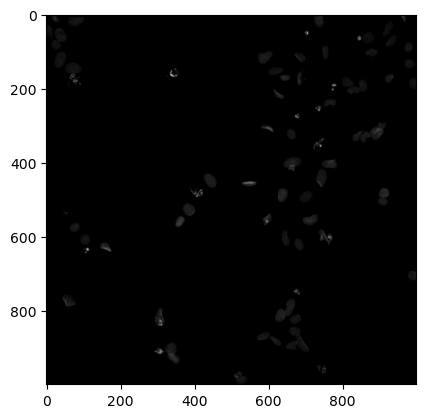

In [25]:
import os
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import boto3

image_url = os.path.join(
    sample_linked.iloc[0].PathName_OrigDNA, sample_linked.iloc[0].FileName_OrigDNA
)
print(' Image url: ', image_url)
print(' Bucket   : ', image_url.split("/")[2])
print(' Key      : ', image_url.split("/")[3:])
s3_client = boto3.client("s3")
response = s3_client.get_object(
    Bucket=image_url.split("/")[2], Key="/".join(image_url.split("/")[3:])
)
image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")

plt.imshow(image, cmap="gray")
image_url


There's a lot more to come! We will add more example notebooks as we go.